# Importation des packages necessaires à l'étude 

In [138]:
# Import des packages
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import scipy.stats as st
import os
import sys
from skimpy import skim
import matplotlib.pyplot as plt


sys.path.insert(0, str(Path(os.getcwd()).resolve().parent.parent))
from Churn_contrat_auto.src.utils.tools import (
    rename_field_categories,
    distrib_for_cat_by_target,
    distrib_for_cont_by_target,
    boxplot_by_target,
    plot_generic,
    cramers_v_between_all,
    cramers_v_with_target,
    graph_correlations,
    extract_corr_pairs,
)

In [139]:
display.max_columns = None

#### Objectif : cibler les clients qui vont résilier leur contrat auto

# 1. Import des données

In [140]:
# On se palce dans Churn_contrat_auto sur son terminal 
df = pd.read_csv('/Users/melaniedaddio/Desktop/Cours_M2/M2_S2/scoring/Churn_contrat_auto/data/raw/ResiliationContratAuto.txt',
                 sep = '|',
                 encoding = 'latin1') # On rajoute l'encoding car ici nous ne sommes pas en utf8
df.head()

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_35803/456036584.py:2: DtypeWarning: Columns (37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/melaniedaddio/Desktop/Cours_M2/M2_S2/scoring/Churn_contrat_auto/data/raw/ResiliationContratAuto.txt',


NO_AFR  CDUSGAUT     IDECON  CD_AGT CD_FML CDPRGES  DTDBUCON  \
0  A00104001204707     611.0  205808992  A00104      R   4190A     14630   
1  A00104001270809     636.0  105939601  A00104      C   4190A     14701   
2  A00104001397301     611.0  306115473  A00104      C   4190A     14848   
3  A00104001402563     611.0  206122172  A00104      C   4190A     14861   
4  A00104716130632     603.0      35070  A00104      S   4190A      4018   

   DTEFTMVT  MMJECHPP  MTPAATTC  ... RESIV  RESDI  CLIACTIF         U  \
0     14812     121.0   1929.66  ...   NaN    NaN       OUI  0.630638   
1     14701     401.0   4106.44  ...   NaN    NaN       OUI  0.012901   
2     14848     826.0   4821.80  ...   0.0    0.0       OUI  0.417773   
3     14861     908.0   9460.74  ...   0.0    0.0       OUI  0.508437   
4     14707     407.0   1530.09  ...   NaN    NaN       OUI  0.615430   

   CONTRAT  ETAT MOTIFRSL COEFCOMM COEFPFLT  CRM  
0    ACTIF    CO      NaN      100   0.8500   50  
1    ACTIF    CO      NaN      100   0.7500   76  
2    ACTIF    CO      NaN      100   0.9000   95  
3    ACTIF    CO      NaN      100   0.9000   95  
4    ACTIF    CO      NaN       91   0.8065   50  

[5 rows x 58 columns]

In [141]:
print(f'Nb lignes : {len(df)}')
print(f'Nb champs : {len(df.columns)}')

Nb lignes : 90247
Nb champs : 58


In [142]:
print(df.CONTRAT.value_counts())
print(df.CONTRAT.value_counts()/df.shape[0])

CONTRAT
ACTIF    80117
RESIL    10130
Name: count, dtype: int64
CONTRAT
ACTIF    0.887753
RESIL    0.112247
Name: count, dtype: float64


📌 POINT : 
----------
- Notre dataframe contient 90247 et 58 colonnes. On peut directement avoir l'intuition qu'il faudra surement réaliser une sélection de variable afin de rendre notre modèle plus performants et eviter la multicolinéarité.
- La variable que nous cherchons à predire est la variable "CONTRAT". Cette dernière nous indique si un client est toujours assuré ou non. On remarque directement que notre cible est désequilibrée, avec majoritairement (90%) des clients actifs contre une minorité de clients résiliés (10%).


# 2. Compréhension des données

### Afin de rendre l'interpretation des résultats plus simple nous avons décidé de modifier le noms de variables de bases qui n'était pas forcement très parlant et mettre les bon type à nos variables: 

In [143]:
df.columns

Index(['NO_AFR', 'CDUSGAUT', 'IDECON', 'CD_AGT', 'CD_FML', 'CDPRGES',
       'DTDBUCON', 'DTEFTMVT', 'MMJECHPP', 'MTPAATTC', 'AUTO4R', 'NOCLIGES',
       'NUMFOY', 'CDMARVEH', 'DTOBTPDC', 'DTPMRMCI', 'LBMDLVH', 'NOTAREFF',
       'PUI_TRE', 'RN_VL_VH', 'S_2_N', 'S_3_N', 'S_1_N', 'S_0_N', 'S_3_O',
       'S_2_O', 'S_1_O', 'S_0_O', 'NIVBM', 'MTPAAREF', 'CDMCE', 'NBCTRES',
       'ANCCLI', 'CD_CSP', 'CD_SEX', 'DT_NAI', 'CDSITFAM', 'DEPT', 'REGION',
       'NBCTACT', 'AU4R', 'MH', 'DI', 'SA', 'IV', 'RESAU4R', 'RESMH', 'RESSA',
       'RESIV', 'RESDI', 'CLIACTIF', 'U', 'CONTRAT', 'ETAT', 'MOTIFRSL',
       'COEFCOMM', 'COEFPFLT', 'CRM'],
      dtype='object')

In [144]:
renommage_vars = {
    "NO_AFR": "numero_affaire",
    "CDUSGAUT": "code_usage_auto",
    "IDECON": "id_contrat",
    "CD_AGT": "code_agent",
    "CD_FML": "code_formule",
    "CDPRGES": "code_produit_gestion",
    "DTDBUCON": "date_debut_contrat",
    "DTEFTMVT": "date_dernier_mouvement",
    "MMJECHPP": "echeance_contrat", 
    "MTPAATTC": "prime_annuelle_ttc",
    "AUTO4R": "auto_4_roues",
    "NOCLIGES": "numero_client_gestion",
    "NUMFOY": "numero_foyer",
    "CDMARVEH": "code_marque_vehicule",
    "DTOBTPDC": "date_obtention_permis",
    "DTPMRMCI": "date_mise_circulation",
    "LBMDLVH": "libelle_modele_vehicule",
    "NOTAREFF": "numero_tarif",
    "PUI_TRE": "puissance_fiscale",
    "RN_VL_VH": "rang_valeur_vehicule",
    "S_2_N": "nb_sinistres_2_ans_non_resp",
    "S_3_N": "nb_sinistres_3_ans_non_resp",
    "S_1_N": "nb_sinistres_1_an_non_resp",
    "S_0_N": "nb_sinistres_0_an_non_resp",
    "S_3_O": "nb_sinistres_3_ans_resp",
    "S_2_O": "nb_sinistres_2_ans_resp",
    "S_1_O": "nb_sinistres_1_an_resp",
    "S_0_O": "nb_sinistres_0_an_resp",
    "NIVBM": "niveau_bonus_malus",
    "MTPAAREF": "prime_reference",
    "CDMCE": "code_marche",
    "NBCTRES": "nb_contrats_resilies",
    "ANCCLI": "anciennete_client",
    "CD_CSP": "code_csp",
    "CD_SEX": "sexe",
    "DT_NAI": "date_naissance",
    "CDSITFAM": "situation_familiale",
    "DEPT": "departement",
    "REGION": "region",
    "NBCTACT": "nb_contrats_actifs",
    "AU4R": "nb_contrats_actifs_auto",
    "MH": "nb_contrats_actifs_habitation",
    "DI": "nb_contrats_actifs_divers",
    "SA": "nb_contrats_actifs_sante",
    "IV": "nb_contrats_actifs_vie",
    "RESAU4R": "nb_contrats_auto_resilies",
    "RESMH": "nb_contrats_habitation_resilies",
    "RESSA": "nb_contrats_sante_resilies",
    "RESIV": "nb_contrats_vie_resilies",
    "RESDI": "nb_contrats_divers_resilies",
    "CLIACTIF": "client_actif",
    "U": "score_u",
    "CONTRAT": "contrat",
    "ETAT": "etat",
    "MOTIFRSL": "motif_resiliation",
    "COEFCOMM": "coefficient_commission",
    "COEFPFLT": "coefficient_profil_tarif",
    "CRM": "crm"
}


In [145]:
df.rename(columns=renommage_vars, inplace=True)

In [146]:
df.head()

numero_affaire  code_usage_auto  id_contrat code_agent code_formule  \
0  A00104001204707            611.0   205808992     A00104            R   
1  A00104001270809            636.0   105939601     A00104            C   
2  A00104001397301            611.0   306115473     A00104            C   
3  A00104001402563            611.0   206122172     A00104            C   
4  A00104716130632            603.0       35070     A00104            S   

  code_produit_gestion  date_debut_contrat  date_dernier_mouvement  \
0                4190A               14630                   14812   
1                4190A               14701                   14701   
2                4190A               14848                   14848   
3                4190A               14861                   14861   
4                4190A                4018                   14707   

   echeance_contrat  prime_annuelle_ttc  ... nb_contrats_vie_resilies  \
0             121.0             1929.66  ...                      NaN   
1             401.0             4106.44  ...                      NaN   
2             826.0             4821.80  ...                      0.0   
3             908.0             9460.74  ...                      0.0   
4             407.0             1530.09  ...                      NaN   

   nb_contrats_divers_resilies  client_actif   score_u  contrat  etat  \
0                          NaN           OUI  0.630638    ACTIF    CO   
1                          NaN           OUI  0.012901    ACTIF    CO   
2                          0.0           OUI  0.417773    ACTIF    CO   
3                          0.0           OUI  0.508437    ACTIF    CO   
4                          NaN           OUI  0.615430    ACTIF    CO   

  motif_resiliation coefficient_commission coefficient_profil_tarif  crm  
0               NaN                    100                   0.8500   50  
1               NaN                    100                   0.7500   76  
2               NaN                    100                   0.9000   95  
3               NaN                    100                   0.9000   95  
4               NaN                     91                   0.8065   50  

[5 rows x 58 columns]

In [147]:
df.info() # nous donne le type de stockage de chaque variable

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90247 entries, 0 to 90246
Data columns (total 58 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   numero_affaire                   90247 non-null  object 
 1   code_usage_auto                  90231 non-null  float64
 2   id_contrat                       90247 non-null  int64  
 3   code_agent                       90247 non-null  object 
 4   code_formule                     89702 non-null  object 
 5   code_produit_gestion             90247 non-null  object 
 6   date_debut_contrat               90247 non-null  int64  
 7   date_dernier_mouvement           90247 non-null  int64  
 8   echeance_contrat                 90231 non-null  float64
 9   prime_annuelle_ttc               90247 non-null  float64
 10  auto_4_roues                     90247 non-null  object 
 11  numero_client_gestion            90247 non-null  int64  
 12  numero_foyer      

In [148]:
# Valeur distinctes pour chaques variables de notre df:
df_nunique = df.nunique().reset_index().rename(columns={'index':'Champ',0:'Nb_Distinct_Values'})\
                .sort_values('Nb_Distinct_Values',ascending=False)
df_nunique

Champ  Nb_Distinct_Values
51                          score_u               90247
0                    numero_affaire               90243
2                        id_contrat               90243
11            numero_client_gestion               88018
12                     numero_foyer               87025
9                prime_annuelle_ttc               79717
35                   date_naissance               22300
14            date_obtention_permis               15770
29                  prime_reference               14957
32                anciennete_client                9760
6                date_debut_contrat                8977
56         coefficient_profil_tarif                7692
16          libelle_modele_vehicule                6806
3                        code_agent                1255
7            date_dernier_mouvement                1093
15            date_mise_circulation                 557
8                  echeance_contrat                 365
13             code_marque_vehicule                 256
33                         code_csp                 234
37                      departement                 196
55           coefficient_commission                  99
57                              crm                  94
28               niveau_bonus_malus                  94
1                   code_usage_auto                  71
39               nb_contrats_actifs                  35
4                      code_formule                  25
44           nb_contrats_actifs_vie                  24
41    nb_contrats_actifs_habitation                  18
40          nb_contrats_actifs_auto                  18
19             rang_valeur_vehicule                  18
17                     numero_tarif                  17
31             nb_contrats_resilies                  16
54                motif_resiliation                  15
18                puissance_fiscale                  14
42        nb_contrats_actifs_divers                  14
45        nb_contrats_auto_resilies                  12
38                           region                  11
49      nb_contrats_divers_resilies                   8
46  nb_contrats_habitation_resilies                   8
43         nb_contrats_actifs_sante                   8
36              situation_familiale                   7
5              code_produit_gestion                   6
47       nb_contrats_sante_resilies                   6
21      nb_sinistres_3_ans_non_resp                   5
22       nb_sinistres_1_an_non_resp                   5
23       nb_sinistres_0_an_non_resp                   4
24          nb_sinistres_3_ans_resp                   4
20      nb_sinistres_2_ans_non_resp                   4
53                             etat                   4
25          nb_sinistres_2_ans_resp                   3
48         nb_contrats_vie_resilies                   3
26           nb_sinistres_1_an_resp                   3
27           nb_sinistres_0_an_resp                   3
50                     client_actif                   2
52                          contrat                   2
34                             sexe                   2
30                      code_marche                   2
10                     auto_4_roues                   1

In [149]:
df.isnull().sum()/df.shape[0] 

numero_affaire                     0.000000
code_usage_auto                    0.000177
id_contrat                         0.000000
code_agent                         0.000000
code_formule                       0.006039
code_produit_gestion               0.000000
date_debut_contrat                 0.000000
date_dernier_mouvement             0.000000
echeance_contrat                   0.000177
prime_annuelle_ttc                 0.000000
auto_4_roues                       0.000000
numero_client_gestion              0.000000
numero_foyer                       0.000000
code_marque_vehicule               0.000964
date_obtention_permis              0.002139
date_mise_circulation              0.010327
libelle_modele_vehicule            0.001219
numero_tarif                       0.002959
puissance_fiscale                  0.001839
rang_valeur_vehicule               0.001884
nb_sinistres_2_ans_non_resp        0.894600
nb_sinistres_3_ans_non_resp        0.910280
nb_sinistres_1_an_non_resp      

💡 CONSTATS ET INTUITIONS : 
------

Nous allons supprimer les variables identifiants ou sans varaince : 
- La variable auto_4_roues ne nous apporte aucunes information car une modalité. Nous allons donc la supprimer.
- Nous avons supprimer numero_affaire, id_contrat, numero_client_gestion, numero_foyer.

Certaines variables de dates comme : date_naissance, date_obtention_permis, date_mise_circulation, date_debut_contrat, date_dernier_mouvement, echeance_contrat, echeance_contrat_periode, sont à transformer pour la suite. Par exemple obetnir des variables comme age, durée, etc


⚠️ On peut supposer qu'il faudra mettre les variables à moins de 10 modalité en categorielles. (Plus precisement les variables de "nombre" à moins de 10 modalités -> utile seulement dans le cas d'un modele de reg log)

On constate que beaucoup de nos variables ne semblent pas au bon type. Pour faciliter nos future interpretations (graphique) il est preferable de corriger ce problème des maintenant. 

In [150]:
df.drop(columns=['numero_affaire', 'id_contrat', "numero_client_gestion", "numero_foyer", "auto_4_roues"], inplace=True)

## 2.1 Variables de temps : 

### 2.1.1 Traitement :

⚠️ Vérifies bien anciennete_client et echeance_contrat !

In [151]:
var_date = ['date_debut_contrat', 'date_dernier_mouvement', 'date_obtention_permis', 'date_mise_circulation', 'date_naissance', 'anciennete_client', 'echeance_contrat']

In [152]:
df[var_date]

date_debut_contrat  date_dernier_mouvement  date_obtention_permis  \
0                   14630                   14812                10273.0   
1                   14701                   14701                12877.0   
2                   14848                   14848                14196.0   
3                   14861                   14861                14629.0   
4                    4018                   14707                    NaN   
...                   ...                     ...                    ...   
90242               13340                   14801                11197.0   
90243               13504                   14051                 9212.0   
90244               14335                   14335                 9303.0   
90245               14474                   14840                13559.0   
90246               11578                   14866                 9890.0   

       date_mise_circulation  date_naissance  anciennete_client  \
0                    10683.0          3639.0            14598.0   
1                    11262.0          6093.0            14701.0   
2                     9678.0         -8391.0             8866.0   
3                    11870.0          7904.0            13872.0   
4                     5935.0         -3633.0             4018.0   
...                      ...             ...                ...   
90242                11323.0           -66.0            13340.0   
90243                10624.0          2181.0            13504.0   
90244                10897.0          2702.0            11401.0   
90245                10593.0          6627.0            13590.0   
90246                 7518.0          3167.0            11578.0   

       echeance_contrat  
0                 121.0  
1                 401.0  
2                 826.0  
3                 908.0  
4                 407.0  
...                 ...  
90242             710.0  
90243             621.0  
90244             401.0  
90245             818.0  
90246             913.0  

[90247 rows x 7 columns]

* Les valeurs comme 14630, 12877, 6093 sont typiques de "jours depuis 1970-01-01". Vérifions cette hypothèse.

In [153]:
var_date_excel = ['date_debut_contrat', 'date_dernier_mouvement', 'date_obtention_permis', 'date_mise_circulation', 'date_naissance']

In [154]:
origin = pd.Timestamp("1970-01-01")
min_days = -40000
max_days = 100000

df_dates = df[var_date_excel].copy()

for col in df_dates.columns:
    valid = df_dates[col].between(min_days, max_days)
    df_dates[col + "_converted"] = pd.NaT
    df_dates.loc[valid, col + "_converted"] = pd.to_datetime(origin + pd.to_timedelta(df_dates.loc[valid, col], unit="D"))

df_dates[[col + "_converted" for col in var_date_excel]].head()


date_debut_contrat_converted date_dernier_mouvement_converted  \
0                   2010-01-21                       2010-07-22   
1                   2010-04-02                       2010-04-02   
2                   2010-08-27                       2010-08-27   
3                   2010-09-09                       2010-09-09   
4                   1981-01-01                       2010-04-08   

  date_obtention_permis_converted date_mise_circulation_converted  \
0                      1998-02-16                      1999-04-02   
1                      2005-04-04                      2000-11-01   
2                      2008-11-13                      1996-07-01   
3                      2010-01-20                      2002-07-02   
4                             NaT                      1986-04-02   

  date_naissance_converted  
0               1979-12-19  
1               1986-09-07  
2               1947-01-11  
3               1991-08-23  
4               1960-01-21

In [155]:
# Ajouter les colonnes converties de df_dates à df
columns_to_add = [col for col in df_dates.columns if col.endswith("_converted")]
df = pd.concat([df, df_dates[columns_to_add]], axis=1)

In [156]:
df.head()

code_usage_auto code_agent code_formule code_produit_gestion  \
0            611.0     A00104            R                4190A   
1            636.0     A00104            C                4190A   
2            611.0     A00104            C                4190A   
3            611.0     A00104            C                4190A   
4            603.0     A00104            S                4190A   

   date_debut_contrat  date_dernier_mouvement  echeance_contrat  \
0               14630                   14812             121.0   
1               14701                   14701             401.0   
2               14848                   14848             826.0   
3               14861                   14861             908.0   
4                4018                   14707             407.0   

   prime_annuelle_ttc code_marque_vehicule  date_obtention_permis  ...  etat  \
0             1929.66              PEUGEOT                10273.0  ...    CO   
1             4106.44              PEUGEOT                12877.0  ...    CO   
2             4821.80              PEUGEOT                14196.0  ...    CO   
3             9460.74              RENAULT                14629.0  ...    CO   
4             1530.09             MERCEDES                    NaN  ...    CO   

  motif_resiliation coefficient_commission coefficient_profil_tarif  crm  \
0               NaN                    100                   0.8500   50   
1               NaN                    100                   0.7500   76   
2               NaN                    100                   0.9000   95   
3               NaN                    100                   0.9000   95   
4               NaN                     91                   0.8065   50   

   date_debut_contrat_converted  date_dernier_mouvement_converted  \
0                    2010-01-21                        2010-07-22   
1                    2010-04-02                        2010-04-02   
2                    2010-08-27                        2010-08-27   
3                    2010-09-09                        2010-09-09   
4                    1981-01-01                        2010-04-08   

   date_obtention_permis_converted  date_mise_circulation_converted  \
0                       1998-02-16                       1999-04-02   
1                       2005-04-04                       2000-11-01   
2                       2008-11-13                       1996-07-01   
3                       2010-01-20                       2002-07-02   
4                              NaT                       1986-04-02   

   date_naissance_converted  
0                1979-12-19  
1                1986-09-07  
2                1947-01-11  
3                1991-08-23  
4                1960-01-21  

[5 rows x 58 columns]

🤔 Est-ce que les dates converties ont du sens ?

- date_naissance convertie ≈ années 1950–2000 ?

- date_debut_contrat ≈ 2000–2024 ?

- date_dernier_mouvement ≥ date_debut_contrat ?

In [157]:
df_dates.describe()

date_debut_contrat  date_dernier_mouvement  date_obtention_permis  \
count        90247.000000            90247.000000           90054.000000   
mean         11978.749166            14730.439006            6205.395785   
min         -21549.000000             8948.000000          -14244.000000   
25%          10750.000000            14693.000000            2518.000000   
50%          12626.000000            14765.000000            6552.500000   
75%          13970.000000            14807.000000           10246.000000   
max          14883.000000            14944.000000           14879.000000   
std           2622.812793              188.381009            5070.297584   

       date_mise_circulation  date_naissance   date_debut_contrat_converted  \
count           89315.000000    90042.000000                          90247   
mean            11428.437026    -2936.040181  2002-10-18 17:58:47.957716224   
min            -21549.000000  -111462.000000            1911-01-02 00:00:00   
25%             10227.000000    -6758.000000            1999-06-08 00:00:00   
50%             11535.000000    -2674.000000            2004-07-27 00:00:00   
75%             13027.000000     1424.000000            2008-04-01 00:00:00   
max             14792.000000    14610.000000            2010-10-01 00:00:00   
std              2153.892706     5696.195202                            NaN   

      date_dernier_mouvement_converted date_obtention_permis_converted  \
count                            90247                           90054   
mean     2010-05-01 10:32:10.142830080   1986-12-28 09:29:55.802518464   
min                1994-07-02 00:00:00             1931-01-02 00:00:00   
25%                2010-03-25 00:00:00             1976-11-23 00:00:00   
50%                2010-06-05 00:00:00             1987-12-10 12:00:00   
75%                2010-07-17 00:00:00             1998-01-20 00:00:00   
max                2010-12-01 00:00:00             2010-09-27 00:00:00   
std                                NaN                             NaN   

      date_mise_circulation_converted       date_naissance_converted  
count                           89315                          90035  
mean    2001-04-16 10:29:19.068465664  1961-12-25 06:29:59.540178816  
min               1911-01-02 00:00:00            1867-04-01 00:00:00  
25%               1998-01-01 00:00:00            1951-07-02 00:00:00  
50%               2001-08-01 00:00:00            1962-09-07 00:00:00  
75%               2005-09-01 00:00:00            1973-11-26 00:00:00  
max               2010-07-02 00:00:00            2010-01-01 00:00:00  
std                               NaN                            NaN

* **Ancienneté Client** 

🤔 On cherche à savoir s'il s'agit :
- d'une date (encodée comme les autres)
- ou d'une durée en jours

In [158]:
valid = df["anciennete_client"].between(-40000, 100000)
df["anciennete_date"] = pd.NaT
df.loc[valid, "anciennete_date"] = pd.to_datetime(origin + pd.to_timedelta(df.loc[valid, "anciennete_client"], unit="D"))

df["date_debut_contrat_date"] = pd.to_datetime(origin + pd.to_timedelta(df["date_debut_contrat"], unit="D"))
df["écart_jours_anciennete"] = (df["date_debut_contrat_date"] - df["anciennete_date"]).dt.days

df[["anciennete_client", "anciennete_date", "date_debut_contrat_date", "écart_jours_anciennete"]].head(10)


anciennete_client anciennete_date date_debut_contrat_date  \
0            14598.0      2009-12-20              2010-01-21   
1            14701.0      2010-04-02              2010-04-02   
2             8866.0      1994-04-11              2010-08-27   
3            13872.0      2007-12-25              2010-09-09   
4             4018.0      1981-01-01              1981-01-01   
5             6993.0      1989-02-23              1989-02-23   
6             6056.0      1986-08-01              1989-09-03   
7             8079.0      1992-02-14              1992-02-14   
8             8529.0      1993-05-09              1993-05-09   
9             9066.0      1994-10-28              1994-10-28   

   écart_jours_anciennete  
0                    32.0  
1                     0.0  
2                  5982.0  
3                   989.0  
4                     0.0  
5                     0.0  
6                  1129.0  
7                     0.0  
8                     0.0  
9                     0.0

In [159]:
df[df["écart_jours_anciennete"]<1].shape[0] / df.shape[0] *100

37.57465622125943

Pour beaucoup de lignes, anciennete_client correspond exactement à date_debut_contrat -> écart d'environ 0.

Cependant pour certaines vraiables il y a un écart positif (ex. : 32, 5982, etc.) -> la date anciennete_client est avant la date de début de contrat.

=> anciennete_client est une date encodée en jours depuis 1970, tout comme les autres colonnes de type date ? Ou est ce une durée ?

In [160]:
# Recoder cette variables comme les variables precedentes :
valid = df["anciennete_client"].between(-40000, 100000)
df["anciennete_date"] = pd.NaT
df.loc[valid, "anciennete_date"] = pd.to_datetime(origin + pd.to_timedelta(df.loc[valid, "anciennete_client"], unit="D"))


* **Echeance Contrat :**

Même si la variable s'appelle à la base MMJECHPP, elle n’est probablement pas exprimée en mois.
Son nom est trompeur.

Vu les valeurs et l’échelle, il est beaucoup plus probable qu’il s’agisse d’un nombre de jours.

In [161]:
origin = pd.Timestamp("1970-01-01")
valid = df["echeance_contrat"].between(-40000, 100000)  # plage large pour éviter les erreurs

df["echeance_date_test"] = pd.NaT
df.loc[valid, "echeance_date_test"] = pd.to_datetime(origin + pd.to_timedelta(df.loc[valid, "echeance_contrat"], unit="D"))

print(df[["echeance_contrat", "echeance_date_test"]].sample(10))


       echeance_contrat echeance_date_test
9465             1101.0         1973-01-06
54126            1231.0         1973-05-16
3059              801.0         1972-03-12
65977            1110.0         1973-01-15
72467             908.0         1972-06-27
60532             401.0         1971-02-06
50519             318.0         1970-11-15
5250              907.0         1972-06-26
297               107.0         1970-04-18
5636              207.0         1970-07-27


In [162]:
# Si c'est une durée, on tente d'ajouter cette "durée en jours" à la date de début de contrat
df["echeance_calculee"] = df["date_debut_contrat_date"] + pd.to_timedelta(df["echeance_contrat"], unit="D")

# Comparons avec une éventuelle date réelle d’échéance si on en a une, ou simplement regardons les valeurs :
print(df[["date_debut_contrat_date", "echeance_contrat", "echeance_calculee"]].sample(10))


      date_debut_contrat_date  echeance_contrat echeance_calculee
49734              2005-07-18             718.0        2007-07-06
75717              2002-04-02             401.0        2003-05-08
26002              2002-04-02             401.0        2003-05-08
84713              2009-05-24             524.0        2010-10-30
50292              2008-03-05             305.0        2009-01-04
55731              2005-01-06             106.0        2005-04-22
18055              2010-08-05             802.0        2012-10-15
8644               2003-12-15             614.0        2005-08-20
56125              2005-04-01             101.0        2005-07-11
55436              2010-08-29             828.0        2012-12-04


- echeance_date_test convertit les valeurs en dates autour des années 1970-1973 —> ce qui ne correspond clairement pas à des échéances réelles de contrats (qui seraient plus récentes).

- echeance_calculee (date_debut_contrat + echeance_contrat en jours) produit des dates logiques, dans le futur par rapport à date_debut_contrat_date.

=> Echéance contrat est une durée exprimée en jours. On peut la laisser comme elle est. Est ce la durée restante ou totale du contrat à partir de la date de début ???

### 2.1.2 Création de variables :

Apres cette analyse il nous a parut pertinent pour notre modèle de créer de noivelles variables comme :
- age (à un moment donné)
- anciennete_client 
- duree_contrat 

Cependant un problème se pose : comme nous avons converti nos dates avec un referentiel choisi on fausserait nos resultat si on calculait ces durées en fonction de la date actuelle. 

Nous allons donc calculer ces variables à partir de la date de debut de contrat. 

In [163]:
df["age_au_debut"] = (df["date_debut_contrat_date"] - df["date_naissance_converted"]).dt.days // 365

In [164]:
df["age_mise_circ"] = (df["date_mise_circulation_converted"] - df["date_naissance_converted"]).dt.days // 365

In [165]:
df["delai_permis_contrat"] = (df["date_debut_contrat_date"] - df["date_obtention_permis_converted"]).dt.days // 365

In [166]:
df["age_vehicule"] = (df["date_debut_contrat_date"] - df["date_mise_circulation_converted"]).dt.days // 365

### 2.1.3 Analyse :

In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90247 entries, 0 to 90246
Data columns (total 67 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   code_usage_auto                   90231 non-null  float64       
 1   code_agent                        90247 non-null  object        
 2   code_formule                      89702 non-null  object        
 3   code_produit_gestion              90247 non-null  object        
 4   date_debut_contrat                90247 non-null  int64         
 5   date_dernier_mouvement            90247 non-null  int64         
 6   echeance_contrat                  90231 non-null  float64       
 7   prime_annuelle_ttc                90247 non-null  float64       
 8   code_marque_vehicule              90160 non-null  object        
 9   date_obtention_permis             90054 non-null  float64       
 10  date_mise_circulation             89315 non-nu

In [168]:
var_date_graph = df.select_dtypes(include=['datetime64[ns]']).columns.tolist() + ['echeance_contrat', 'age_au_debut', 'age_mise_circ', 'delai_permis_contrat', 'age_vehicule']

In [169]:
var_sup = [ 'date_debut_contrat_date',
 'echeance_date_test',
 'echeance_calculee']
# On retire ces variables de la liste de var_date_graph car elles ne sont pas utiles
for var in var_sup:
    if var in var_date_graph:
        var_date_graph.remove(var)


In [170]:
var_date_graph

['date_debut_contrat_converted',
 'date_dernier_mouvement_converted',
 'date_obtention_permis_converted',
 'date_mise_circulation_converted',
 'date_naissance_converted',
 'anciennete_date',
 'echeance_contrat',
 'age_au_debut',
 'age_mise_circ',
 'delai_permis_contrat',
 'age_vehicule']

In [171]:
def hist_box(data, var):
    fig, (ax_box, ax_hist) = plt.subplots(nrows=2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    # Boxplot
    sns.boxplot(data=data, x=var, ax=ax_box)
    ax_box.set(xlabel='')
    ax_box.set_title(f"Histogramme et Boxplot pour la variable '{var}'", fontsize=14)

    # Histogramme
    sns.histplot(data=data, x=var, kde=True, ax=ax_hist)
    ax_hist.set(xlabel=var, ylabel='Fréquence')

    plt.tight_layout()
    plt.show()


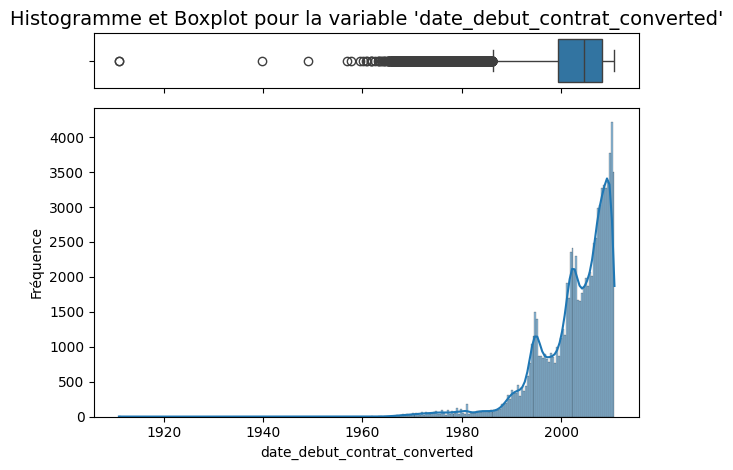

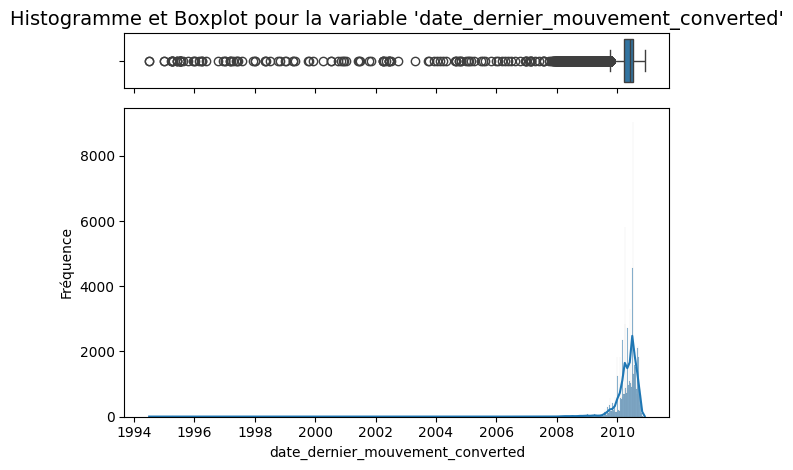

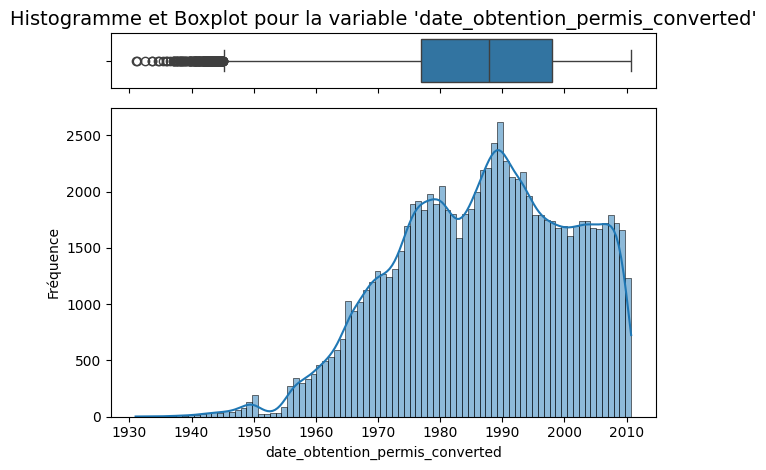

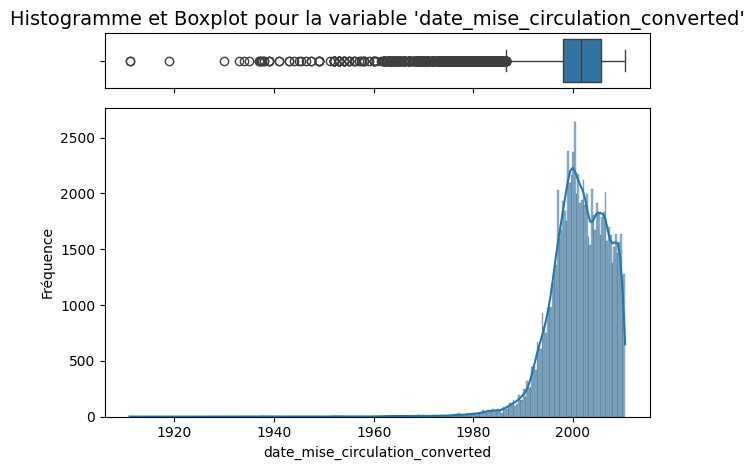

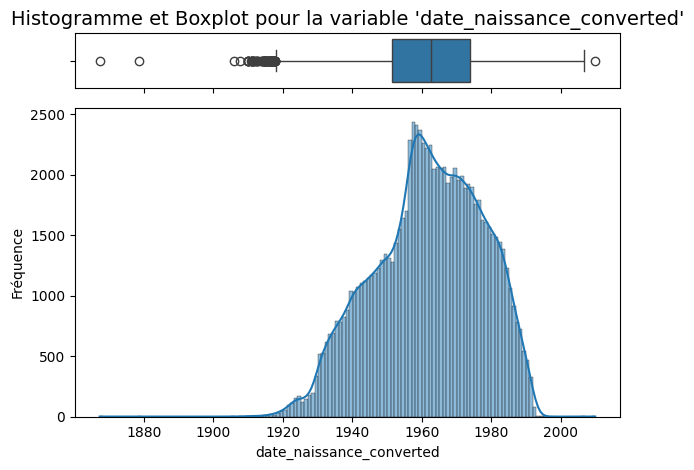

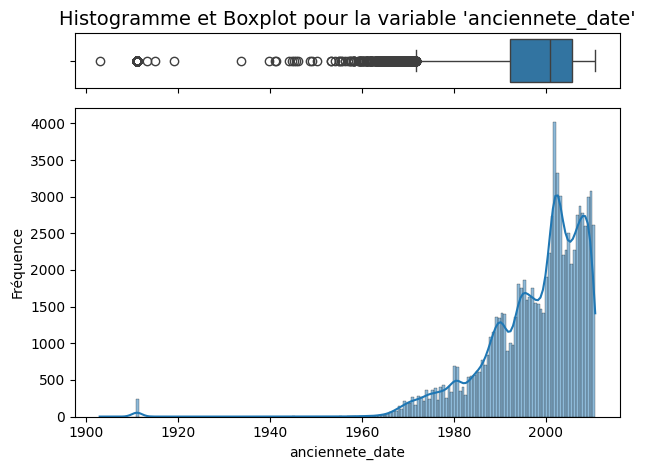

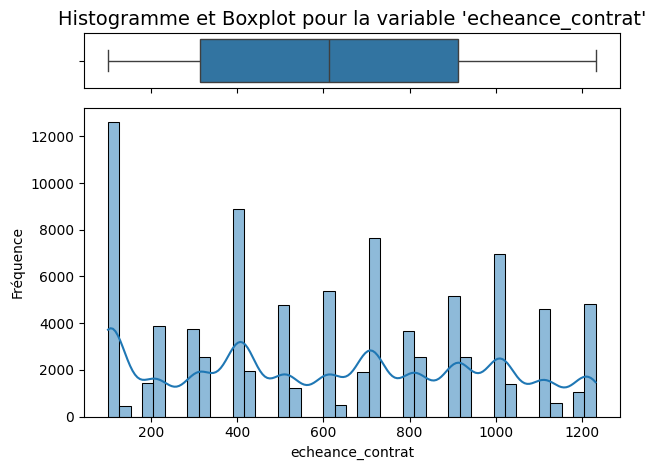

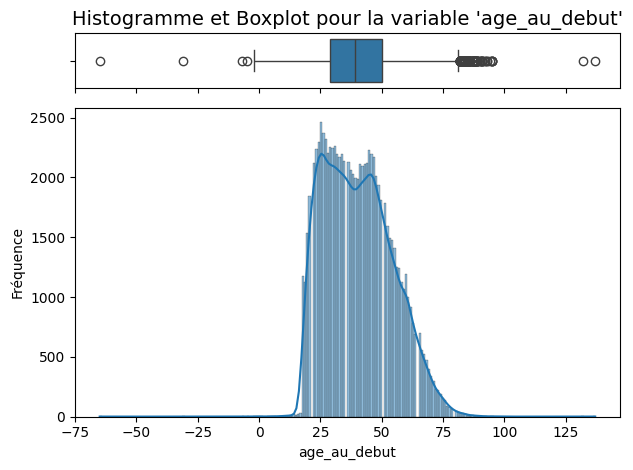

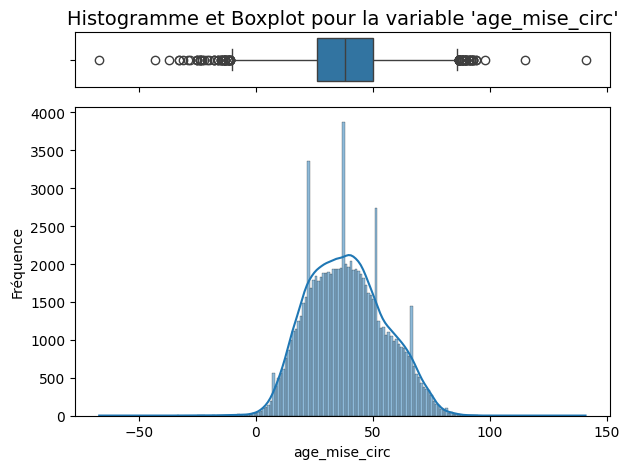

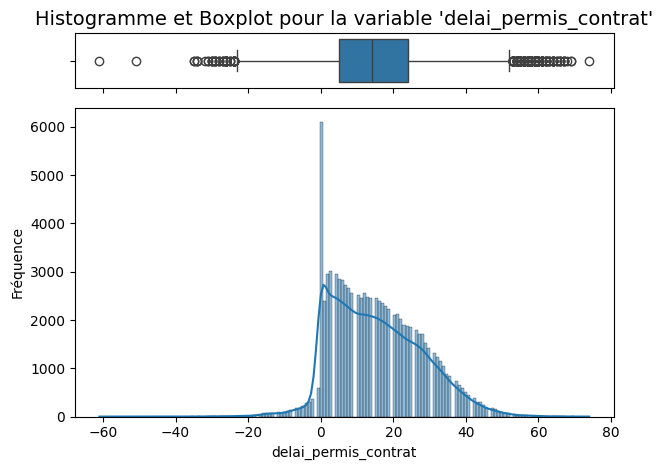

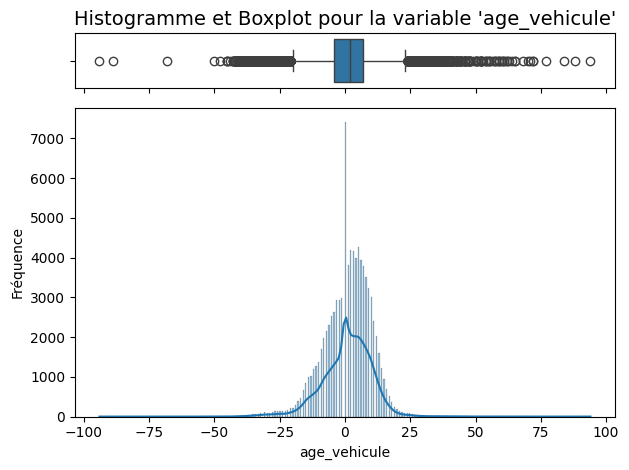

In [172]:
for var in var_date_graph:
    hist_box(df, var)
    

⚠️ ATTENTION :
---
- Certaines variables de dates semblent contenir des dates très faibles (valeurs abberantes)
- Nos variables crées contiennent des valeur negatives à traiter et voir pourquoi ?

### 2.1.4 Analyse et traiment des anomalies :

## 2.2 Variables continues : 

In [173]:
var_num = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [174]:
var_num

['code_usage_auto',
 'date_debut_contrat',
 'date_dernier_mouvement',
 'echeance_contrat',
 'prime_annuelle_ttc',
 'date_obtention_permis',
 'date_mise_circulation',
 'rang_valeur_vehicule',
 'nb_sinistres_2_ans_non_resp',
 'nb_sinistres_3_ans_non_resp',
 'nb_sinistres_1_an_non_resp',
 'nb_sinistres_0_an_non_resp',
 'nb_sinistres_3_ans_resp',
 'nb_sinistres_2_ans_resp',
 'nb_sinistres_1_an_resp',
 'nb_sinistres_0_an_resp',
 'niveau_bonus_malus',
 'prime_reference',
 'nb_contrats_resilies',
 'anciennete_client',
 'code_csp',
 'date_naissance',
 'nb_contrats_actifs',
 'nb_contrats_actifs_auto',
 'nb_contrats_actifs_habitation',
 'nb_contrats_actifs_divers',
 'nb_contrats_actifs_sante',
 'nb_contrats_actifs_vie',
 'nb_contrats_auto_resilies',
 'nb_contrats_habitation_resilies',
 'nb_contrats_sante_resilies',
 'nb_contrats_vie_resilies',
 'nb_contrats_divers_resilies',
 'score_u',
 'motif_resiliation',
 'coefficient_commission',
 'coefficient_profil_tarif',
 'crm',
 'écart_jours_anciennete

In [175]:
to_remove = [
    'motif_resiliation',
    'code_csp',
    'code_usage_auto',
    'date_debut_contrat',
    'date_dernier_mouvement',
    'echeance_contrat',
    'prime_annuelle_ttc',
    'date_obtention_permis',
    'date_mise_circulation',
    'anciennete_client',
    'date_naissance',
    'écart_jours_anciennete',
    'anciennete_jours',
    'anciennete_annees',
    'age_au_debut',
    'age_mise_circ',
    'delai_permis_contrat',
    'age_vehicule'
]

var_num_graph = [var for var in var_num if var not in to_remove]


### 2.2.1 Analyse :

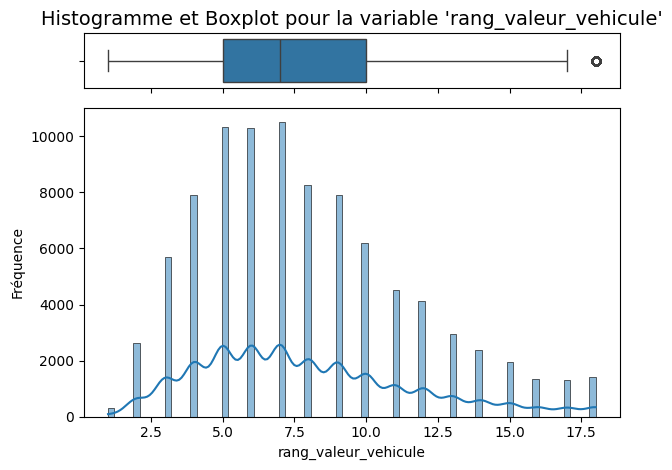

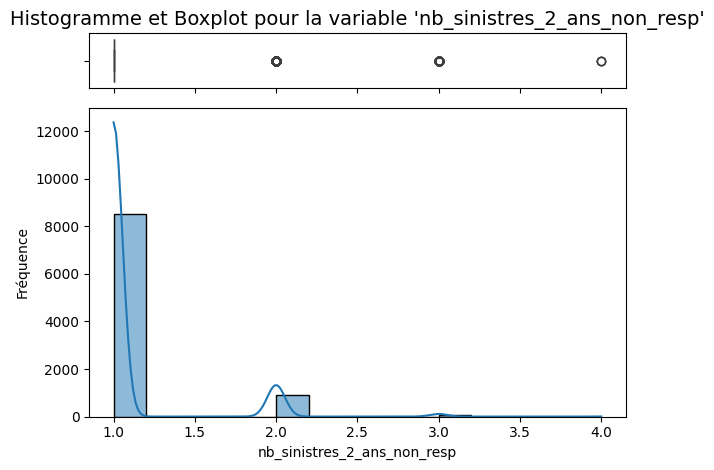

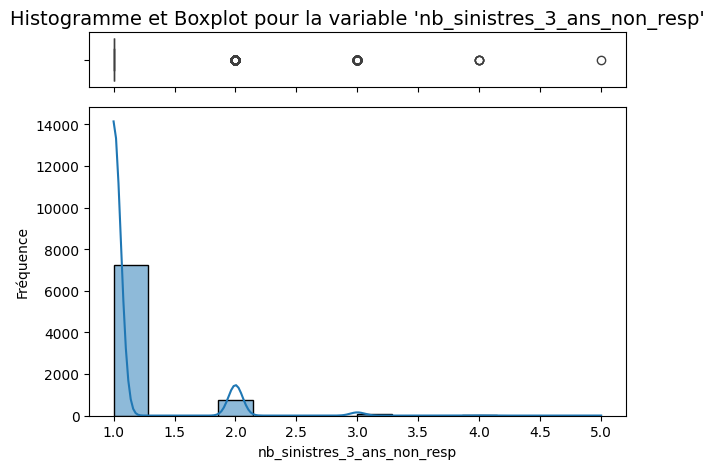

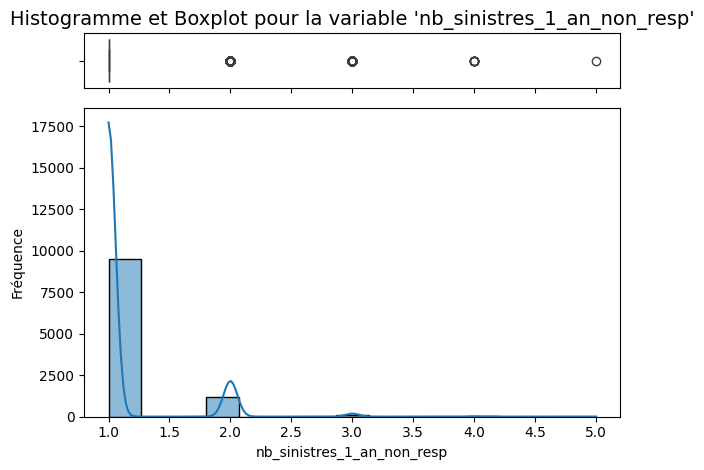

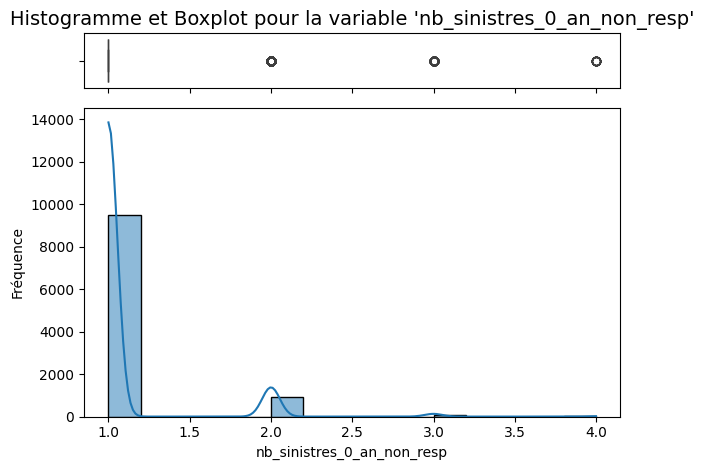

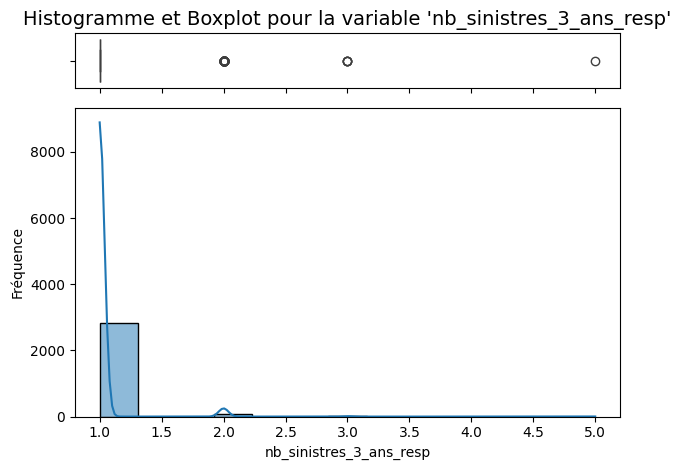

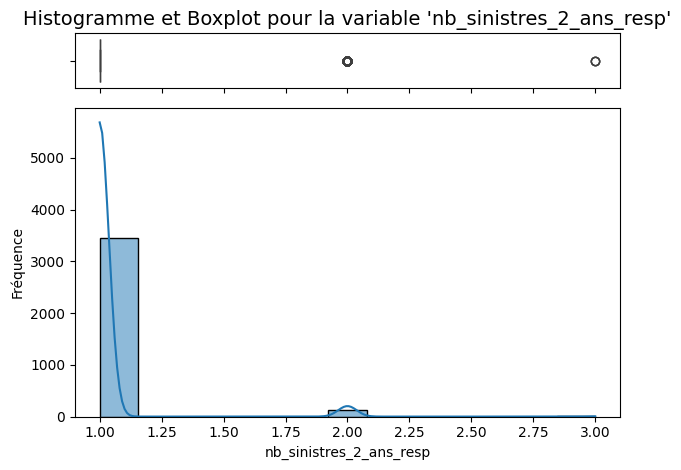

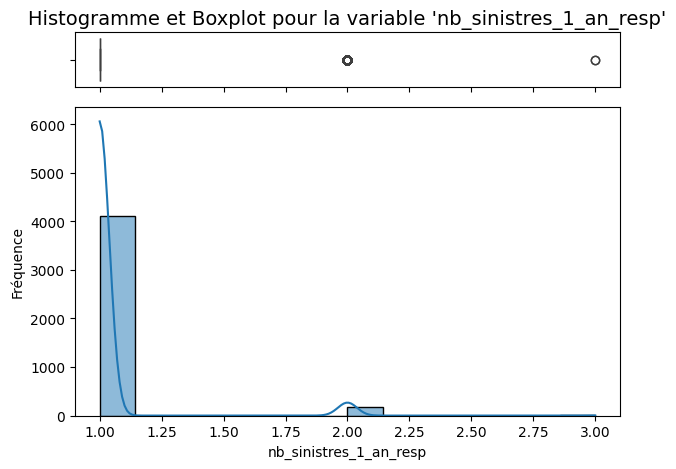

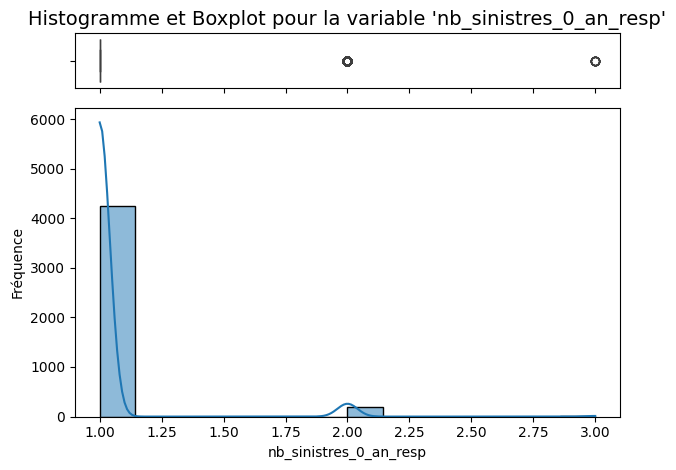

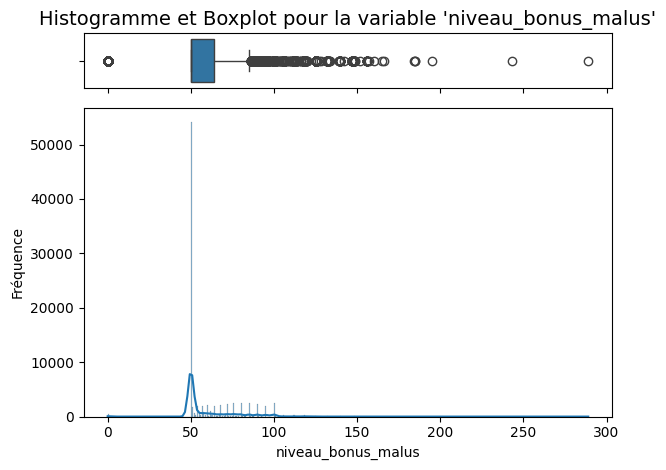

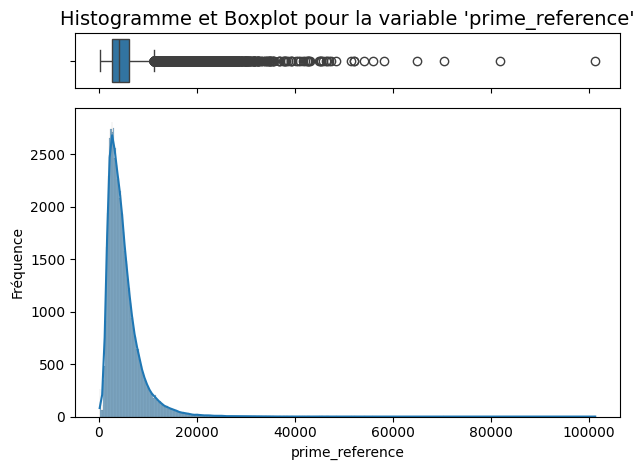

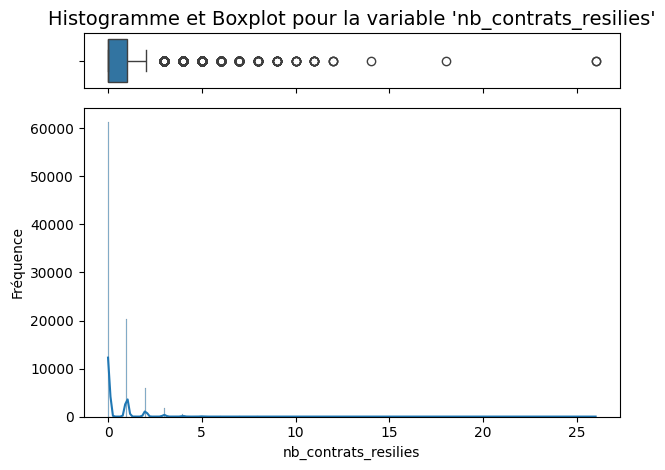

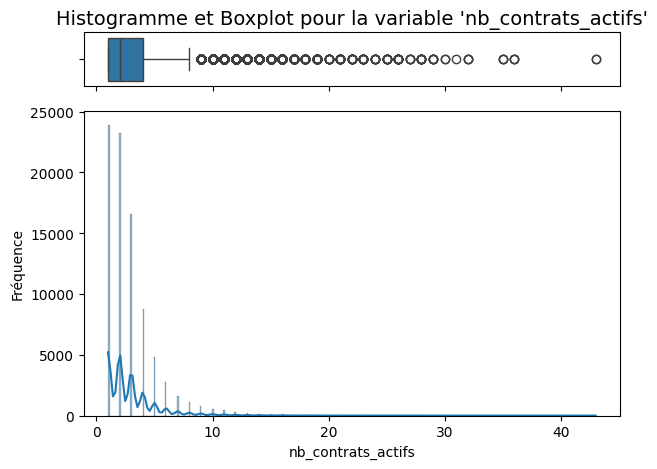

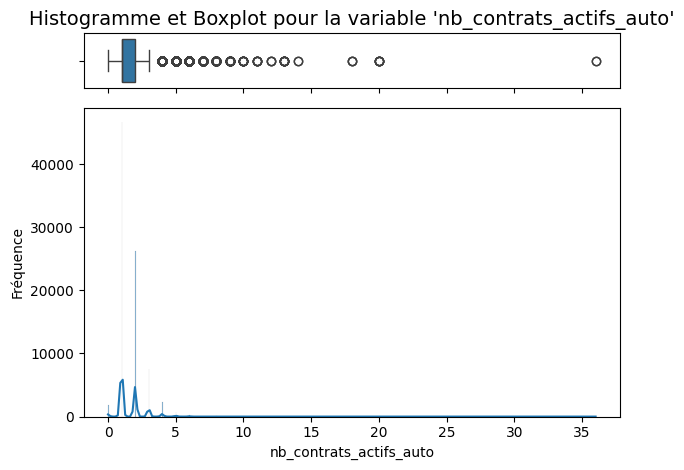

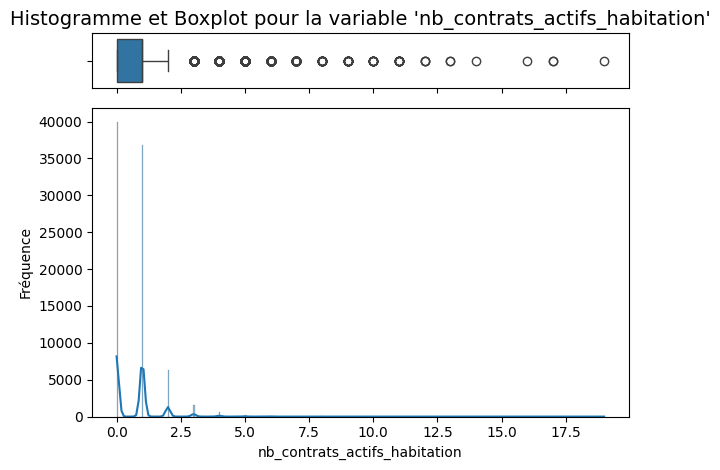

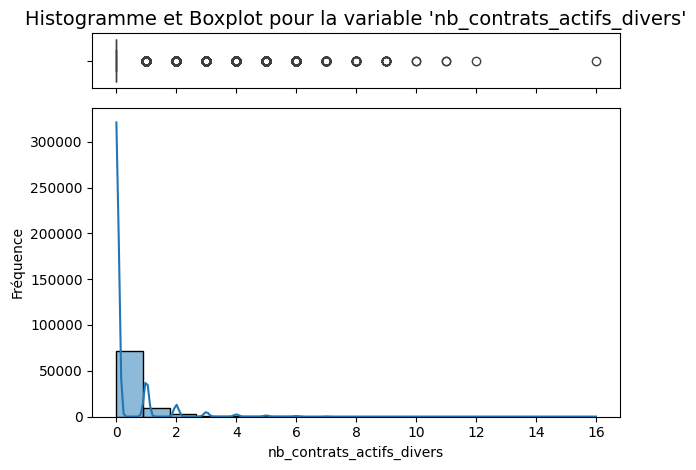

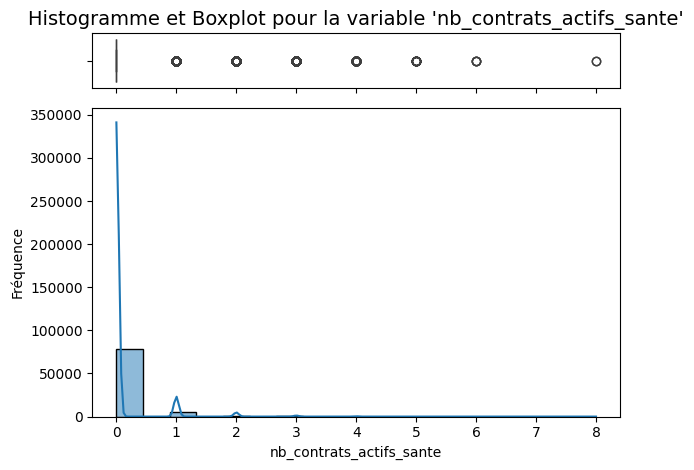

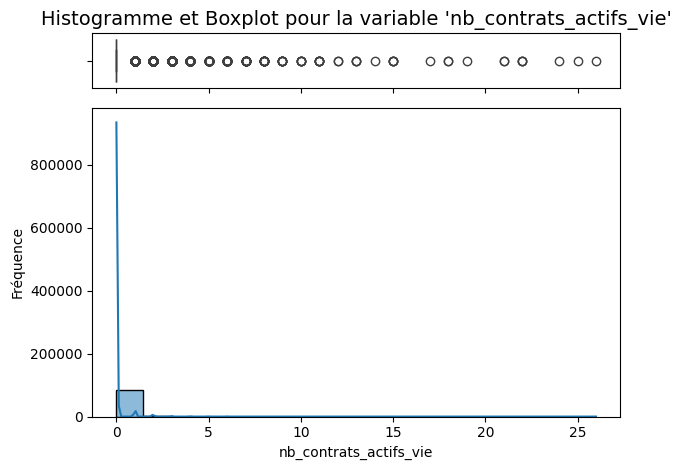

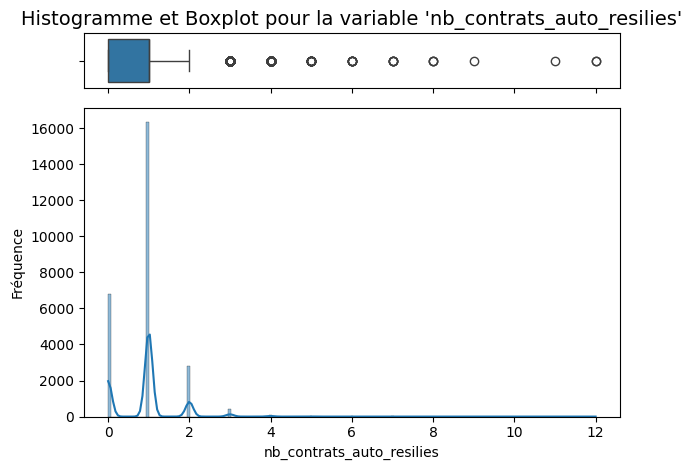

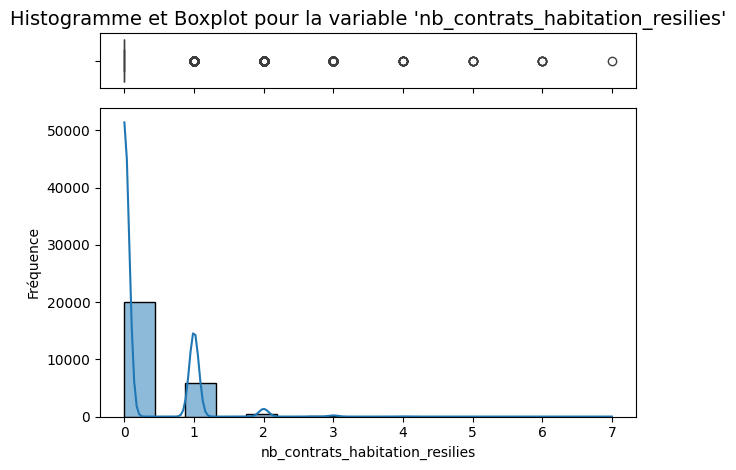

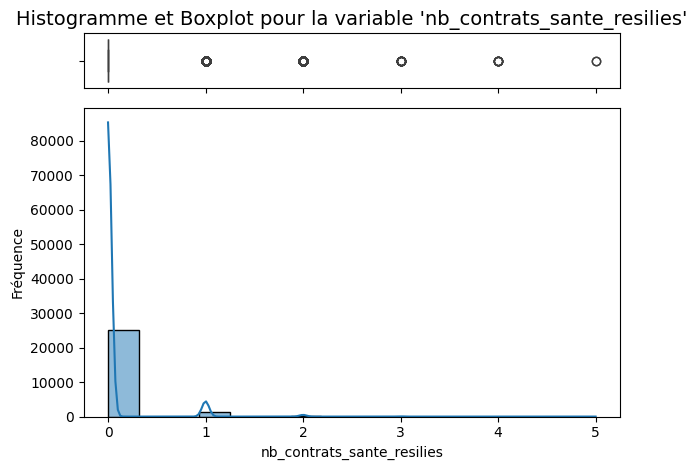

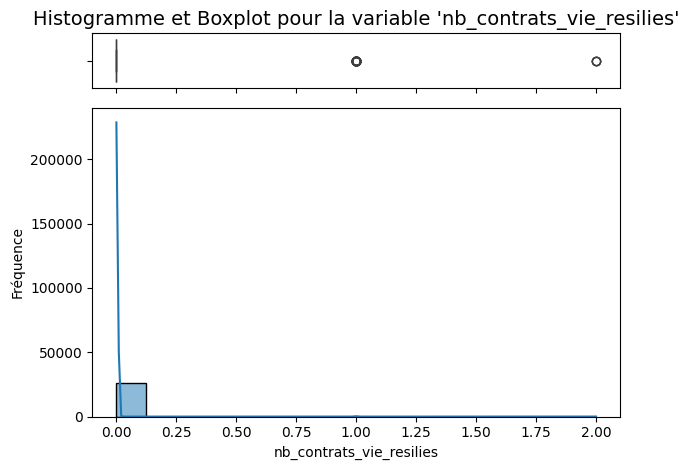

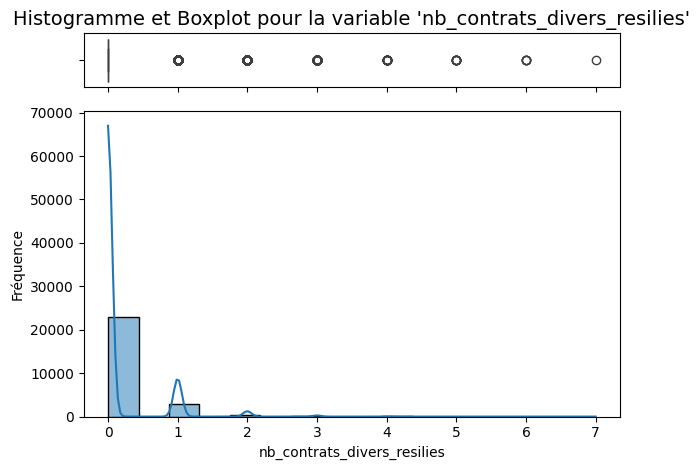

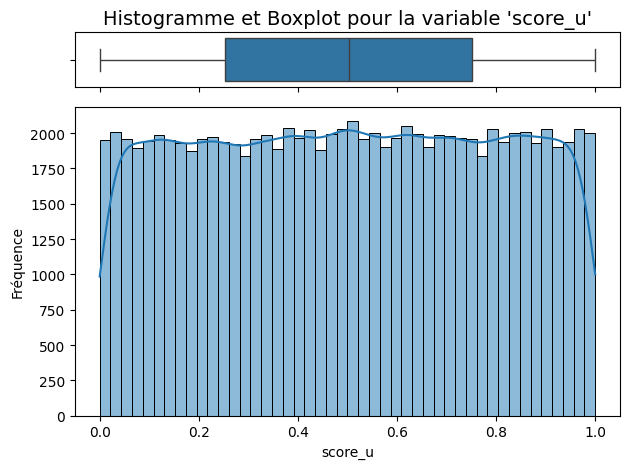

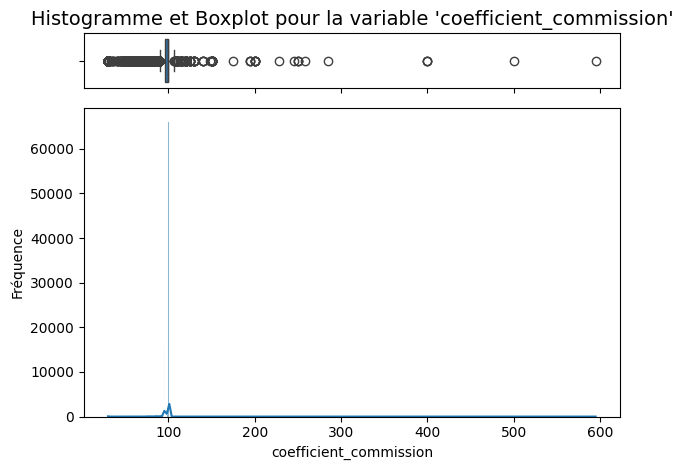

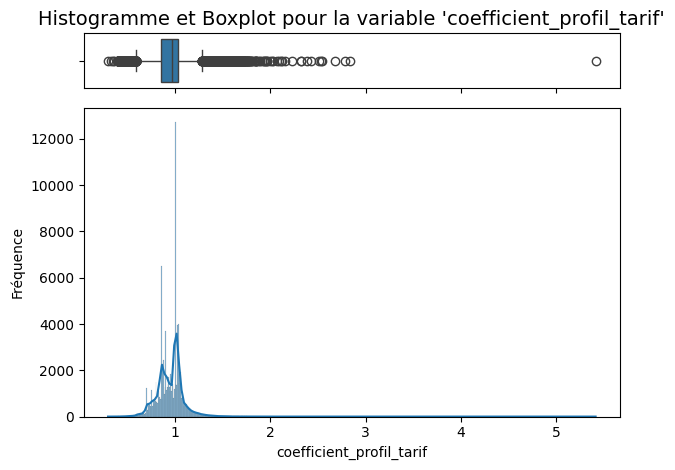

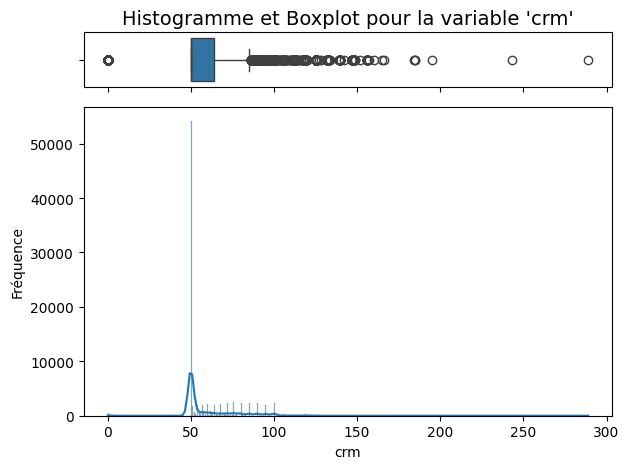

In [176]:
for var in var_num_graph :
    hist_box(df, var)

⚠️ ATTENTION : 
---
Il ne semble pas y avoir d'anomalies 

### 2.2.2 Analyse et traiment des anomalies :

## 2.3 Variables catégorielles : 

In [177]:
# Mettre le bon type à certaines variables qui ne l'étaient pas :
df[['motif_resiliation', 'code_csp', 'code_usage_auto']] = df[['motif_resiliation', 'code_csp', 'code_usage_auto']].astype('object')

In [178]:
var_cat = df.select_dtypes(include=['object']).columns.tolist()
var_cat.remove('contrat')
var_cat

['code_usage_auto',
 'code_agent',
 'code_formule',
 'code_produit_gestion',
 'code_marque_vehicule',
 'libelle_modele_vehicule',
 'numero_tarif',
 'puissance_fiscale',
 'code_marche',
 'code_csp',
 'sexe',
 'situation_familiale',
 'departement',
 'region',
 'client_actif',
 'etat',
 'motif_resiliation']

### 2.3.1 Création de variables :

In [179]:
df[var_cat].nunique().reset_index().rename(columns={'index':'Champ',0:'Nb_Distinct_Values'})\
                .sort_values('Nb_Distinct_Values',ascending=False)

Champ  Nb_Distinct_Values
5   libelle_modele_vehicule                6806
1                code_agent                1255
4      code_marque_vehicule                 256
9                  code_csp                 234
12              departement                 196
0           code_usage_auto                  71
2              code_formule                  25
6              numero_tarif                  17
16        motif_resiliation                  15
7         puissance_fiscale                  14
13                   region                  11
11      situation_familiale                   7
3      code_produit_gestion                   6
15                     etat                   4
10                     sexe                   2
14             client_actif                   2
8               code_marche                   2

On constate que beaucoup de variable ont enormement de modalité. Meme si par la suite nous allons appliquer un target encoding sur les variables à plus de 5 ou 10 modalité, il est prefabable de reduire les modalités pour reduitrte le bruit.

* **libelle_modele_vehicule :**

La distribution est assez etalée pour pour voir établie un top. Il y a deux options : 
1. Soit garder le TOP 100 + "AUTRE"
2. Soit 3 groupes par fréquence : Très répandues (ex. : RENAULT, PEUGEOT, CITROEN), Moyennement répandues (ex. : FORD à HONDA), Peu fréquentes (toutes les autres → 'autres')

1.

In [180]:
def graph_barre(df, col):
    plt.figure(figsize=(8,4))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette='viridis')
    plt.title(f'Distribution de {col}')
    plt.xlabel('Nombre d\'observations')
    plt.ylabel(col)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_35803/3490033282.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette='viridis')


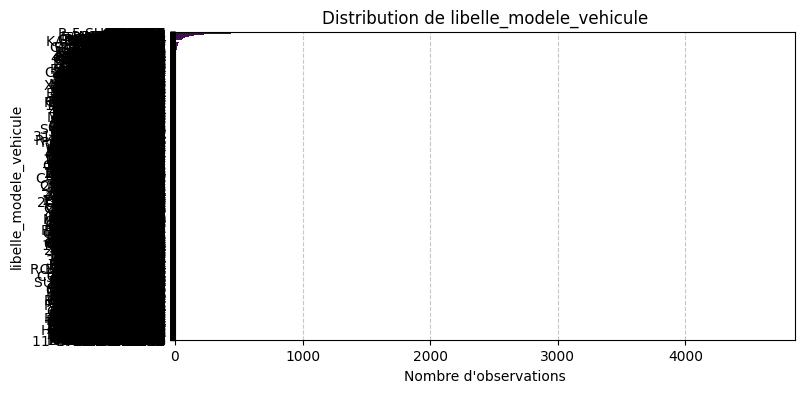

In [181]:
graph_barre(df, "libelle_modele_vehicule")

In [182]:
df['libelle_modele_vehicule'].value_counts().head(20)

libelle_modele_vehicule
205              4626
CLIO             4478
R 5 SUPERCINQ    2539
R19              2152
306              2141
405              2050
106              2043
R21              1970
GOLF             1961
AX               1909
FIESTA           1897
MEGANE           1675
CORSA            1626
TWINGO           1515
BX               1473
ZX               1327
309              1270
EXPRESS          1249
ESCORT           1224
POLO             1139
Name: count, dtype: int64

In [183]:
top_n = 75
top_models = df['libelle_modele_vehicule'].value_counts().nlargest(top_n)
autres = df['libelle_modele_vehicule'].value_counts().sum() - top_models.sum()
print(f"Part des top {top_n} modèles : {top_models.sum() / len(df):.2%}")


Part des top 75 modèles : 70.43%


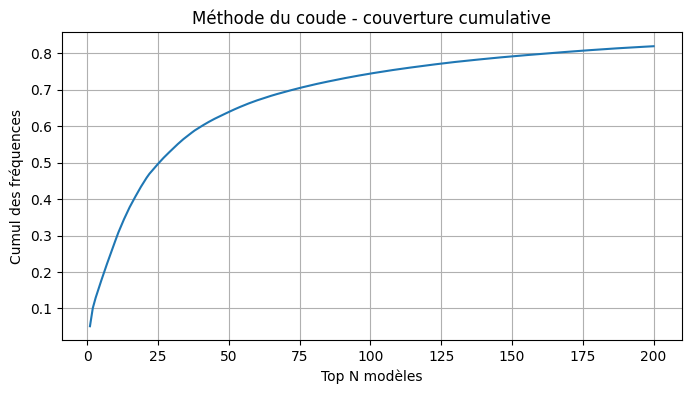

In [184]:
vc = df['libelle_modele_vehicule'].value_counts()
cumulative = vc.cumsum() / vc.sum()

plt.figure(figsize=(8, 4))
plt.plot(range(1, 201), cumulative.iloc[:200])
plt.xlabel("Top N modèles")
plt.ylabel("Cumul des fréquences")
plt.title("Méthode du coude - couverture cumulative")
plt.grid(True)
plt.show()


On constate que :
- la pente est très forte jusqu’à environ TOP 20–30
- stabilité vers TOP 70–100
- n'augmente pas enormement apres

Nous avons donc choisi le TOP 100. C’est le point optimal selon la courbe du coude : on garde 74% de l’info avec 100 modalités (vs. 6806 au départ).

In [185]:
top_100 = df['libelle_modele_vehicule'].value_counts().nlargest(100).index
df['libelle_modele_vehicule_groupe_1'] = df['libelle_modele_vehicule'].apply(
    lambda x: x if x in top_100 else 'AUTRES'
)

2.

In [186]:
modele_freq = df['libelle_modele_vehicule'].value_counts()
modele_freq.describe(percentiles=[.25, .5, .75, .9, .95])

count    6806.000000
mean       13.243756
std       127.610559
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
90%         7.000000
95%        19.000000
max      4626.000000
Name: count, dtype: float64

Au vu de la distribution nous avons décidé de créer 2 clases.

In [187]:
def classer_modele(freq):
    if freq >= 100:
        return 'tres_repandu'
    else:
        return 'rare'

df['libelle_modele_vehicule_groupe_2'] = df['libelle_modele_vehicule'].map(lambda x: classer_modele(modele_freq.get(x, 0)))


* **Code_agent :**

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_35803/3490033282.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette='viridis')


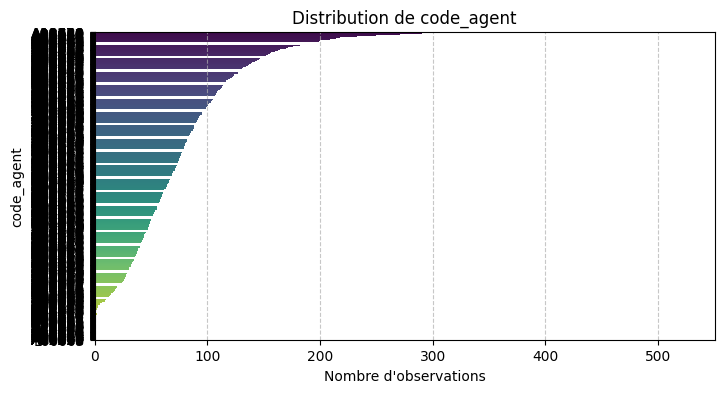

In [188]:
graph_barre(df, "code_agent")

De part la distribution beaucoup plus etalée que la variable précedante. Il nous a paru plus pertinent ici de decouper en fonction de la distribution.

In [189]:
agent_freq = df['code_agent'].value_counts()
agent_freq.describe(percentiles=[.25, .5, .75, .9, .95])

count    1255.000000
mean       71.909960
std        57.282526
min         1.000000
25%        33.000000
50%        64.000000
75%        98.500000
90%       140.000000
95%       174.000000
max       524.000000
Name: count, dtype: float64

In [190]:
agent_freq = df['code_agent'].value_counts()

def classer_agent(agent):
    freq = agent_freq.get(agent, 0)
    if freq < 33:
        return 'rare'
    elif freq <= 64:
        return 'moyen_faible'
    elif freq <= 98:
        return 'moyen_fort'
    else:
        return 'tres_repandu'

df['code_agent_groupe'] = df['code_agent'].map(classer_agent)


* **Code_formule :**

Pour cette variable on voit clairement que 6 modalitées sont domminantes. Nous allons donc regrouper les modalités à moins de 2000 apparition dans une modalité "AUTRES".

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_35803/3490033282.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette='viridis')


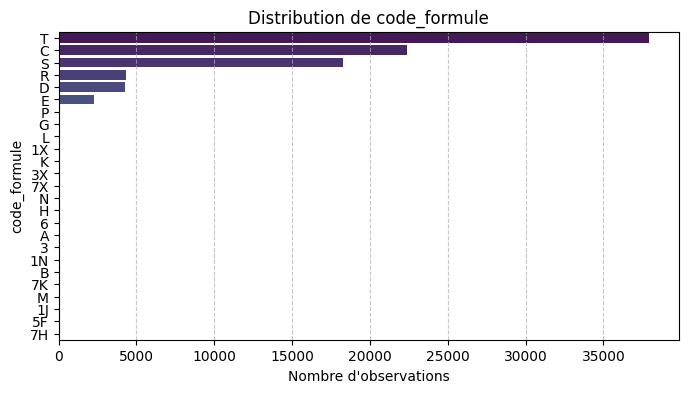

In [191]:
graph_barre(df, "code_formule")

In [192]:
df['code_formule'].value_counts().head(30)

code_formule
T     37944
C     22404
S     18289
R      4336
D      4271
E      2242
P        54
G        33
L        26
1X       22
K        16
3X       12
7X       12
N        11
H         9
6         5
A         5
3         2
1N        2
B         2
7K        1
M         1
1J        1
5F        1
7H        1
Name: count, dtype: int64

In [193]:
freq = df['code_formule'].value_counts()
modalites_frequentes = freq[freq >= 2000].index.tolist()

def grp(x):
    if x in modalites_frequentes:
        return x
    else:
        return 'AUTRES'

df['code_formule_groupe'] = df['code_formule'].map(grp)


In [194]:
df['code_formule_groupe'].value_counts()

code_formule_groupe
T         37944
C         22404
S         18289
R          4336
D          4271
E          2242
AUTRES      761
Name: count, dtype: int64

* **code_produit_gestion :**

On remarque directemnt qu'on peut créer 2 modalités pour cette variable.

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_35803/3490033282.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette='viridis')


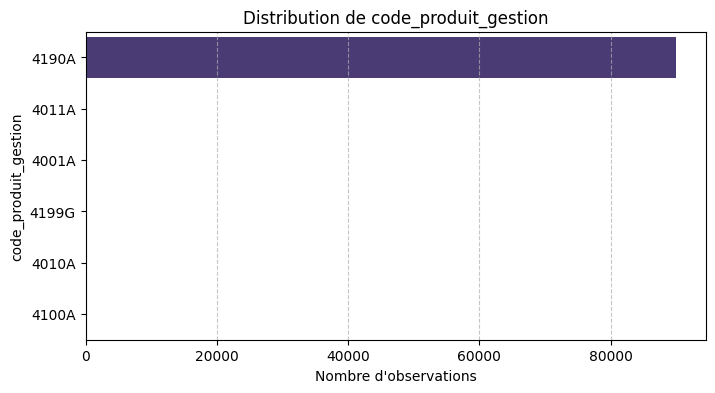

In [195]:
graph_barre(df, "code_produit_gestion")

In [196]:
df["code_produit_gestion"].value_counts()

code_produit_gestion
4190A    89973
4011A      149
4001A       60
4199G       31
4010A       20
4100A       14
Name: count, dtype: int64

In [197]:
freq = df['code_produit_gestion'].value_counts()
modalites_frequentes = freq[freq >= 2000].index.tolist()

In [198]:
df['code_produit_gestion_groupe'] = df['code_produit_gestion'].map(grp)

In [199]:
df['code_produit_gestion_groupe'].value_counts()

code_produit_gestion_groupe
4190A     89973
AUTRES      274
Name: count, dtype: int64

* **code_marque_vehicule :**

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_35803/3490033282.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette='viridis')


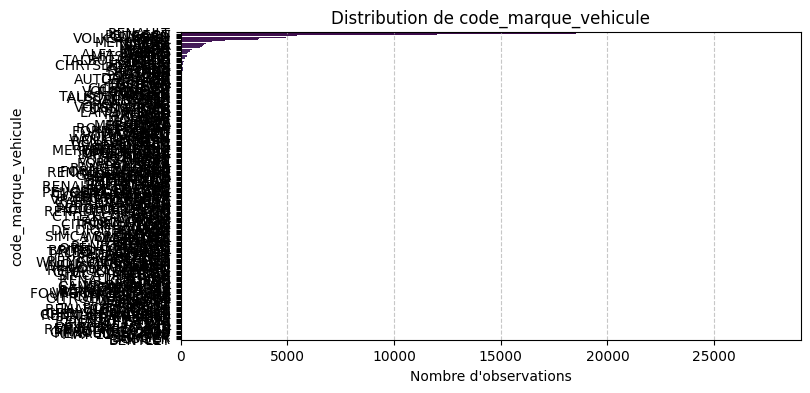

In [200]:
graph_barre(df, "code_marque_vehicule")

In [201]:
df["code_marque_vehicule"].value_counts().head(30)

code_marque_vehicule
RENAULT           27666
PEUGEOT           18527
CITROEN           12011
FORD               5465
VOLKSWAGEN         4952
OPEL               3695
FIAT               3626
MERCEDES           2087
B.M.W.             1482
NISSAN             1174
TOYOTA             1092
AUDI               1075
SEAT               1014
ROVER               913
HONDA               541
MAZDA               450
VOLVO               434
ALFA ROMEO          343
AUSTIN              318
MITSUBISHI          298
LANCIA              294
LADA                220
TALBOT(SIMCA)       195
IVECO               171
SUZUKI              157
HYUNDAI             135
CHRYSLER (USA)      130
SKODA               126
PORSCHE             125
JEEP                123
Name: count, dtype: int64

In [202]:
top_n = 15
top_models = df['code_marque_vehicule'].value_counts().nlargest(top_n)
autres = df['code_marque_vehicule'].value_counts().sum() - top_models.sum()
print(f"Part des top {top_n} modèles : {top_models.sum() / len(df):.2%}")

Part des top 15 modèles : 94.54%


On remarque directement qu'il y a 15 modalité qui domine. Il y a deux options : 
- Soit garder le TOP 15 + "AUTRE"
- Soit 3 groupes par fréquence : Très répandues (ex. : RENAULT, PEUGEOT, CITROEN), Moyennement répandues (ex. : FORD à HONDA), Peu fréquentes (toutes les autres → 'autres')

In [203]:
# Méthode 1 : 
top_15 = df['code_marque_vehicule'].value_counts().nlargest(15).index
df['code_marque_vehicule_groupe_2'] = df['code_marque_vehicule'].apply(
    lambda x: x if x in top_15 else 'AUTRES'
)

In [204]:
# Méthode 2 :

def regrouper_marque(marque):
    if marque in ['RENAULT', 'PEUGEOT', 'CITROEN']:
        return 'tres_repandue'
    elif marque in ['FORD', 'VOLKSWAGEN', 'OPEL', 'FIAT', 'MERCEDES',
                    'B.M.W.', 'NISSAN', 'TOYOTA', 'AUDI', 'SEAT', 'ROVER', 'HONDA']:
        return 'moyenne'
    else:
        return 'rare'

df['code_marque_vehicule_groupe_1'] = df['code_marque_vehicule'].map(regrouper_marque)


* **numero_tarif :**

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_35803/3490033282.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette='viridis')


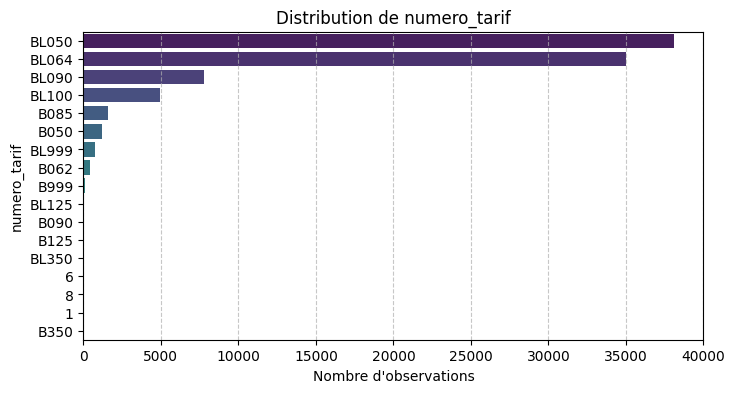

In [205]:
graph_barre(df, "numero_tarif")

On voit qu'il y a 3 groupes : 
- Très courant : les 2 modalités majoritaires (BL050, BL064)
- Modérément courant : celles entre ~1000 et 8000
- Rare : tout le reste

In [206]:
df["numero_tarif"].value_counts()

numero_tarif
BL050    38096
BL064    35022
BL090     7752
BL100     4972
B085      1565
B050      1199
BL999      753
B062       419
B999        87
BL125       48
B090        31
B125        15
BL350       10
6            4
8            3
1            3
B350         1
Name: count, dtype: int64

In [207]:
tarif_freq = df['numero_tarif'].value_counts()

def regrouper_tarif(x):
    freq = tarif_freq.get(x, 0)
    if x in ['BL050', 'BL064']:
        return 'tres_courant'
    elif freq >= 1000:
        return 'modere'
    else:
        return 'rare'

df['numero_tarif_groupe'] = df['numero_tarif'].map(regrouper_tarif)


* **Code_csp :**

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_35803/3490033282.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette='viridis')


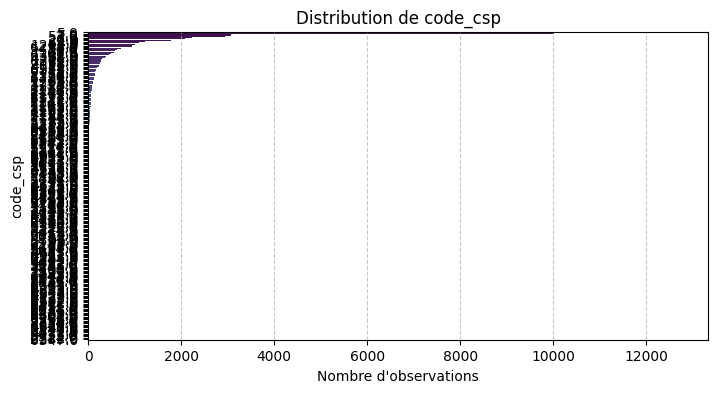

In [208]:
graph_barre(df, "code_csp")

In [209]:
df["code_csp"].value_counts().head(50)

code_csp
5.0       12697
7.0       10019
52.0       3078
1.0        2936
6.0        2237
21.0       2086
22.0       1787
64.0       1214
4.0        1090
1201.0     1004
6238.0      954
54.0        950
5411.0      716
31.0        617
37.0        574
69.0        562
6341.0      487
84.0        451
38.0        382
4311.0      365
1204.0      303
6311.0      288
55.0        275
2154.0      258
2156.0      250
4611.0      238
71.0        235
6354.0      201
6515.0      180
8.0         173
2151.0      155
72.0        154
3116.0      150
2221.0      148
6792.0      132
3.0         126
53.0        121
1203.0      114
3733.0      108
23.0        100
2222.0       93
2.0          86
3128.0       83
2213.0       81
2101.0       79
2242.0       70
2171.0       66
2162.0       65
2172.0       64
3727.0       62
Name: count, dtype: int64

In [210]:
top_n = 10
top_models = df['code_csp'].value_counts().nlargest(top_n)
autres = df['code_csp'].value_counts().sum() - top_models.sum()
print(f"Part des top {top_n} modèles : {top_models.sum() / len(df):.2%}")


Part des top 10 modèles : 42.27%


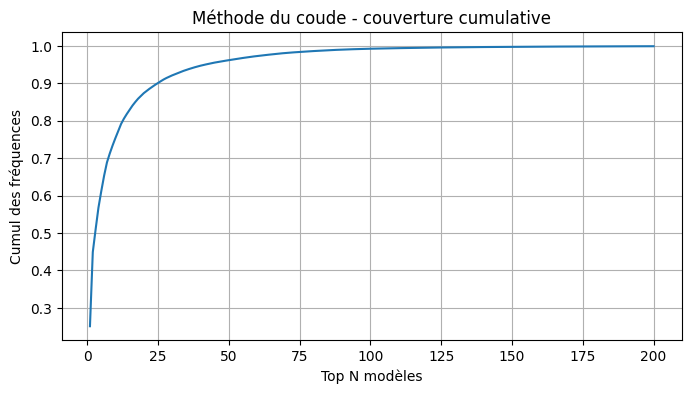

In [211]:
vc = df['code_csp'].value_counts()
cumulative = vc.cumsum() / vc.sum()

plt.figure(figsize=(8, 4))
plt.plot(range(1, 201), cumulative.iloc[:200])
plt.xlabel("Top N modèles")
plt.ylabel("Cumul des fréquences")
plt.title("Méthode du coude - couverture cumulative")
plt.grid(True)
plt.show()


La distribution est assez etalée pour pour voir établie un top. Il y a deux options : 
1. Soit garder le TOP 25 + "AUTRE"
2. Soit 3 groupes par fréquence : Très répandues (ex. : RENAULT, PEUGEOT, CITROEN), Moyennement répandues (ex. : FORD à HONDA), Peu fréquentes (toutes les autres → 'autres')

1.

In [212]:
top_25 = df['code_csp'].value_counts().nlargest(25).index
df['code_csp_groupe_1'] = df['code_csp'].apply(
    lambda x: x if x in top_25 else 'AUTRES'
)

2.

In [213]:
csp_freq = df['code_csp'].value_counts()

def regrouper_csp(code):
    freq = csp_freq.get(code, 0)
    if freq >= 1000:
        return 'tres_courant'
    elif freq >= 200:
        return 'modere'
    else:
        return 'rare'

df['code_csp_groupe_2'] = df['code_csp'].map(regrouper_csp)

* **situation_familiale :**

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_35803/3490033282.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette='viridis')


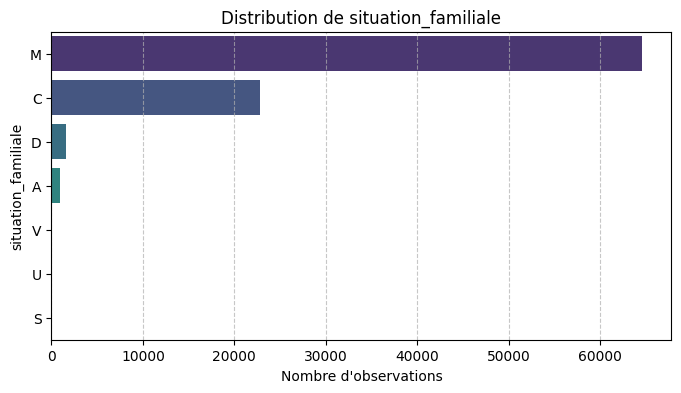

In [214]:
graph_barre(df, "situation_familiale")

In [215]:
df["situation_familiale"].value_counts()

situation_familiale
M    64552
C    22780
D     1623
A      918
V       11
U        2
S        1
Name: count, dtype: int64

On constate que Lon peut simplement diviser cette variable en deux modalités : les mariés et les célibataires

In [216]:
df['situation_familiale_binaire'] = df['situation_familiale'].apply(
    lambda x: 'marie' if x == 'M' else 'non_marie'
)

* **region :**

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_35803/3490033282.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette='viridis')


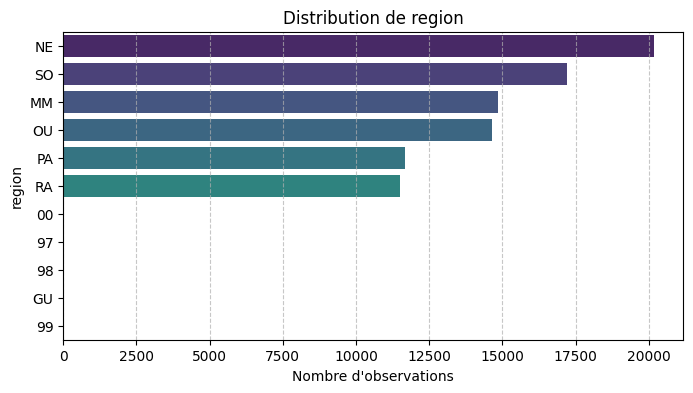

In [217]:
graph_barre(df, "region")

On a décidé de laisse les modalité sur les regions de la france metropolitaine inchangées au vu de leur nombre de modalité. Nous allons regrouper les region DOM-TOM ensemble et le reste en autre.

In [218]:
df["region"].value_counts()

region
NE    20170
SO    17207
MM    14847
OU    14640
PA    11656
RA    11490
00       16
97       15
98        5
GU        1
99        1
Name: count, dtype: int64

In [ ]:
def recoder_region(code):
    if code in ['NE', 'SO', 'MM', 'OU', 'PA', 'RA']:
        return code
    elif code in ['97', '98', 'GU']:
        return 'DOM_TOM'
    else:
        return 'autre'

df['region_groupe'] = df['region'].apply(recoder_region)

* **Département :**

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_35803/3490033282.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette='viridis')


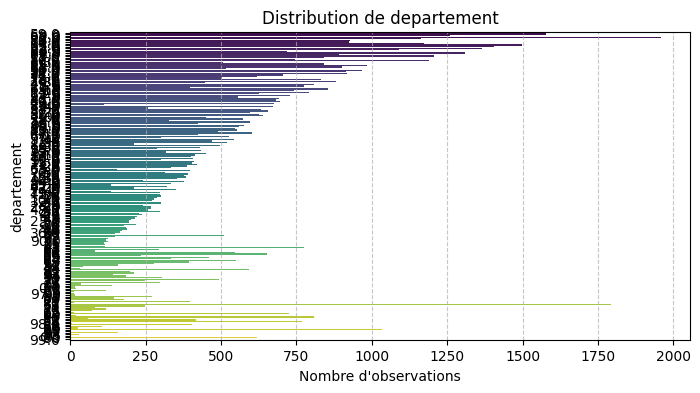

In [220]:
graph_barre(df, "departement")

Nous avons decidé ne pas recoder cette variable puisque nous avons la variable region_groupe qui apportera la meme information.

In [221]:
df['departement'].value_counts()

departement
59.0    3374
60.0    2295
62.0    2288
6.0     2007
83.0    1837
        ... 
55         1
88         1
GU         1
80         1
99.0       1
Name: count, Length: 196, dtype: int64

* **etat :**

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_35803/3490033282.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette='viridis')


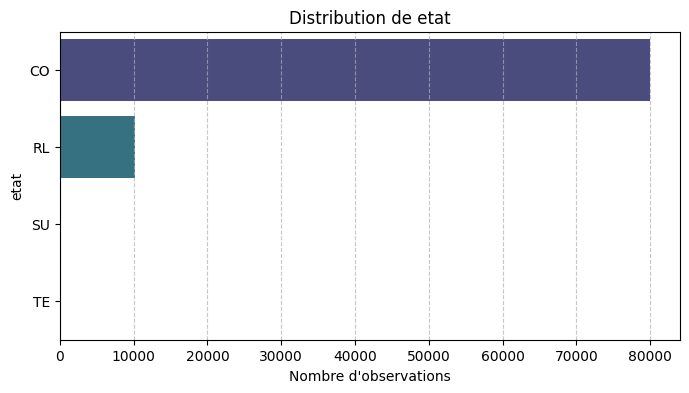

In [222]:
graph_barre(df, "etat")

Cette variable semble fourmir la meme information que notre variable cible contrat . De plus elles ont le meme nombre de valeurs manquantes.

In [223]:
df['etat'].value_counts()

etat
CO    80031
RL    10170
SU       43
TE        3
Name: count, dtype: int64

In [224]:
def recoder_etat(x):
    if x == 'CO':
        return 'ACTIF'
    else:
        return 'RESIL'

df['etat_groupe'] = df['etat'].apply(recoder_etat)


In [225]:
df[(df["contrat"] == "RESIL") & (df["etat_groupe"] == "ACTIF")].shape[0] 

22

In [226]:
df[(df["contrat"] == "ACTIF") & (df["etat_groupe"] == "RESIL")].shape[0]

108

⚠️ ATTTENTION : 
---
Qu'elle est la cible au final ?

In [227]:
# Solution :
# - soit supprimer etat car tres peux de variables ou on a une difference entre les deux
# - soit faire un melange des deux : 
# def cible_finale(row):
#     if row['contrat'] == row['etat_groupe']:
#         return row['contrat']
#     elif row['etat_groupe'] == 'ACTIF' and row['contrat'] == 'RESIL':
#         return 'RESIL'  # Prendre le plus pessimiste
#     elif row['etat_groupe'] == 'RESIL' and row['contrat'] == 'ACTIF':
#         return 'RESIL'  # Aussi résilié, on se protège
#     else:
#         return 'INDEFINI'

# df['statut_contrat_final'] = df.apply(cible_finale, axis=1)

* **motif_resiliation :**

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_35803/3490033282.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette='viridis')


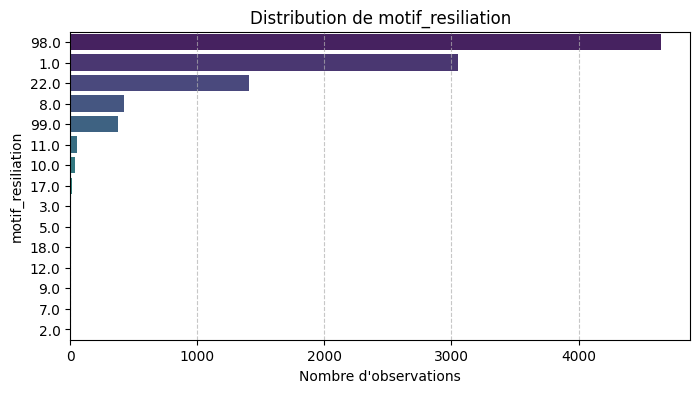

In [228]:
graph_barre(df, "motif_resiliation")

In [229]:
df["motif_resiliation"].value_counts()

motif_resiliation
98.0    4647
1.0     3048
22.0    1407
8.0      420
99.0     376
11.0      54
10.0      39
17.0      17
3.0        7
5.0        6
18.0       5
12.0       3
9.0        2
7.0        1
2.0        1
Name: count, dtype: int64

Il faudrait demander au prof à quoi correspond les motifs.

In [230]:
#Sinon, on peut faire un regroupement par fréquence :
def recoder_motif(x):
    if x == 98.0:
        return "motif_majoritaire_1"
    elif x == 1.0:
        return "motif_majoritaire_2"
    elif x in [22.0, 8.0, 99.0]:
        return "motif_frequent"
    else:
        return "motif_rare"

df['motif_resiliation_groupe'] = df['motif_resiliation'].apply(recoder_motif)


### 2.3.2 Analyse :

In [233]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90247 entries, 0 to 90246
Data columns (total 81 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   code_usage_auto                   90231 non-null  object        
 1   code_agent                        90247 non-null  object        
 2   code_formule                      89702 non-null  object        
 3   code_produit_gestion              90247 non-null  object        
 4   date_debut_contrat                90247 non-null  int64         
 5   date_dernier_mouvement            90247 non-null  int64         
 6   echeance_contrat                  90231 non-null  float64       
 7   prime_annuelle_ttc                90247 non-null  float64       
 8   code_marque_vehicule              90160 non-null  object        
 9   date_obtention_permis             90054 non-null  float64       
 10  date_mise_circulation             89315 non-nu

In [235]:
var_cat_add = [
"libelle_modele_vehicule_groupe_1", 
"libelle_modele_vehicule_groupe_2", 
"code_agent_groupe", 
"code_formule_groupe", 
"code_produit_gestion_groupe",
"code_marque_vehicule_groupe_2",
"code_marque_vehicule_groupe_1",
"numero_tarif_groupe",
"code_csp_groupe_1",
"code_csp_groupe_2",
"situation_familiale_binaire",
"region_groupe",
"etat_groupe",
"motif_resiliation_groupe"]

In [236]:
var_cat

['code_usage_auto',
 'code_agent',
 'code_formule',
 'code_produit_gestion',
 'code_marque_vehicule',
 'libelle_modele_vehicule',
 'numero_tarif',
 'puissance_fiscale',
 'code_marche',
 'code_csp',
 'sexe',
 'situation_familiale',
 'departement',
 'region',
 'client_actif',
 'etat',
 'motif_resiliation']

In [237]:
var_cat_graph = var_cat + var_cat_add

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_35803/3490033282.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette='viridis')


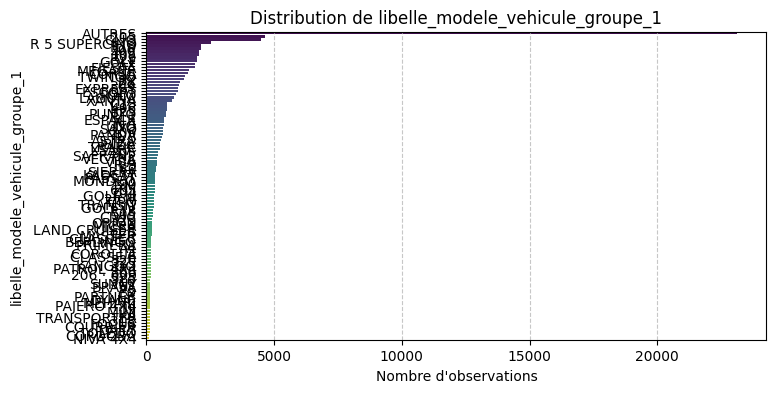

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_35803/3490033282.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette='viridis')


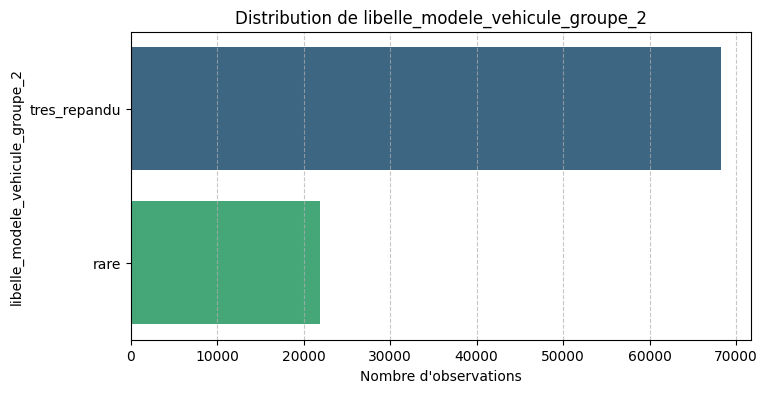

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_35803/3490033282.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette='viridis')


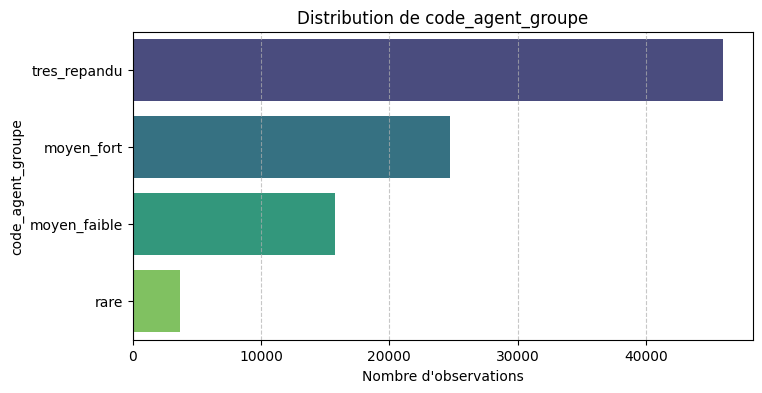

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_35803/3490033282.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette='viridis')


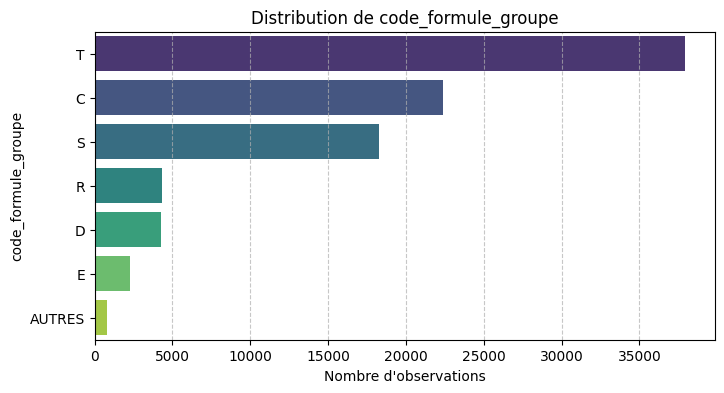

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_35803/3490033282.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette='viridis')


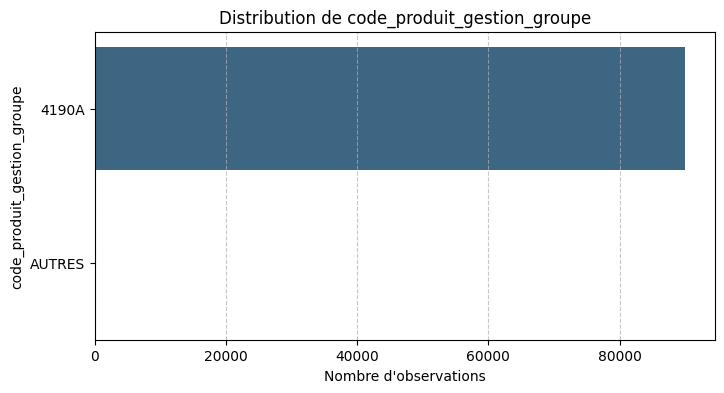

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_35803/3490033282.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette='viridis')


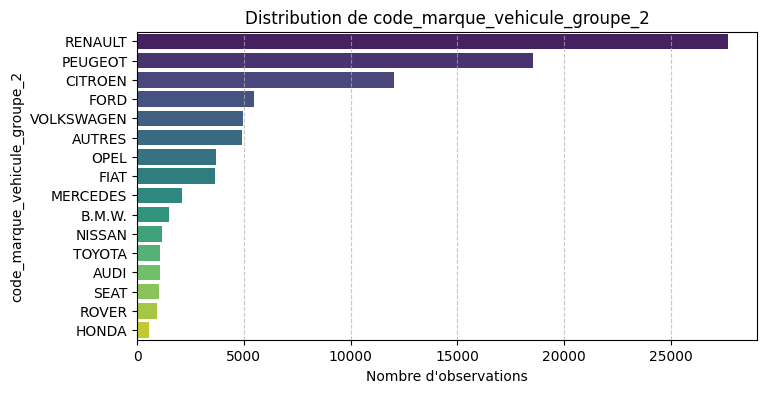

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_35803/3490033282.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette='viridis')


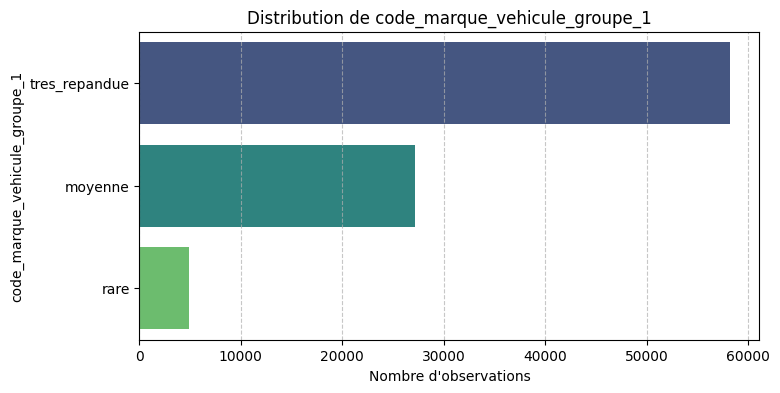

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_35803/3490033282.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette='viridis')


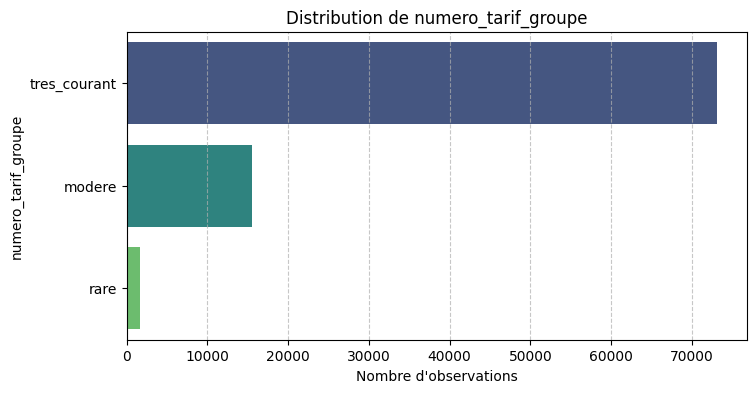

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_35803/3490033282.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette='viridis')


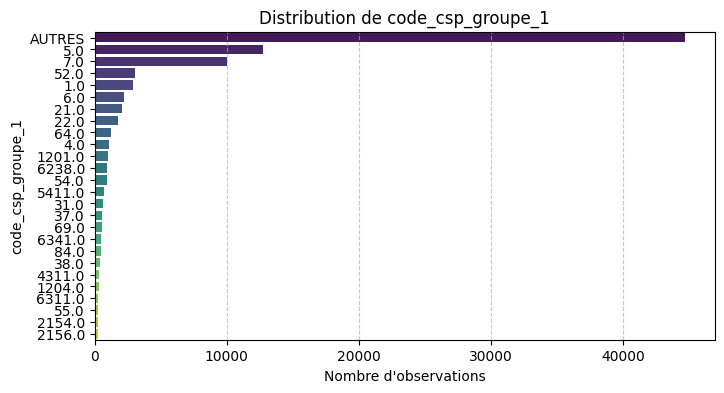

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_35803/3490033282.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette='viridis')


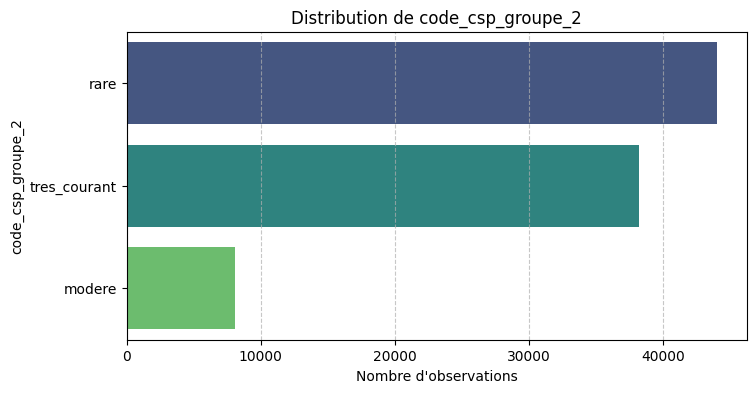

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_35803/3490033282.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette='viridis')


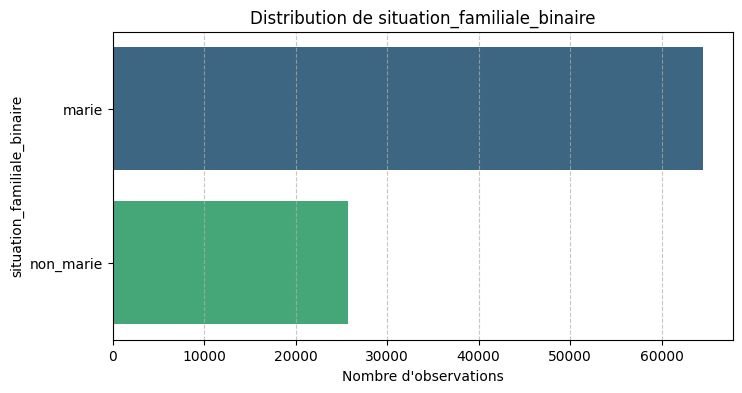

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_35803/3490033282.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette='viridis')


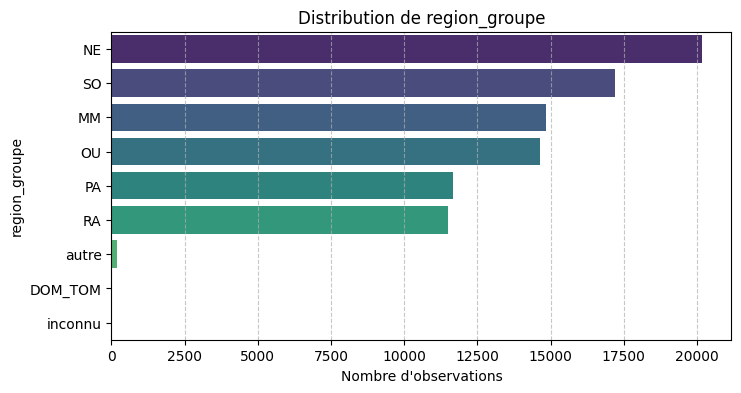

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_35803/3490033282.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette='viridis')


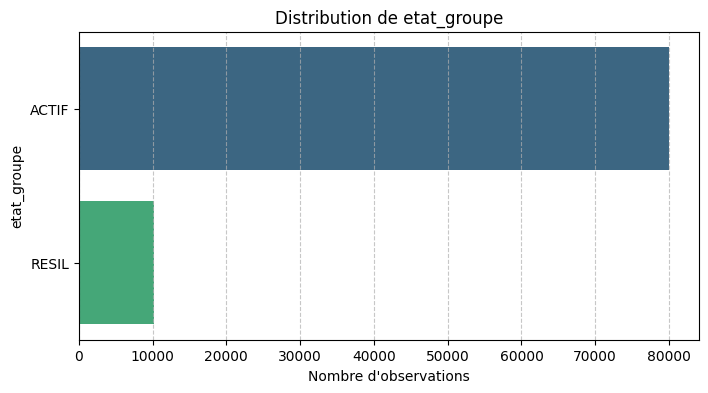

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_35803/3490033282.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette='viridis')


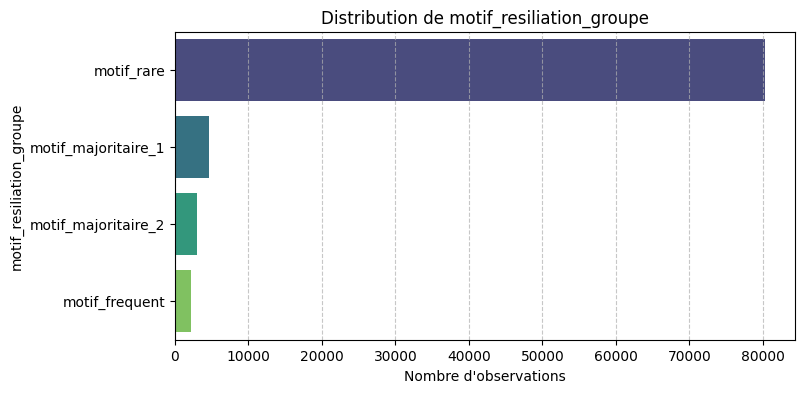

In [239]:
for col in var_cat_add:
    graph_barre(df, col)

## 2.4 Representation graphique de chaque variable en fonction de la variable cible 

### 2.4.1 Représentations graphiques des catégorielles par rapport à la cible

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


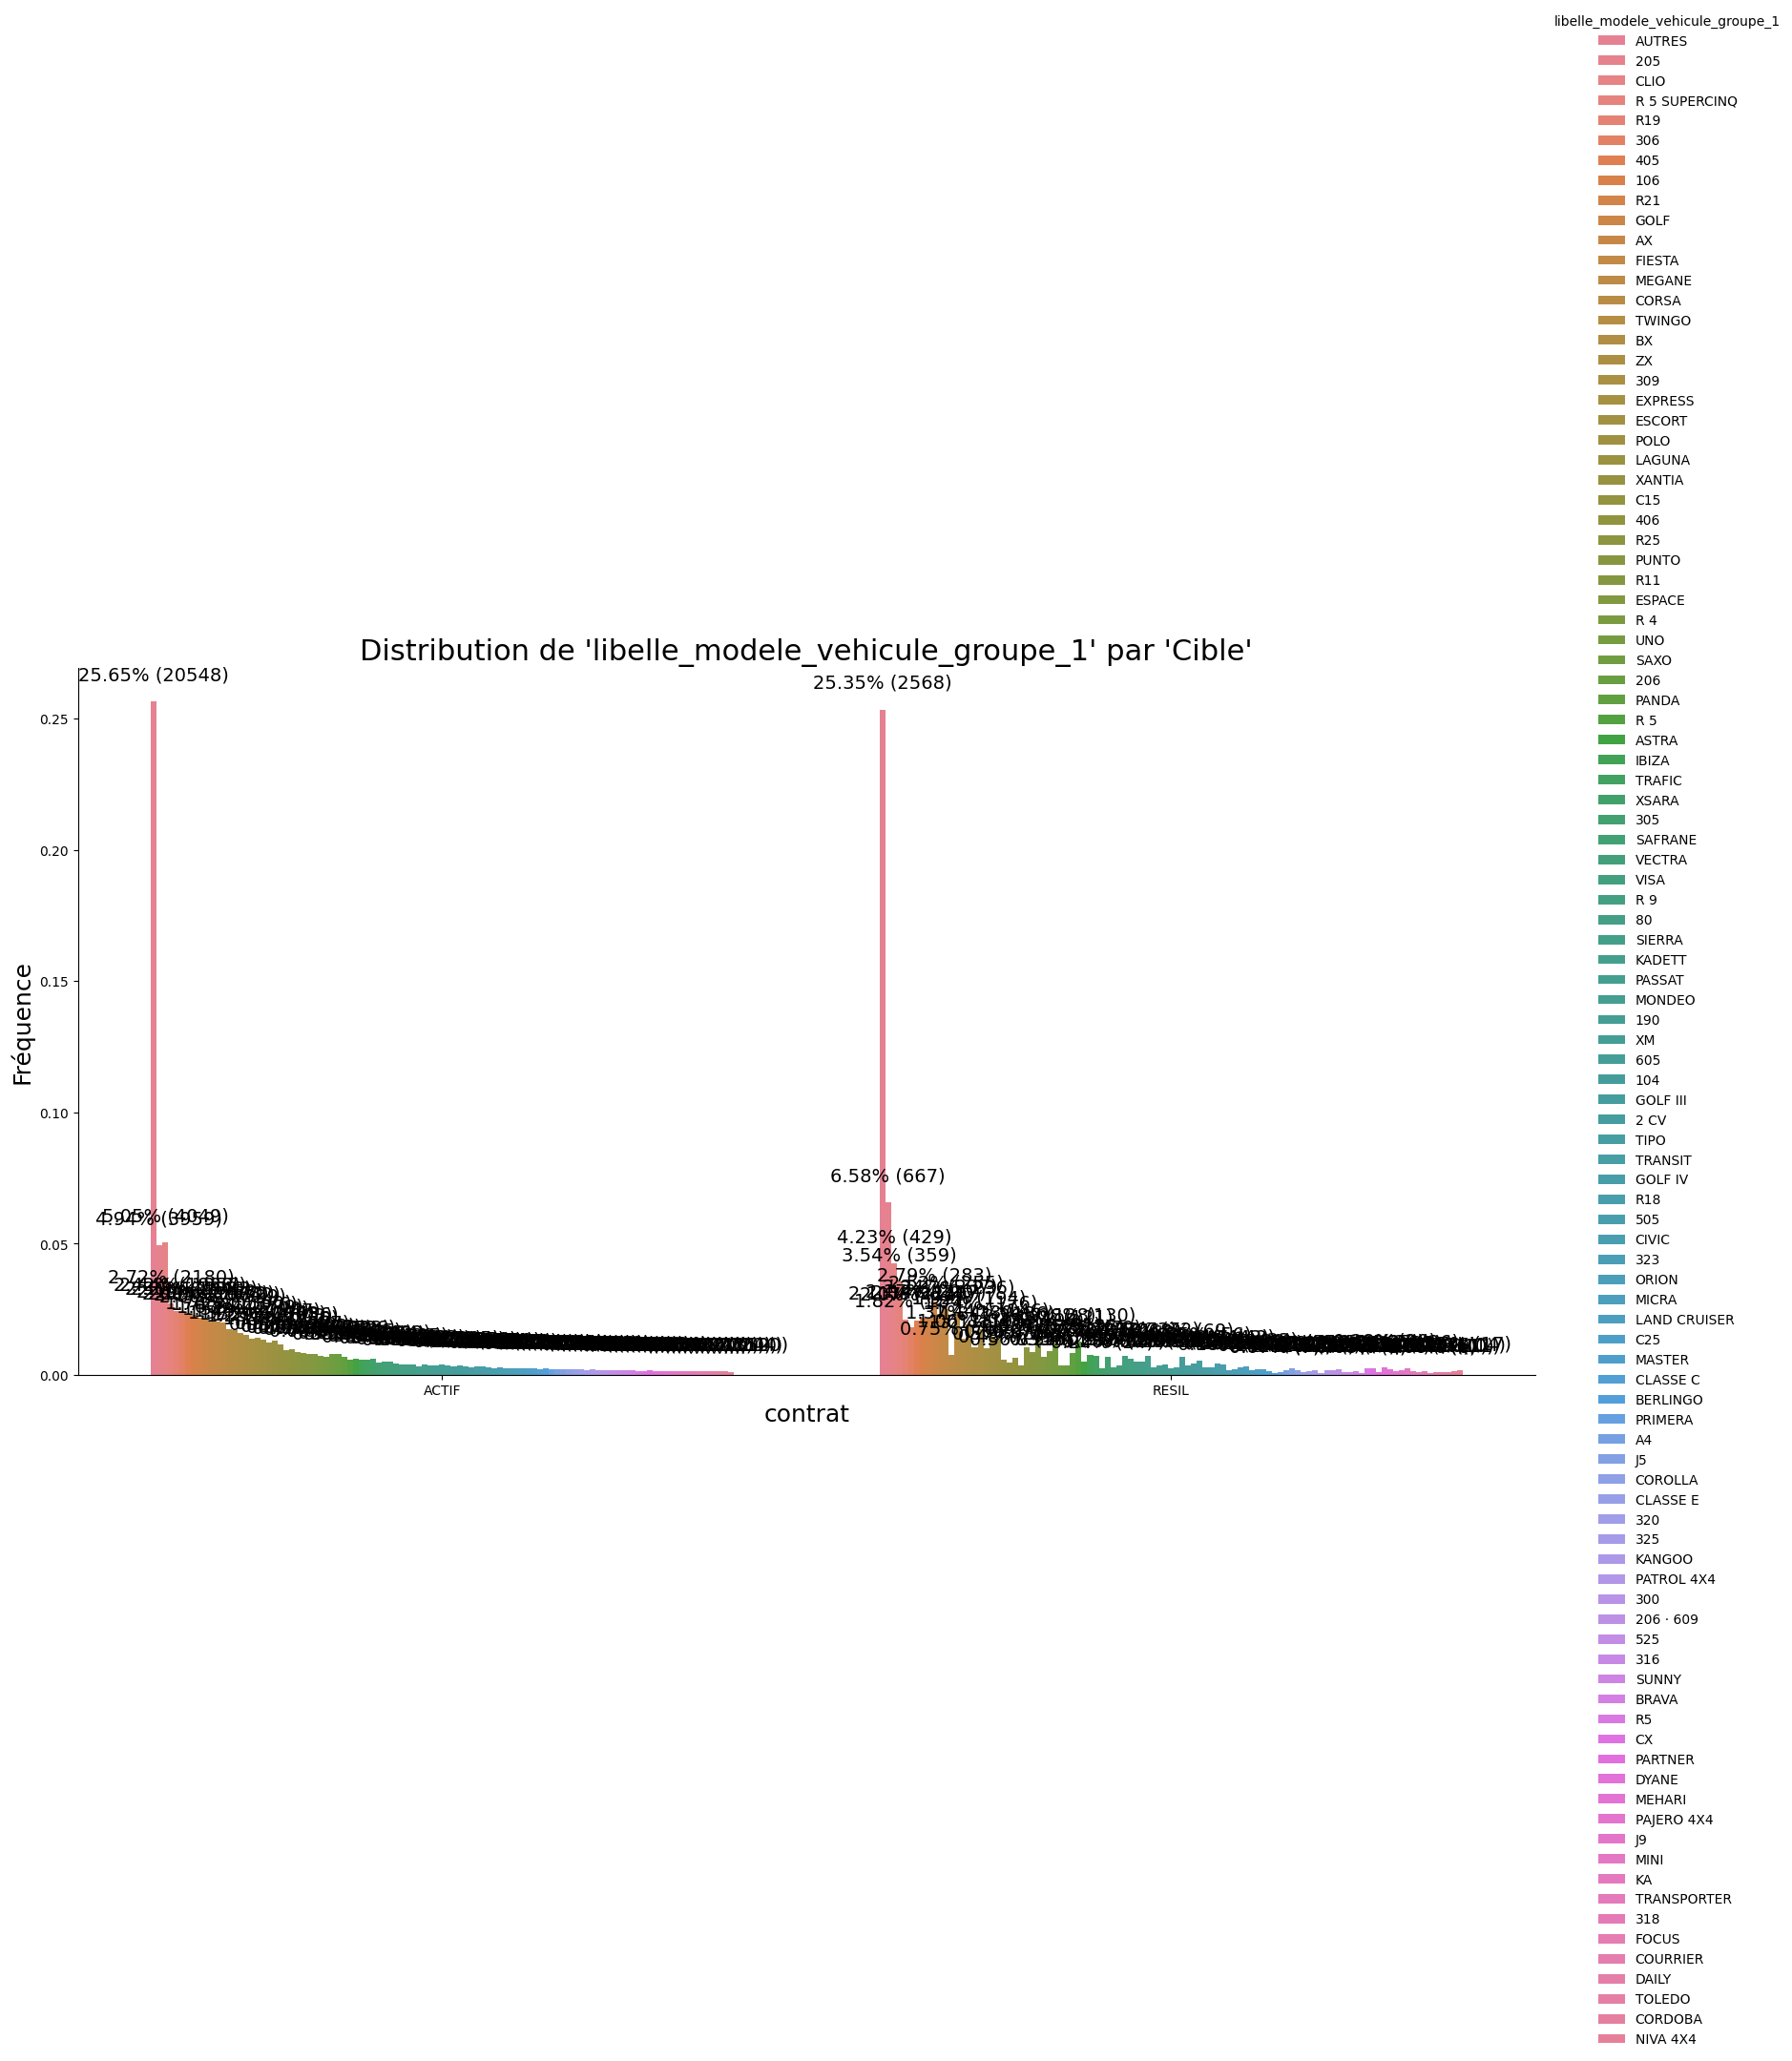

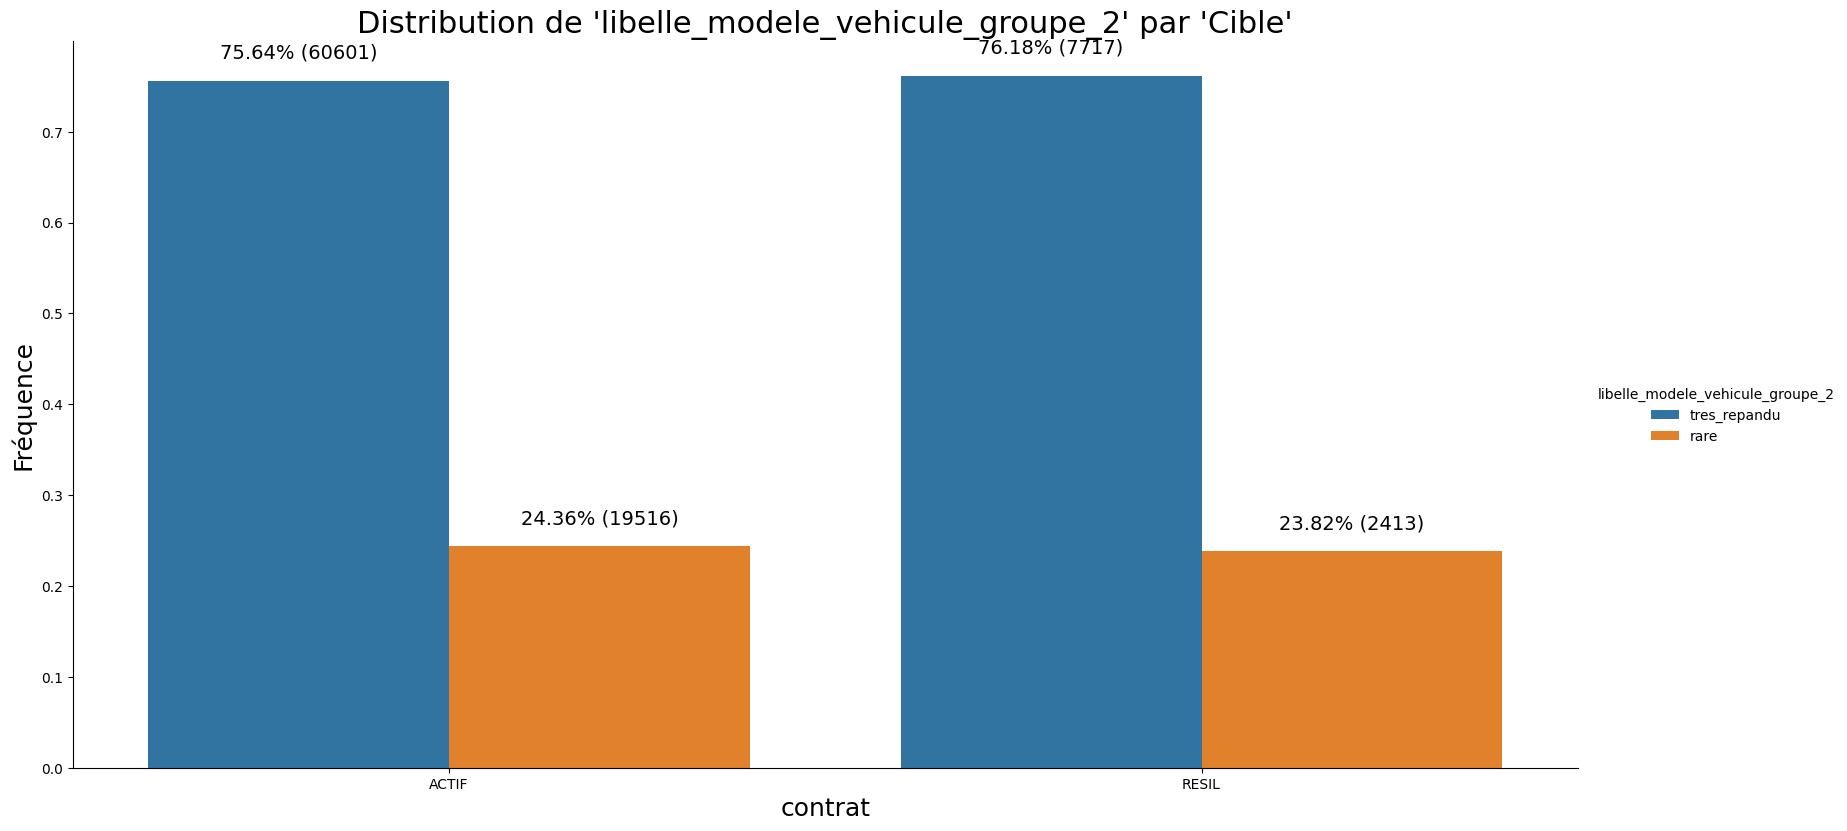

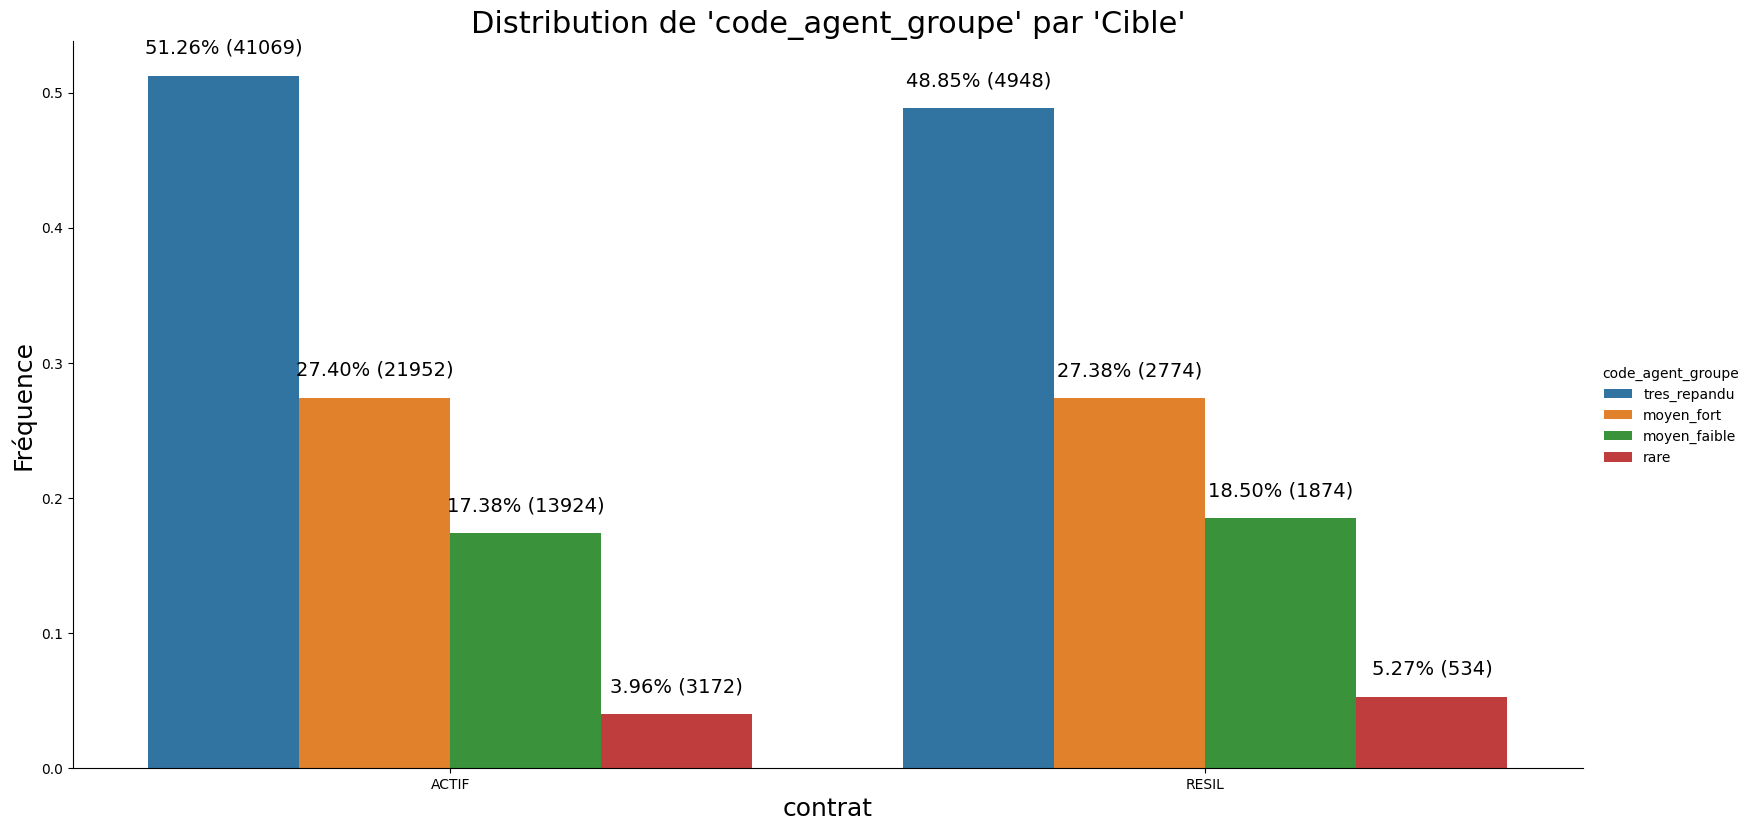

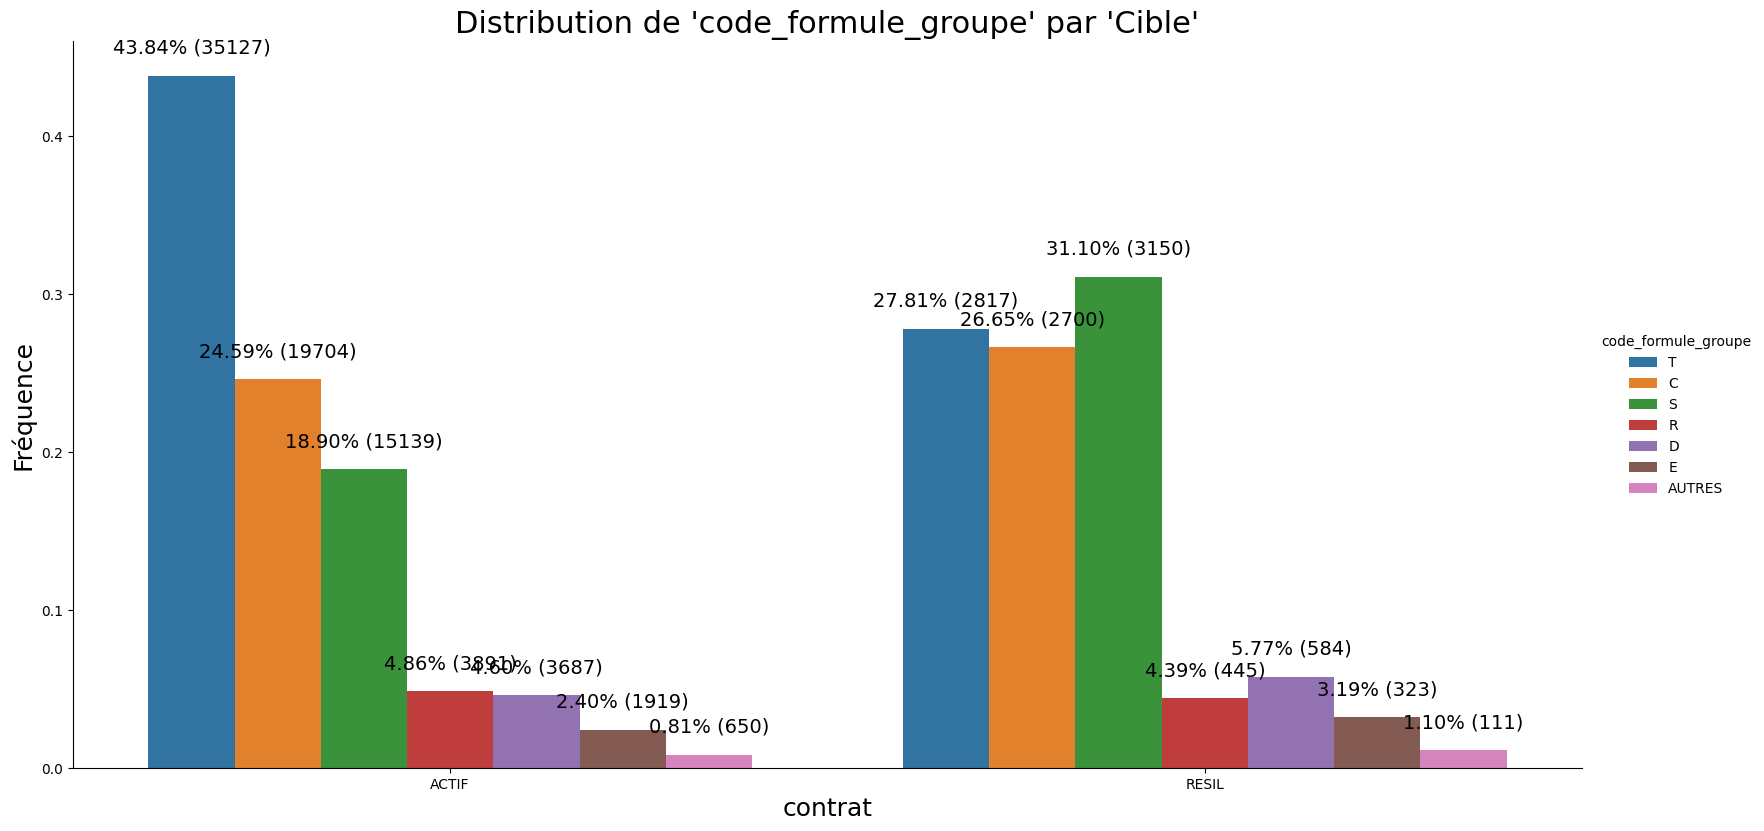

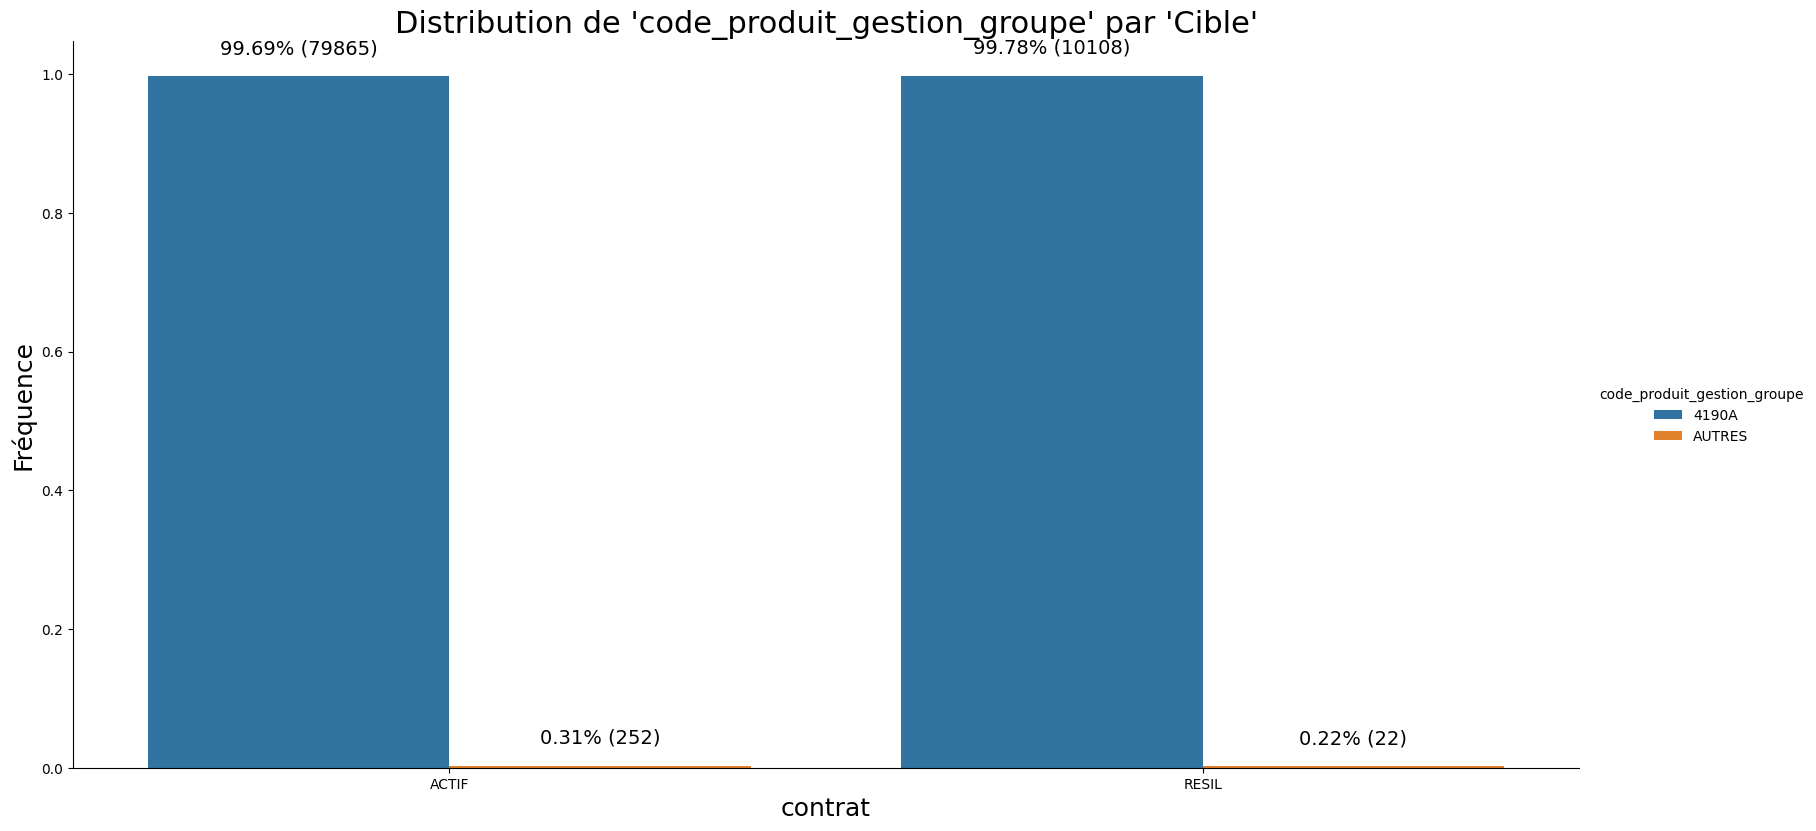

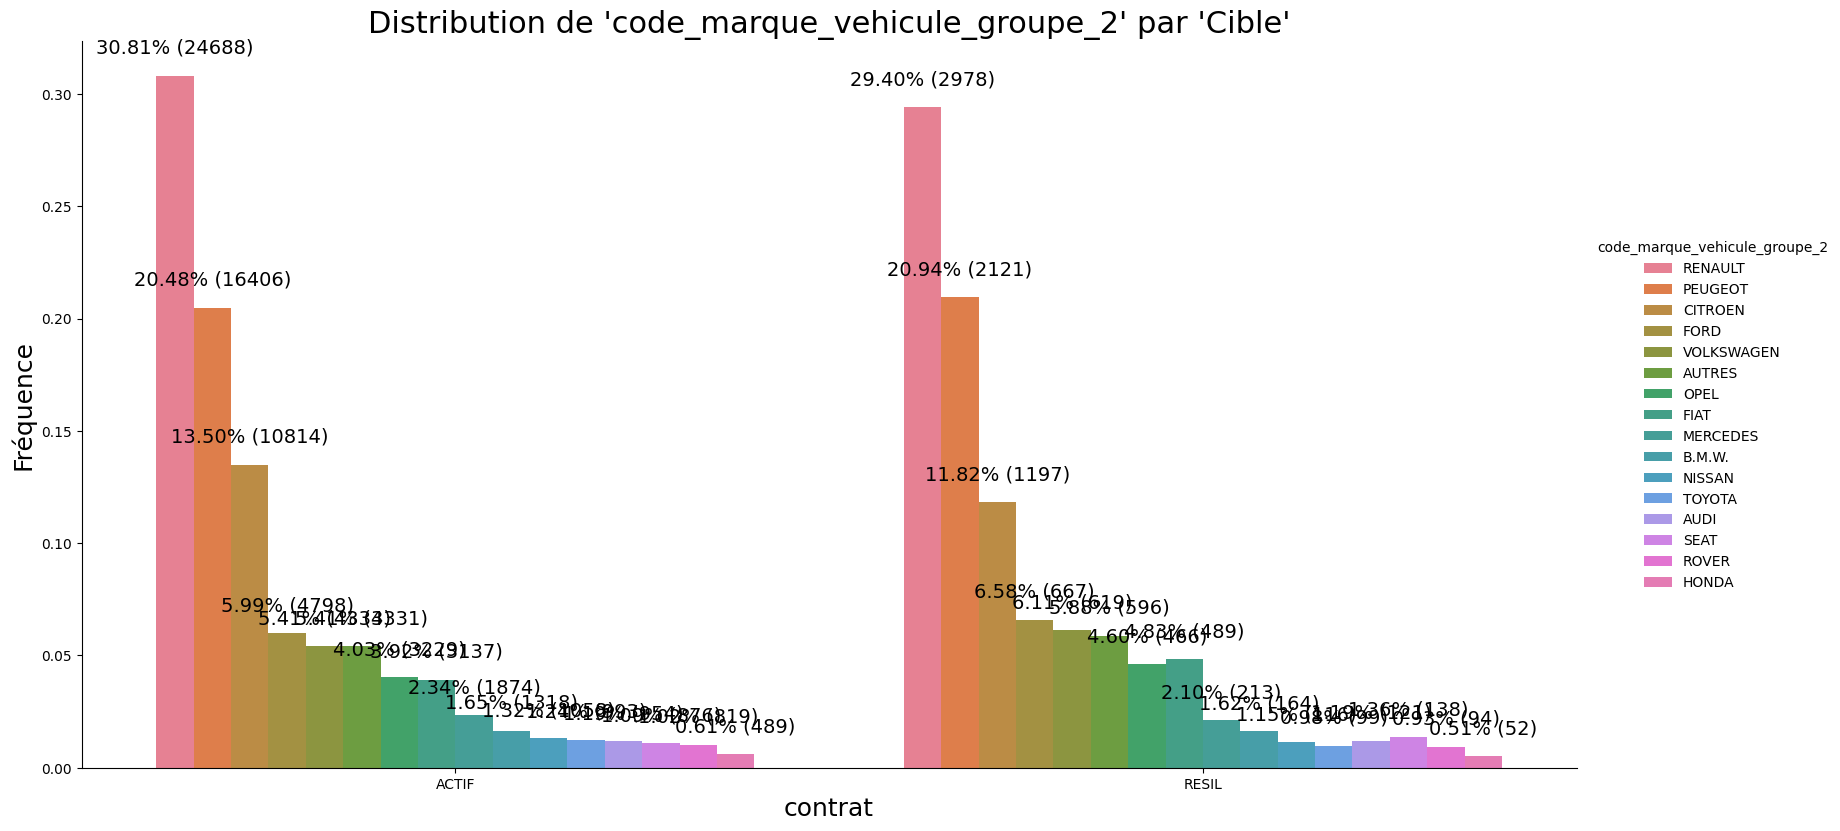

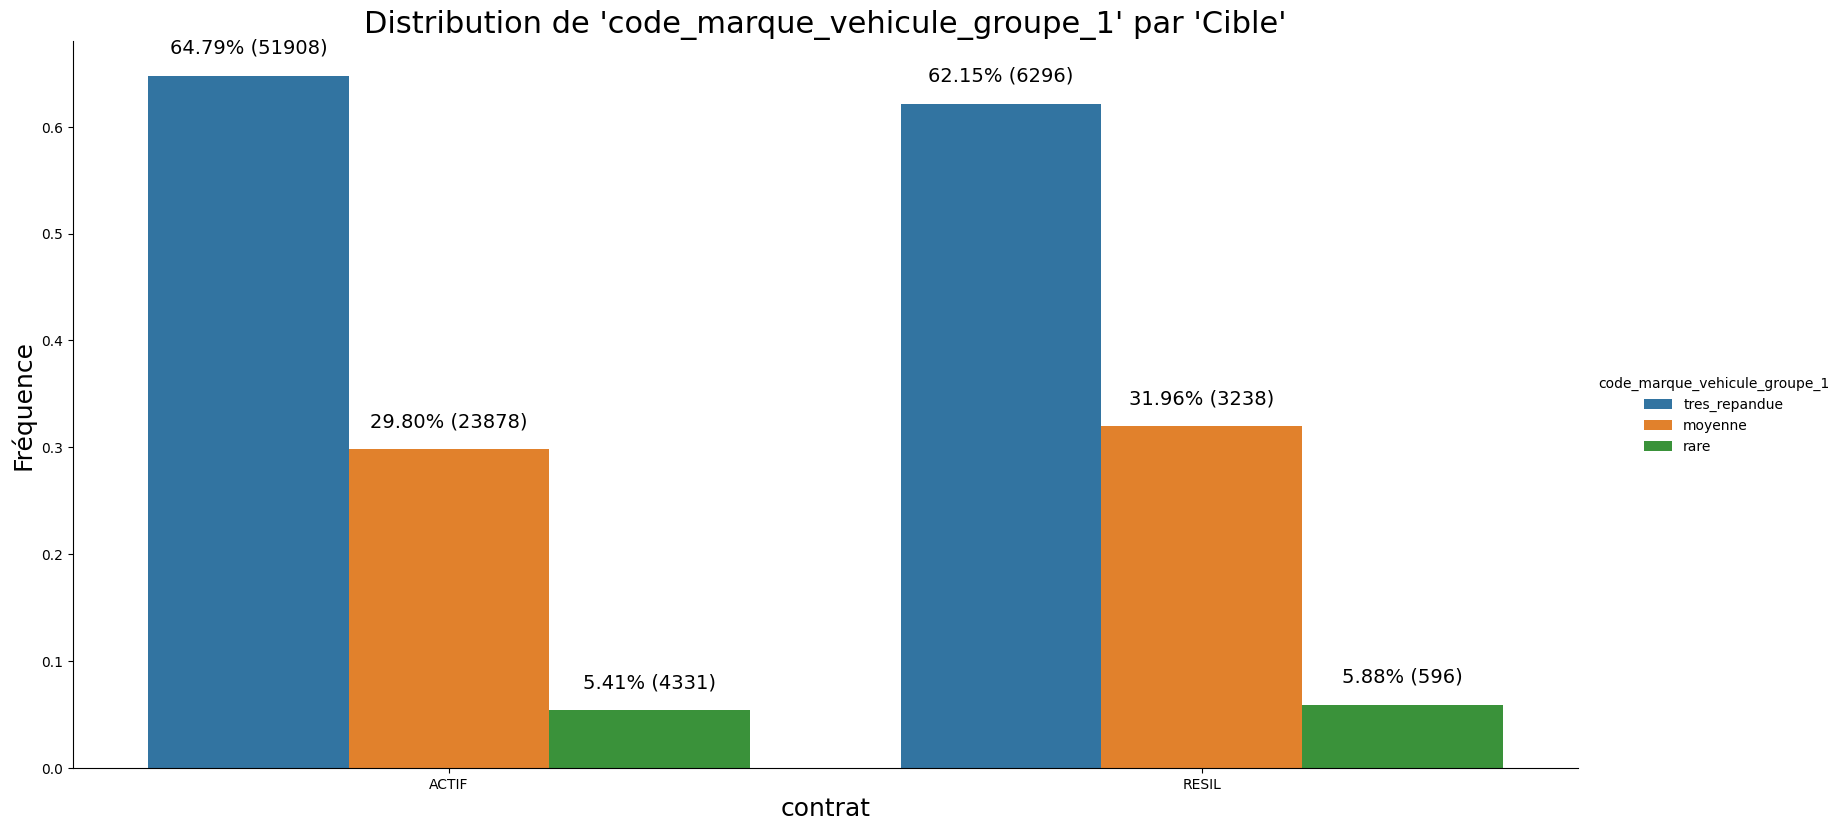

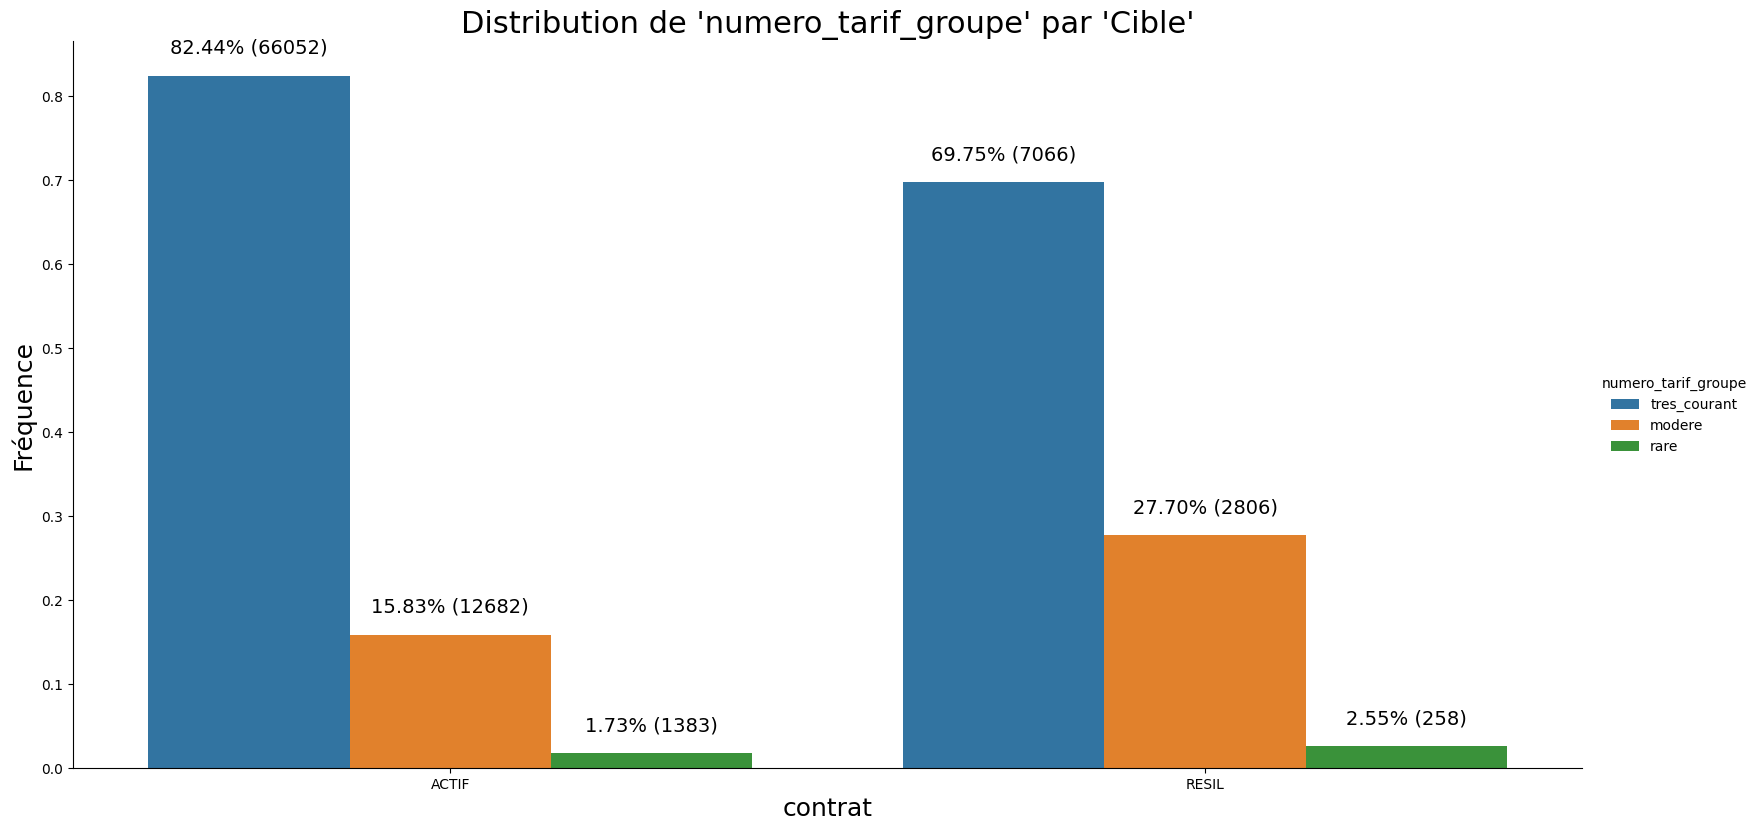

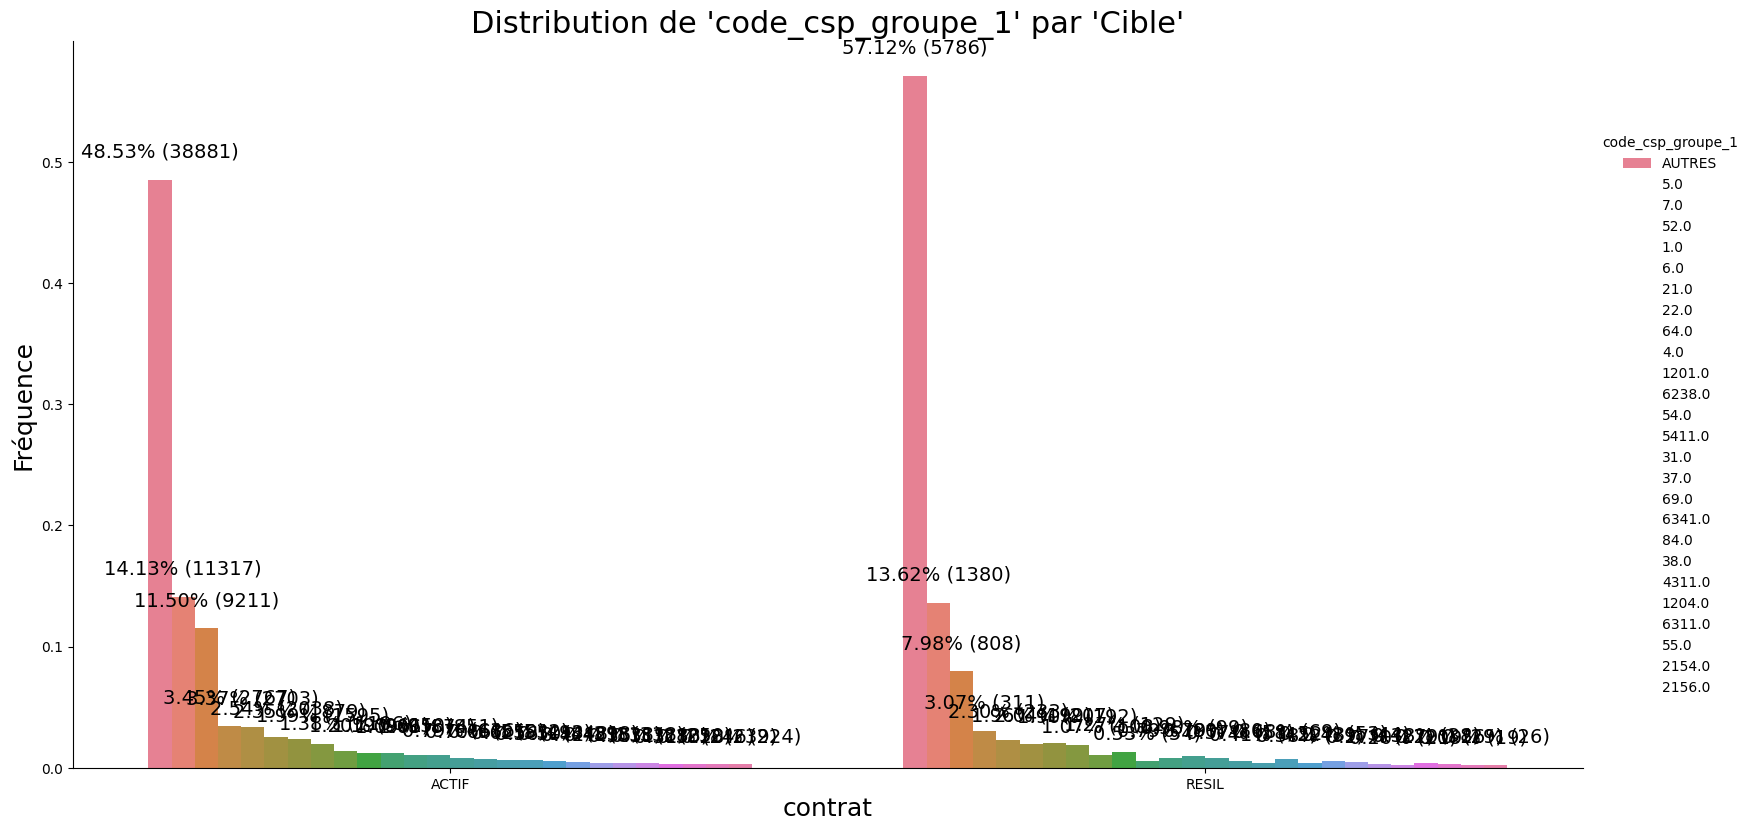

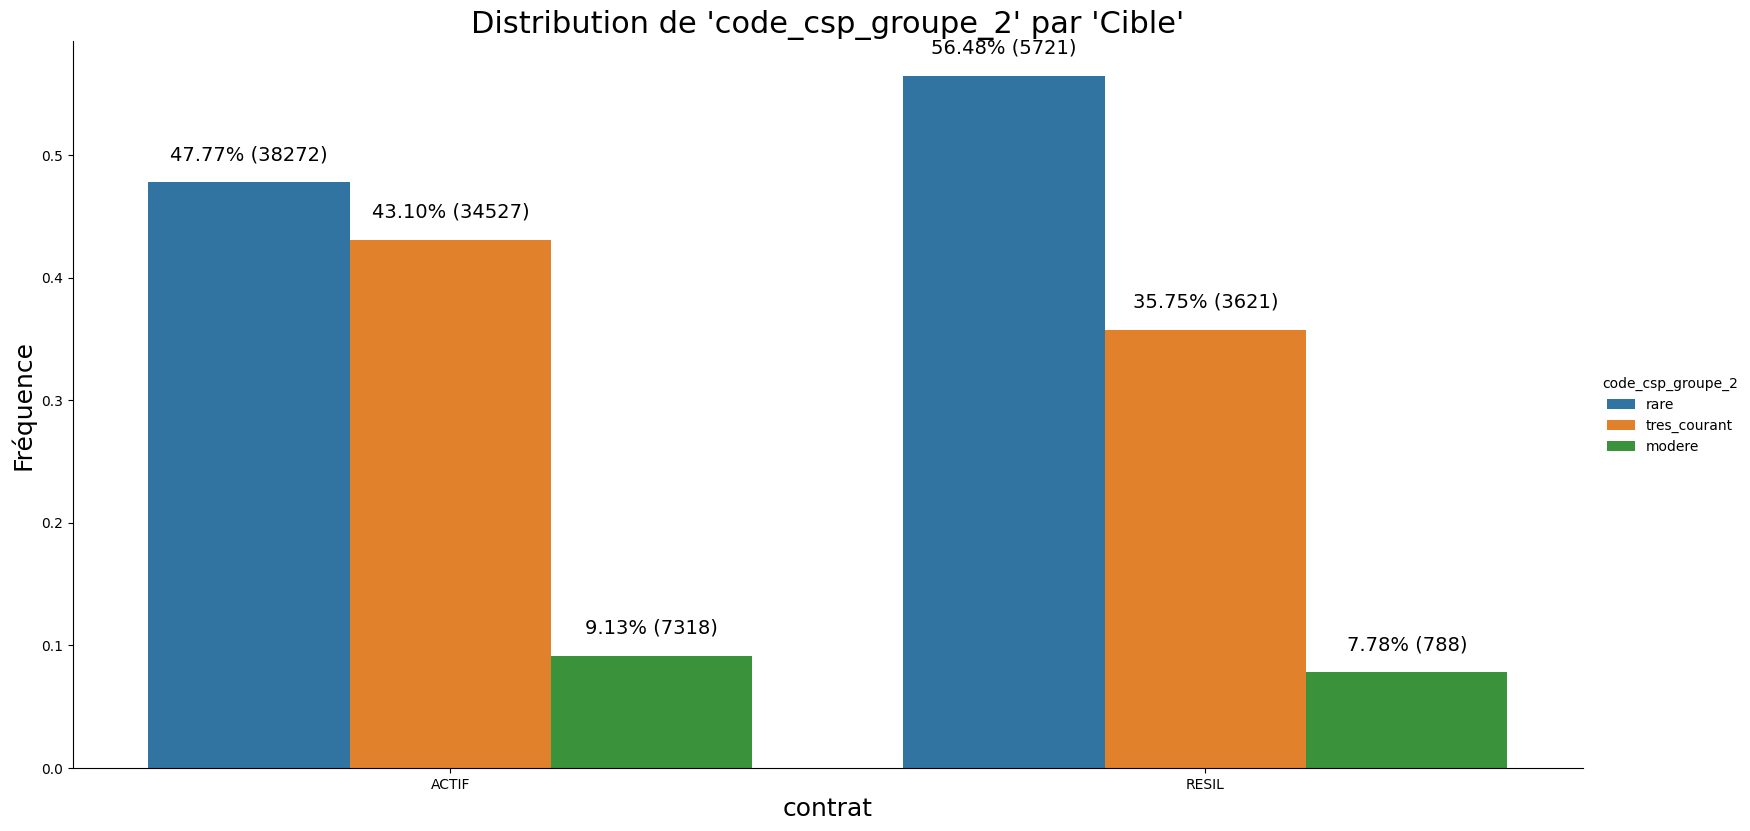

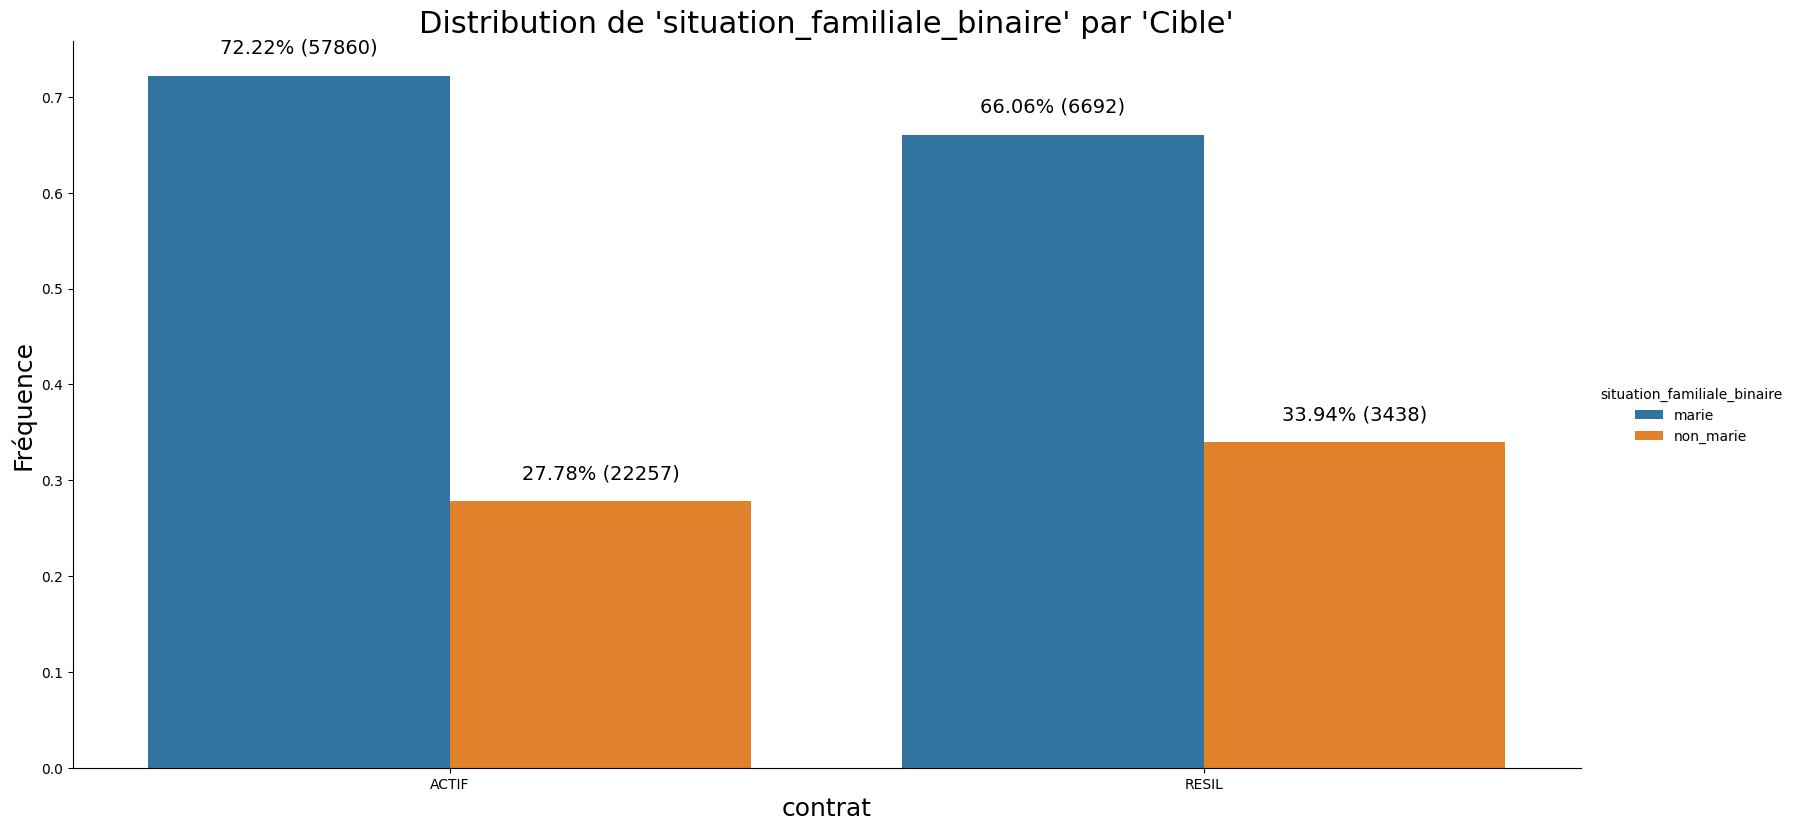

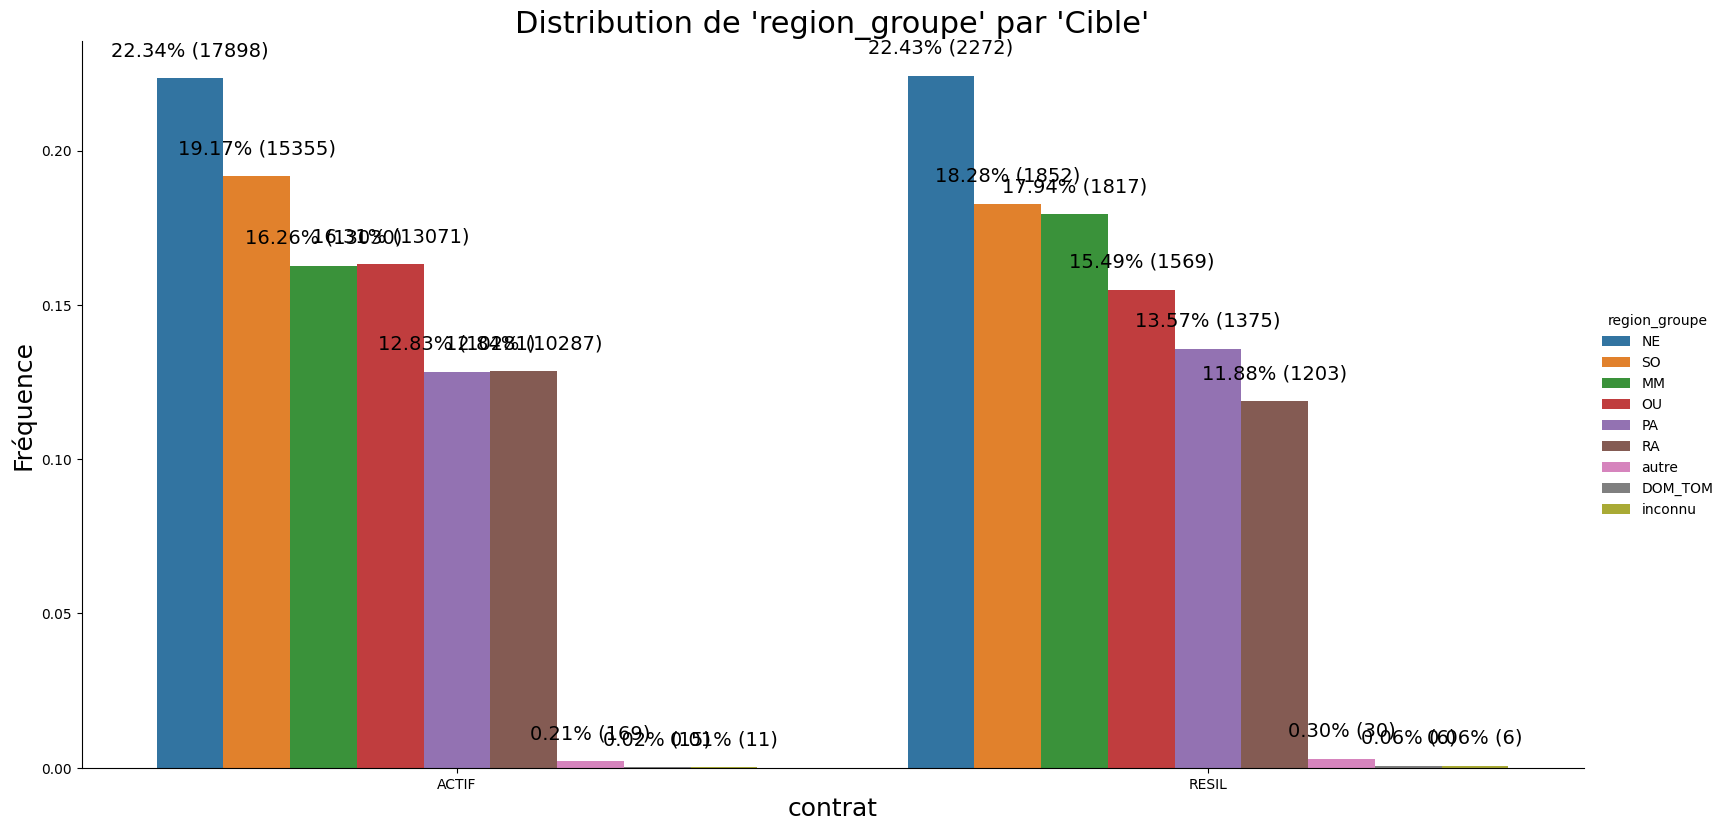

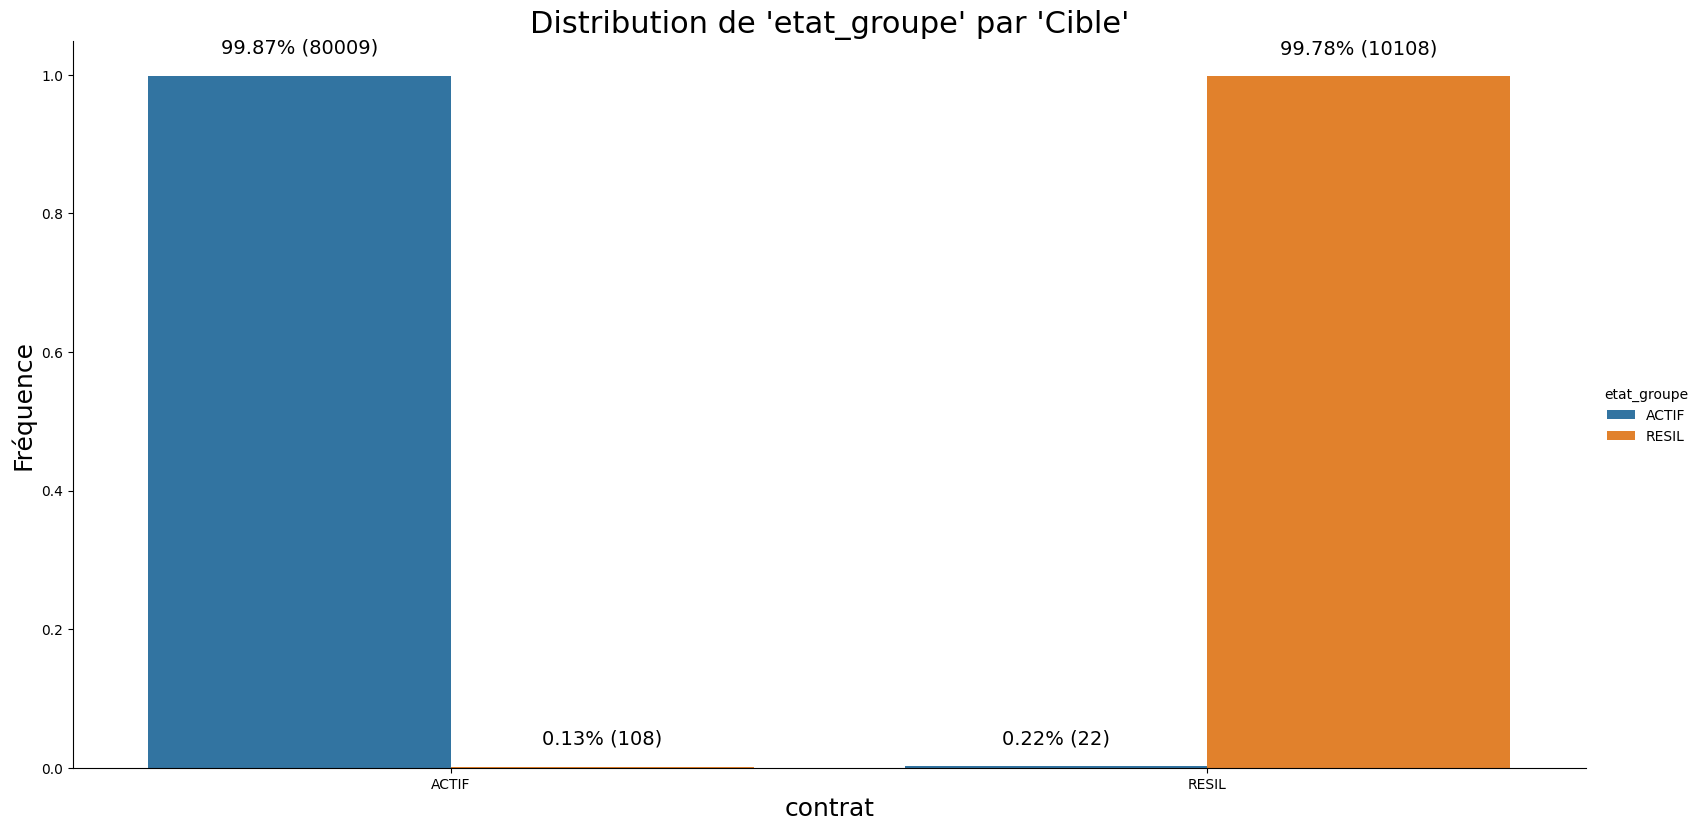

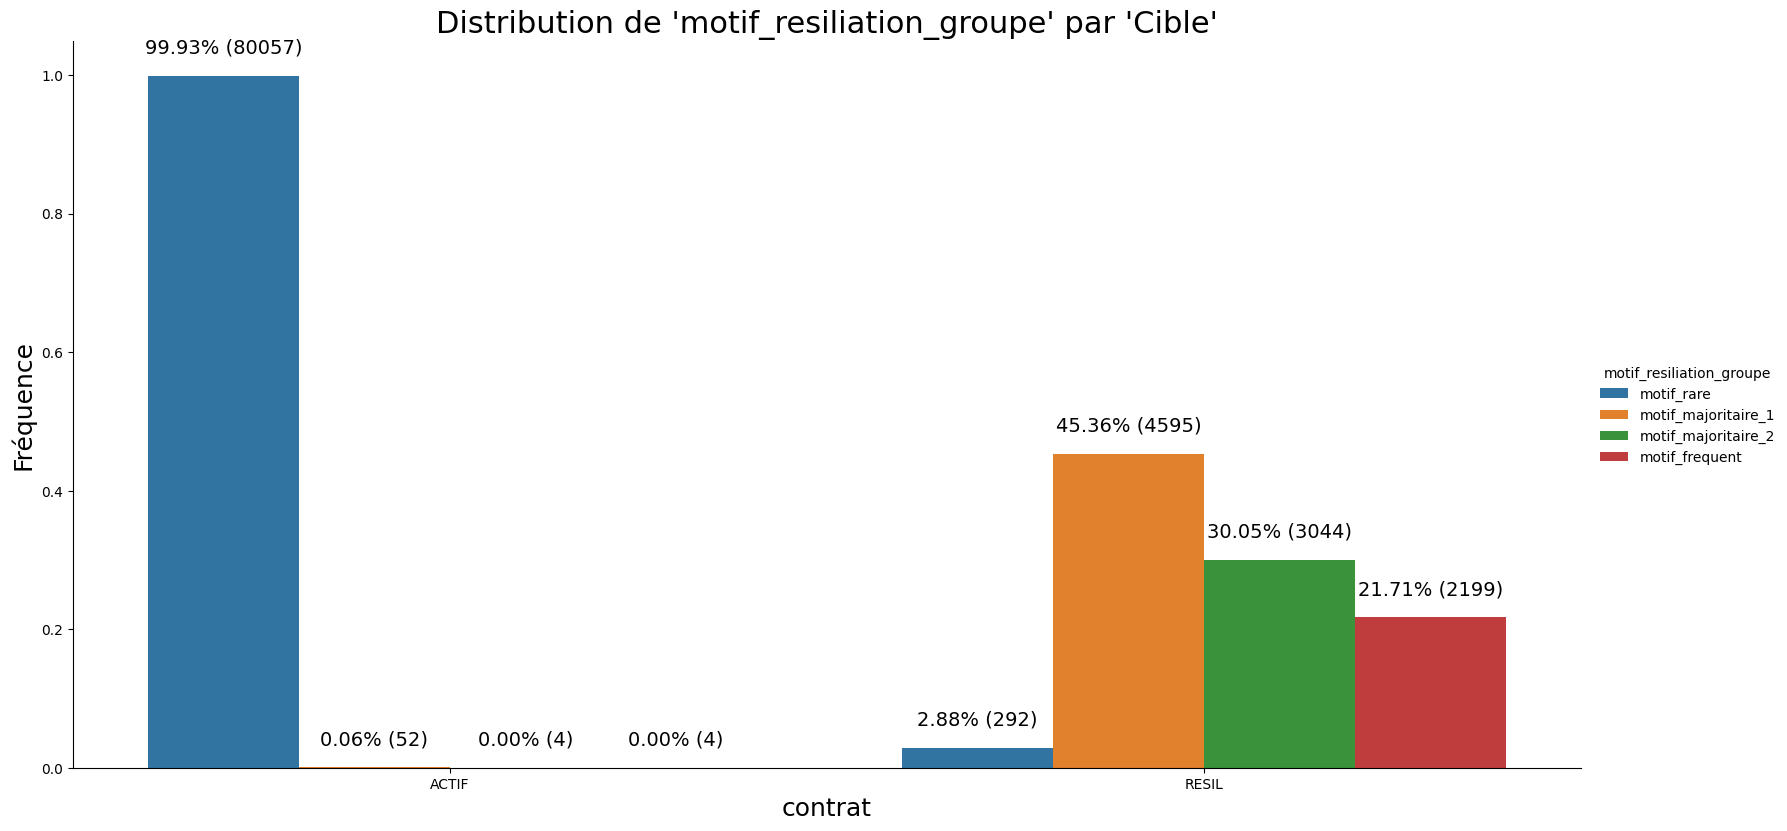

In [240]:
for col in var_cat_add:
    distrib_for_cat_by_target(col,df,"contrat")

✏️ **Interpretation :**

### 2.4.2 Représentations graphiques des continues et de date par rapport à la cible

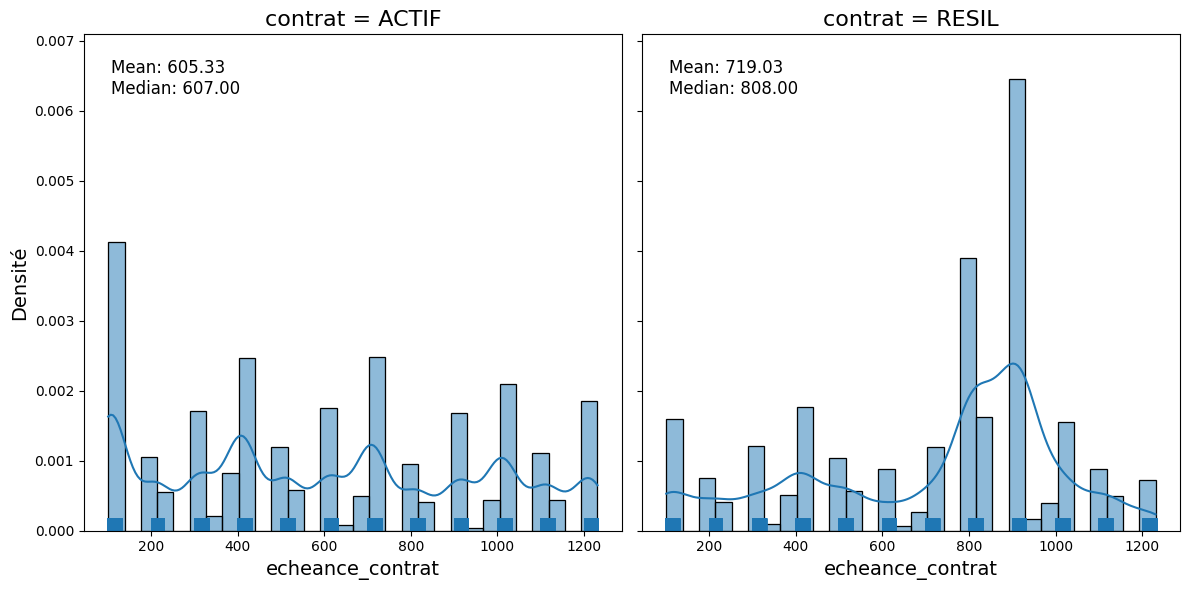

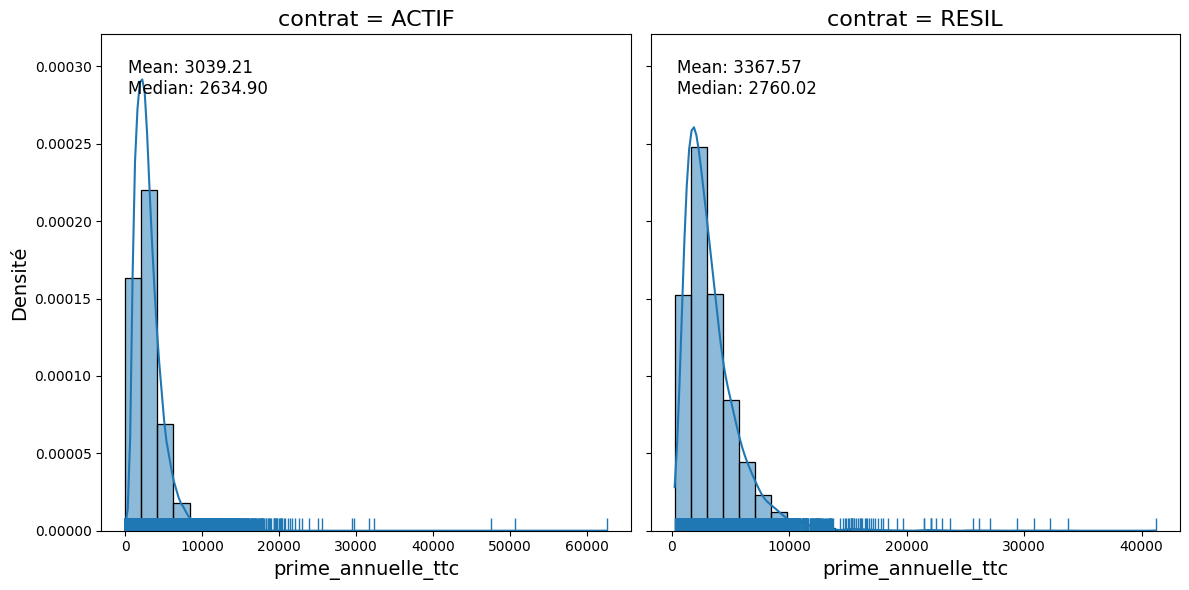

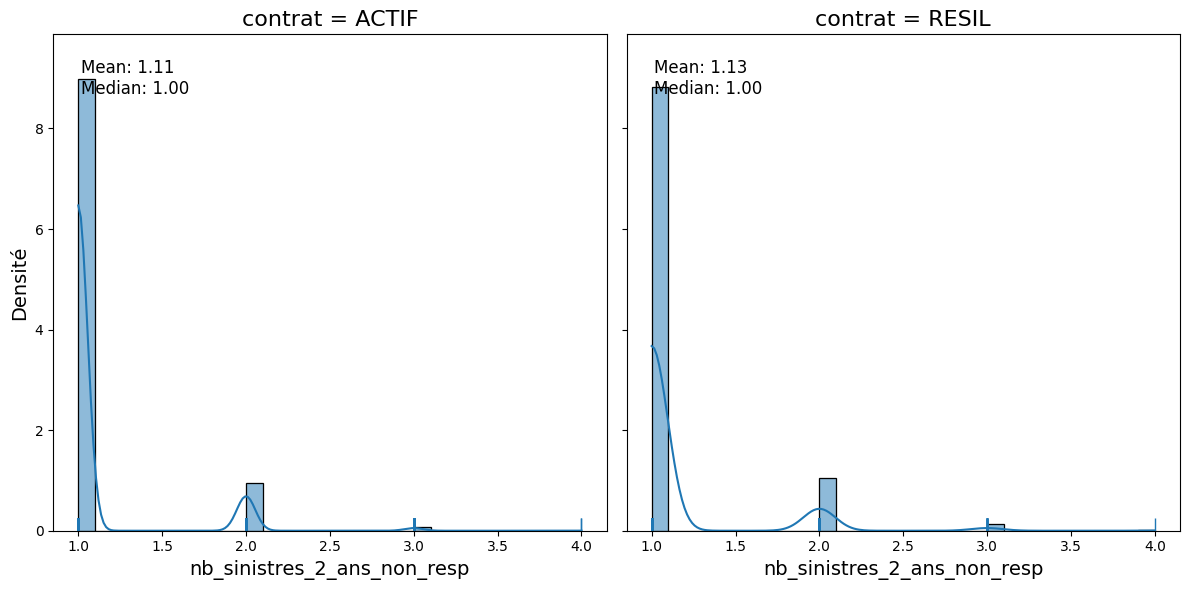

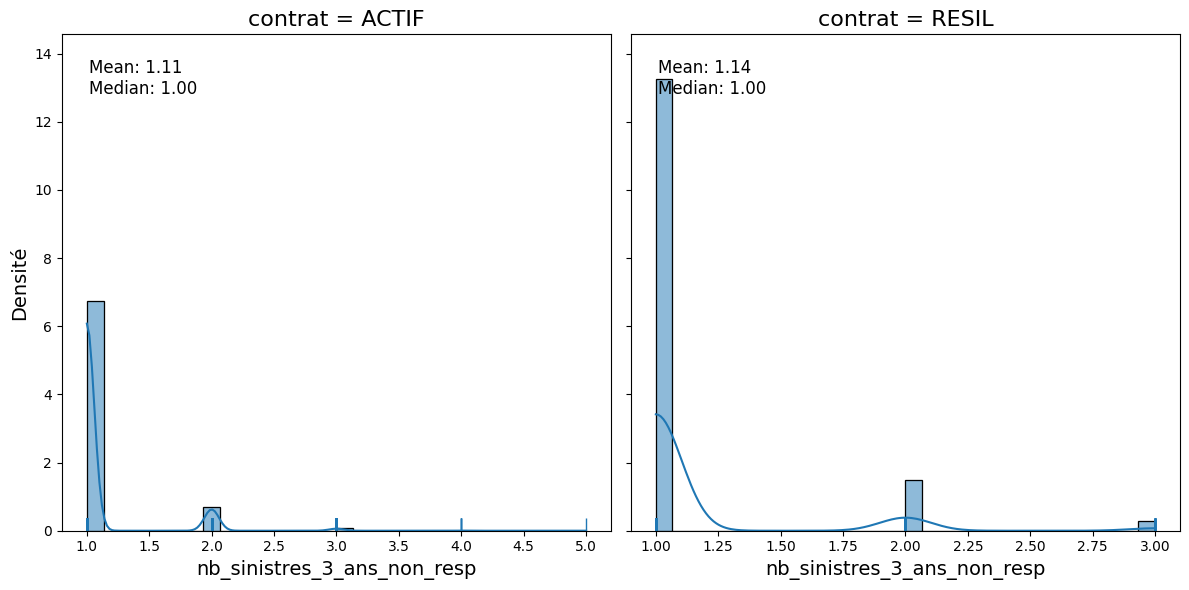

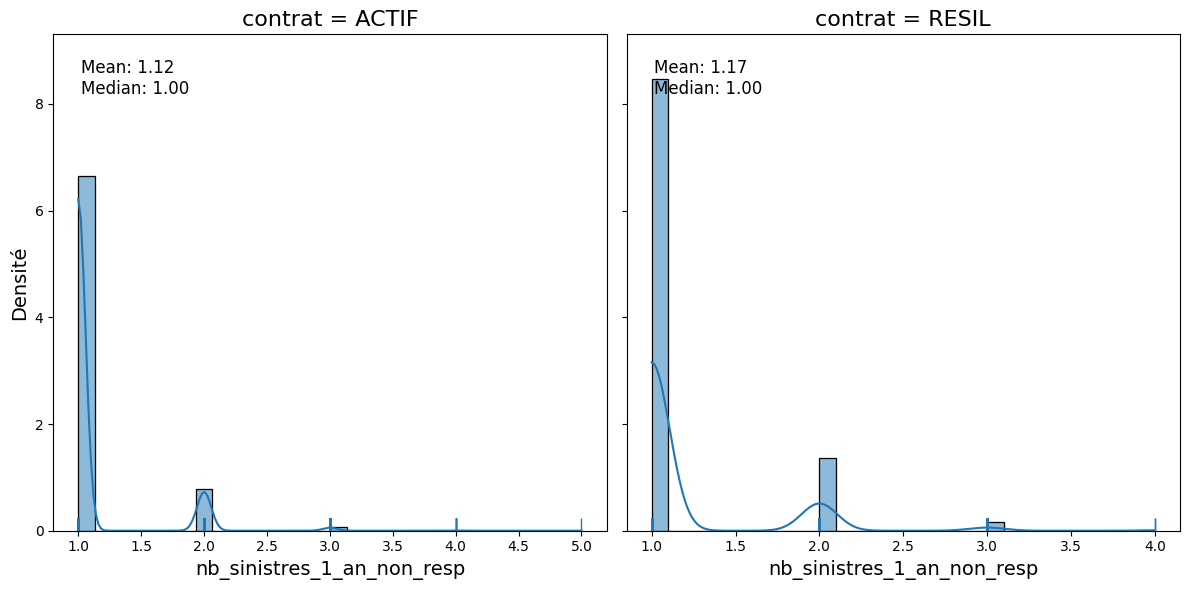

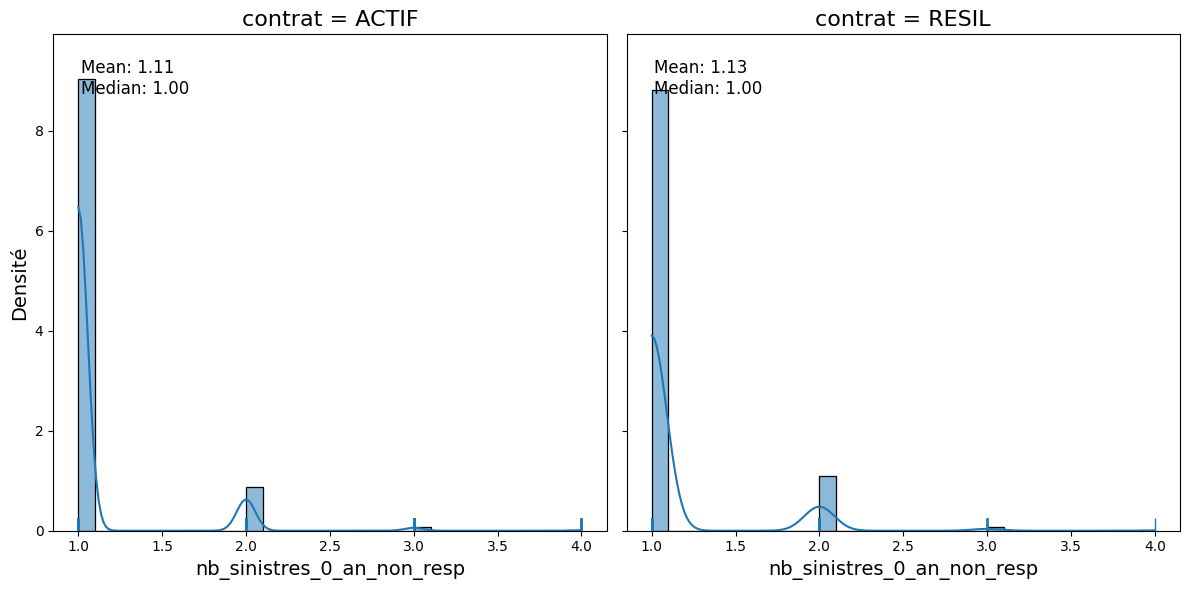

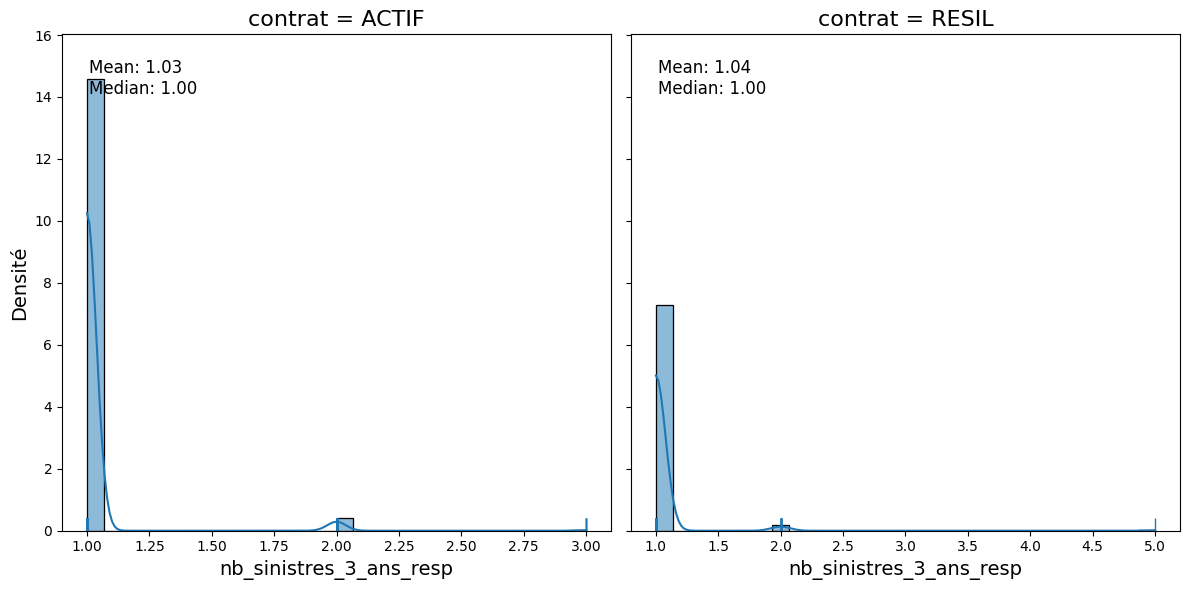

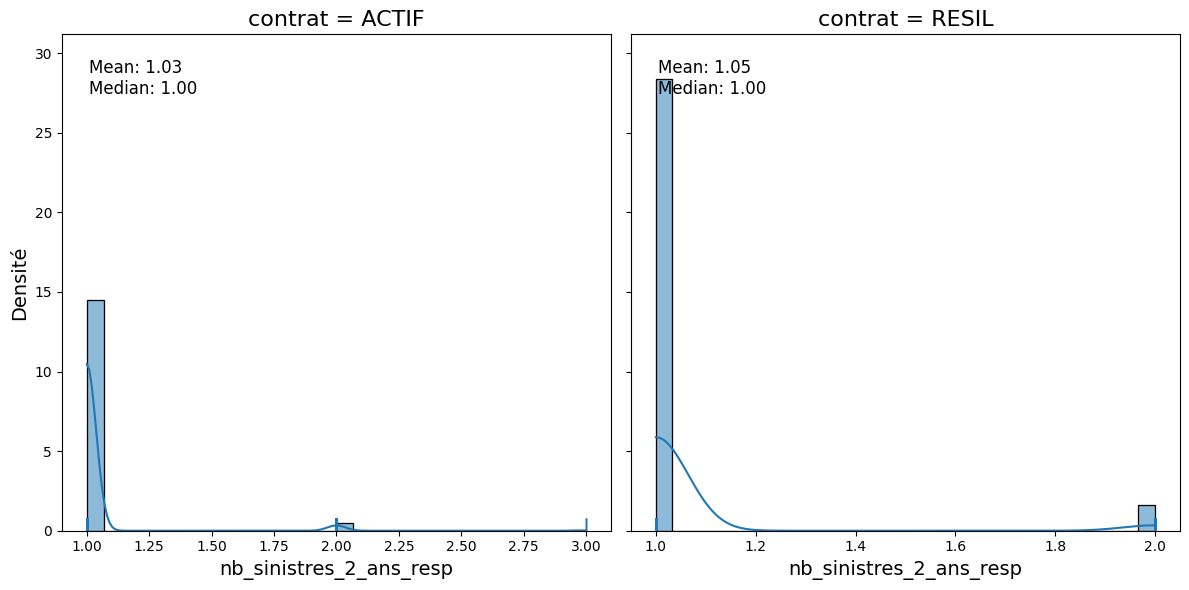

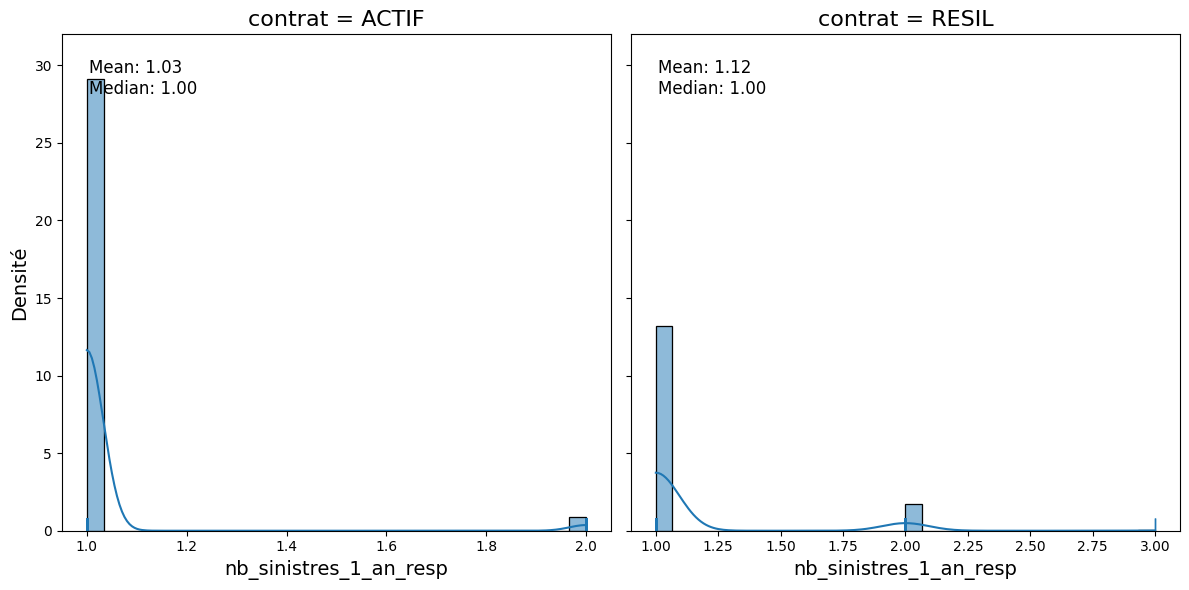

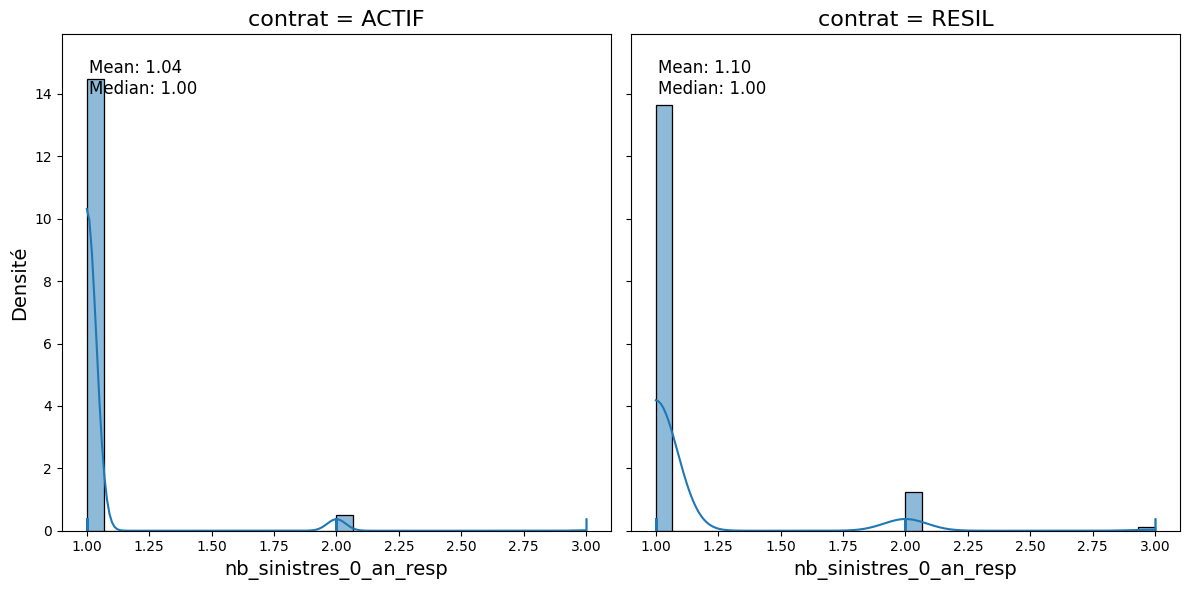

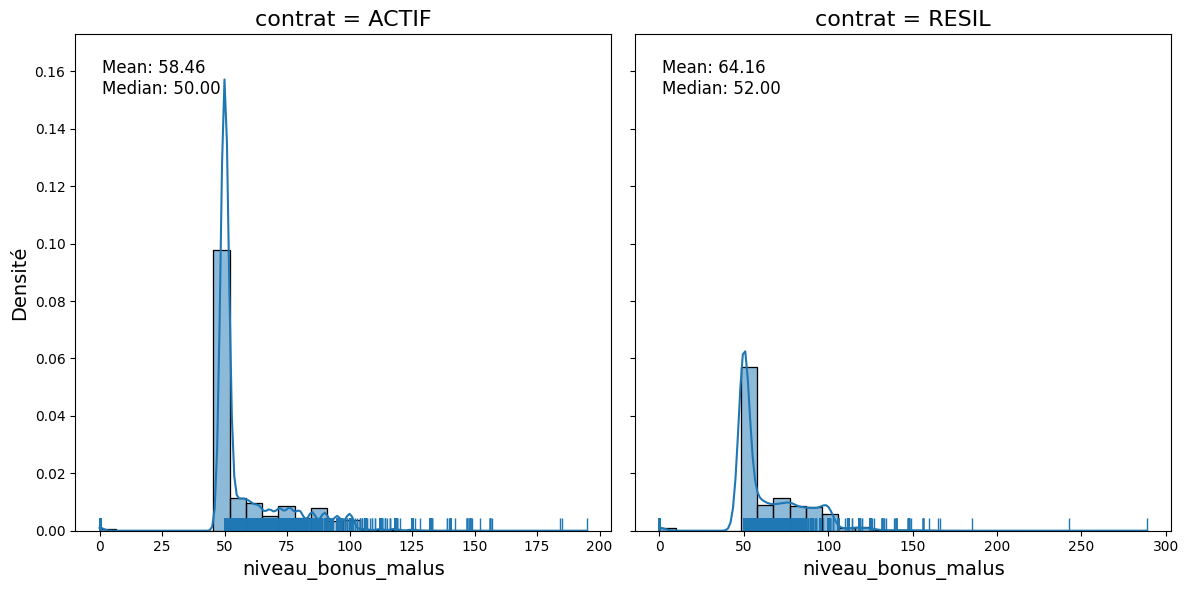

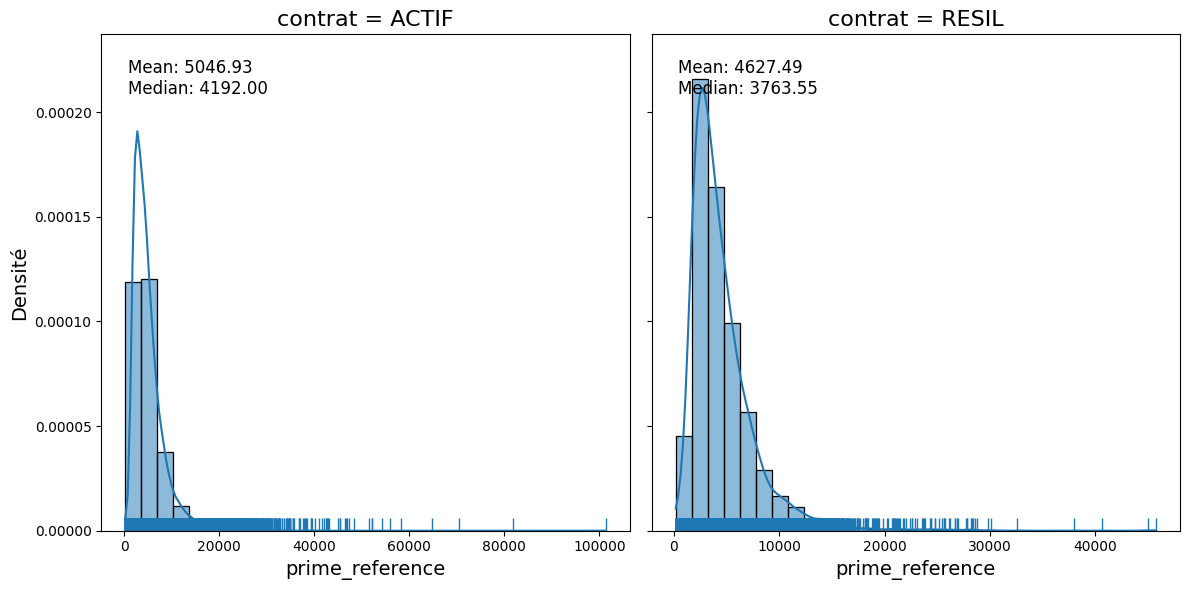

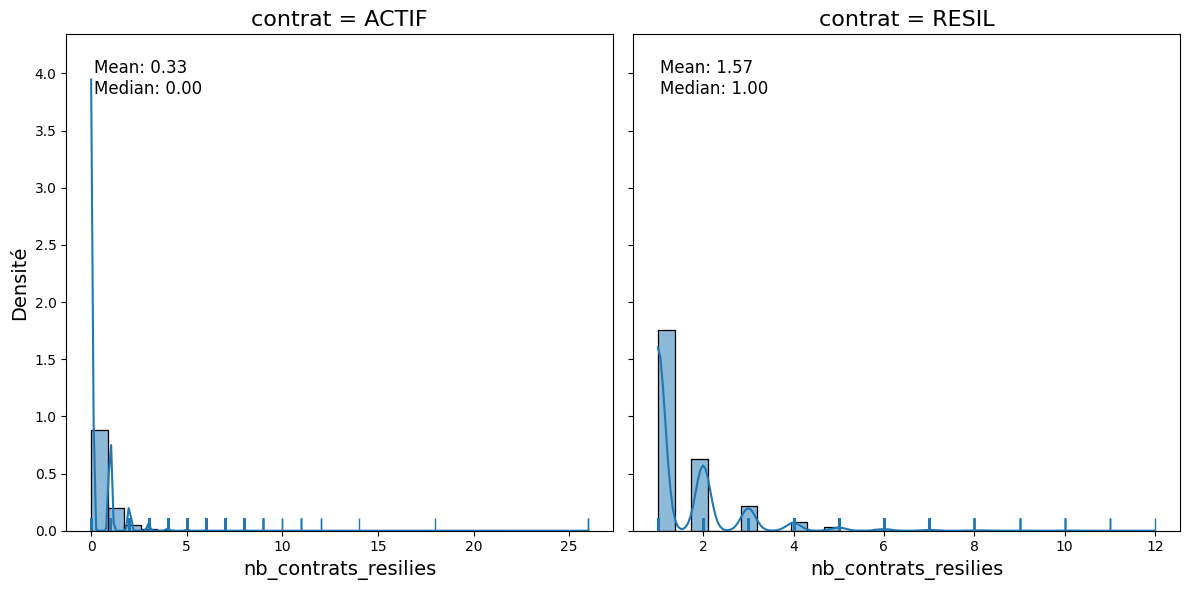

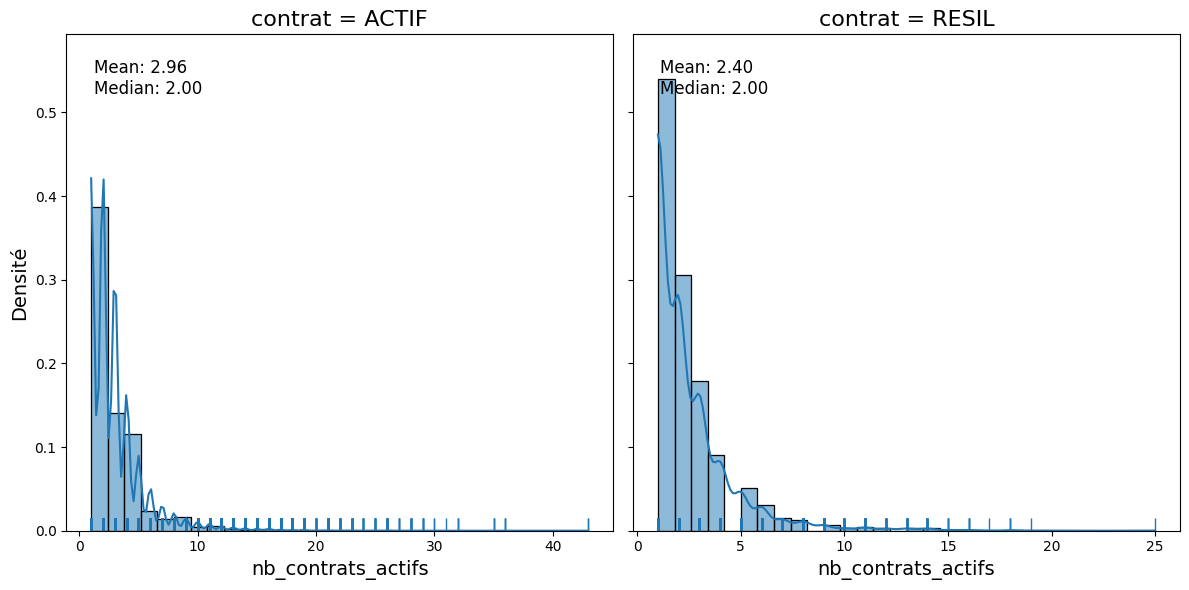

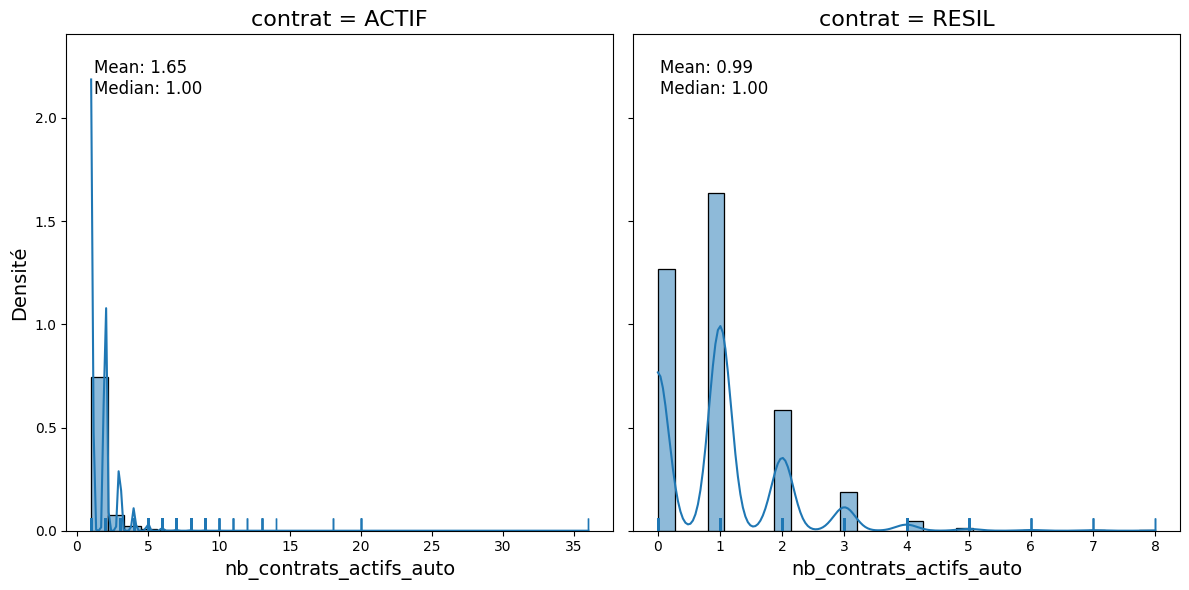

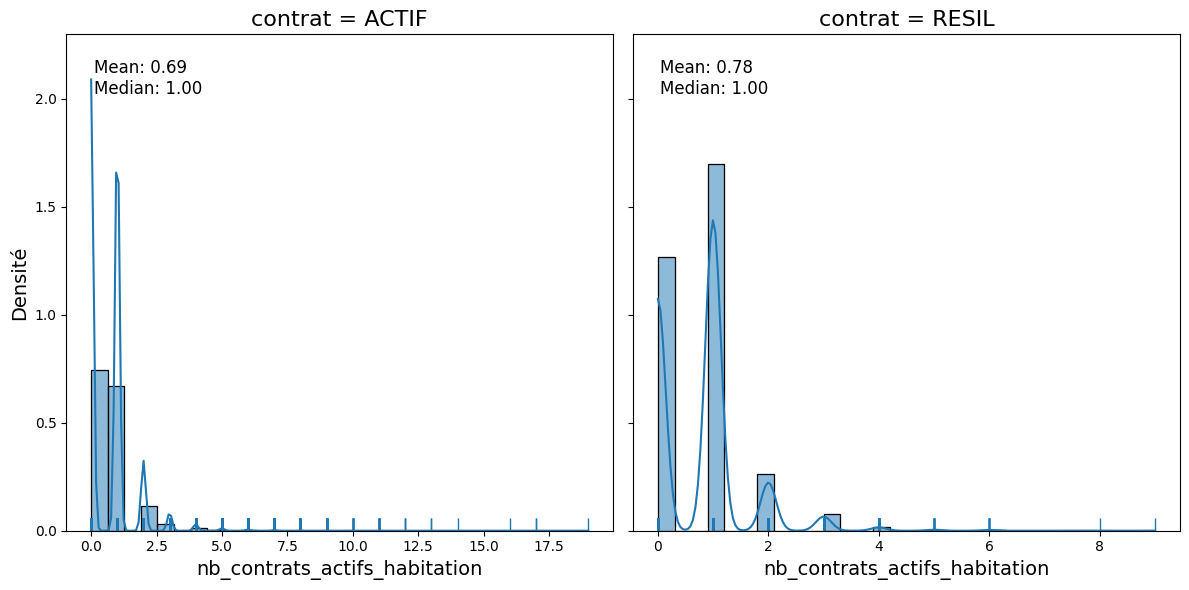

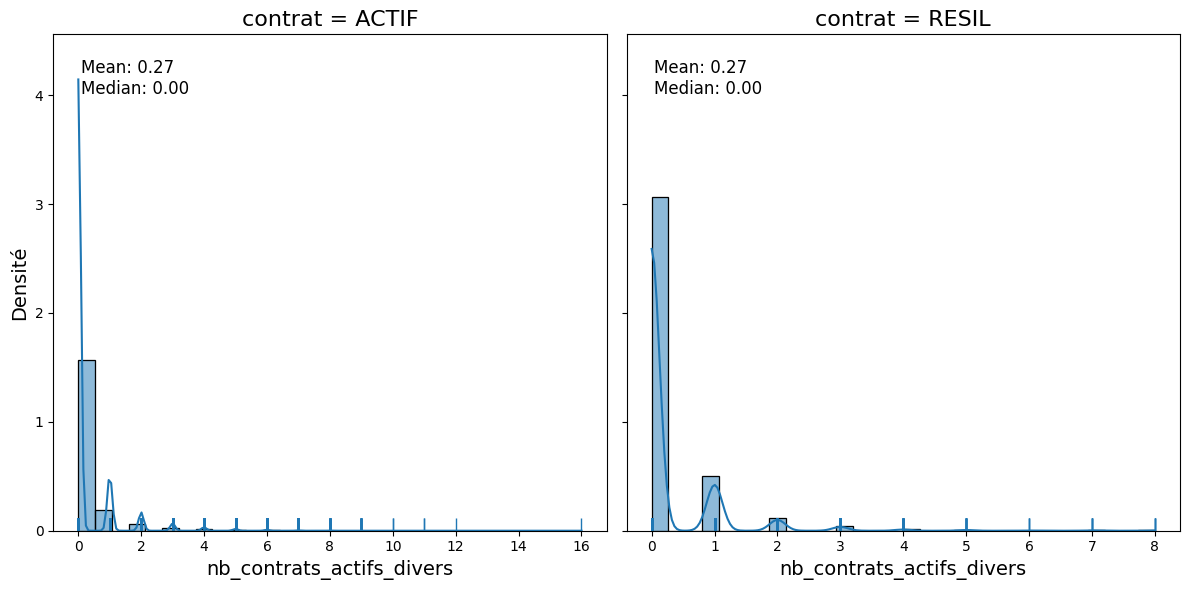

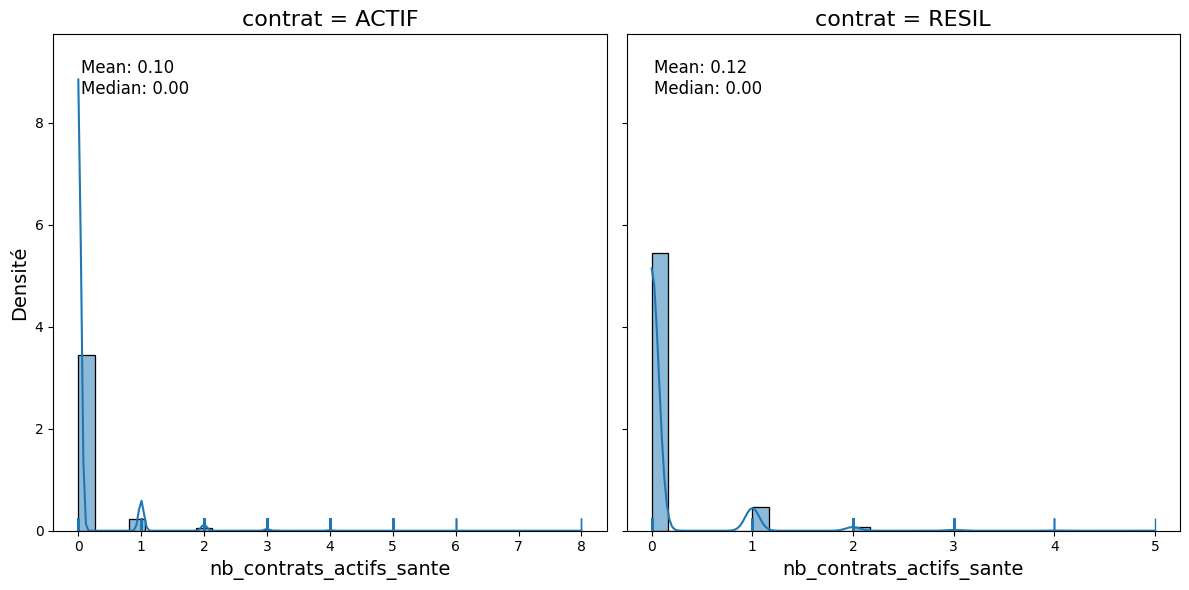

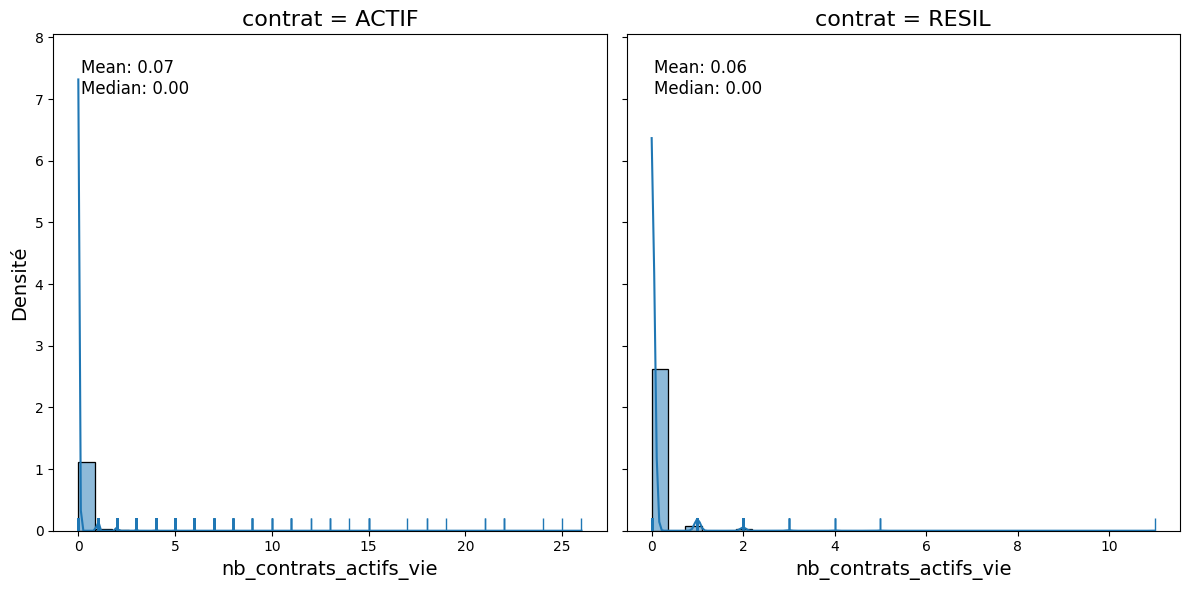

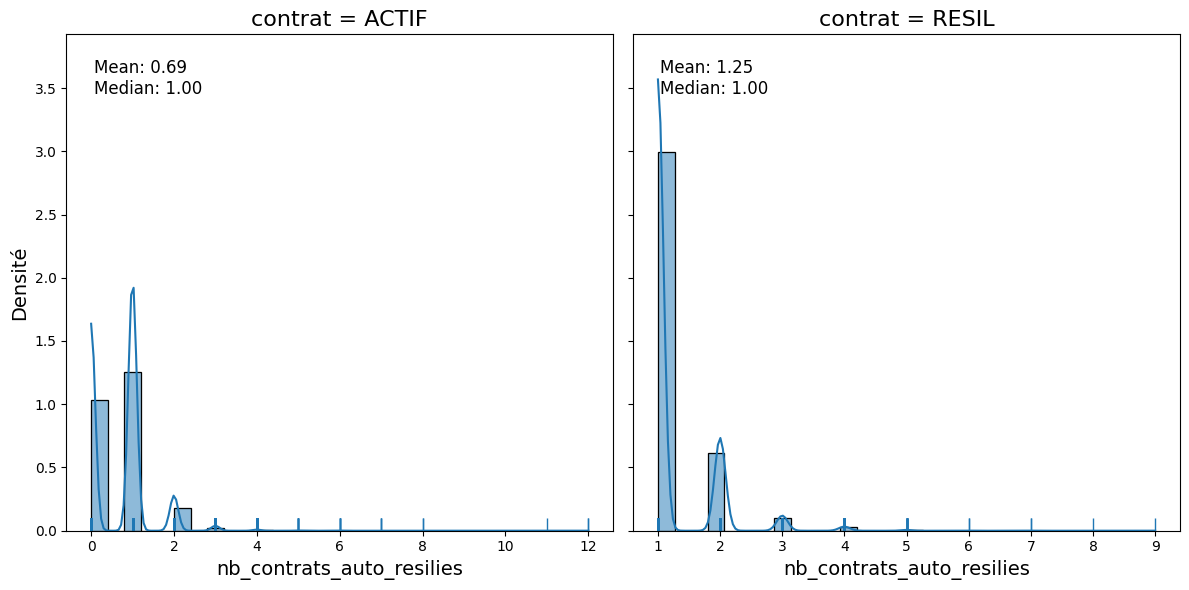

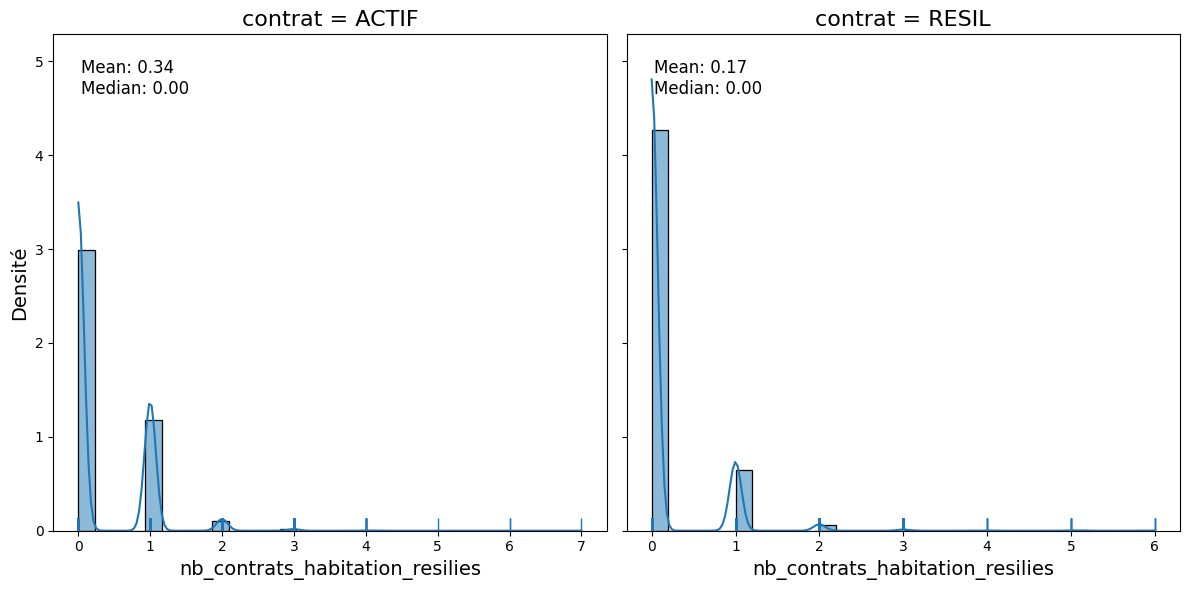

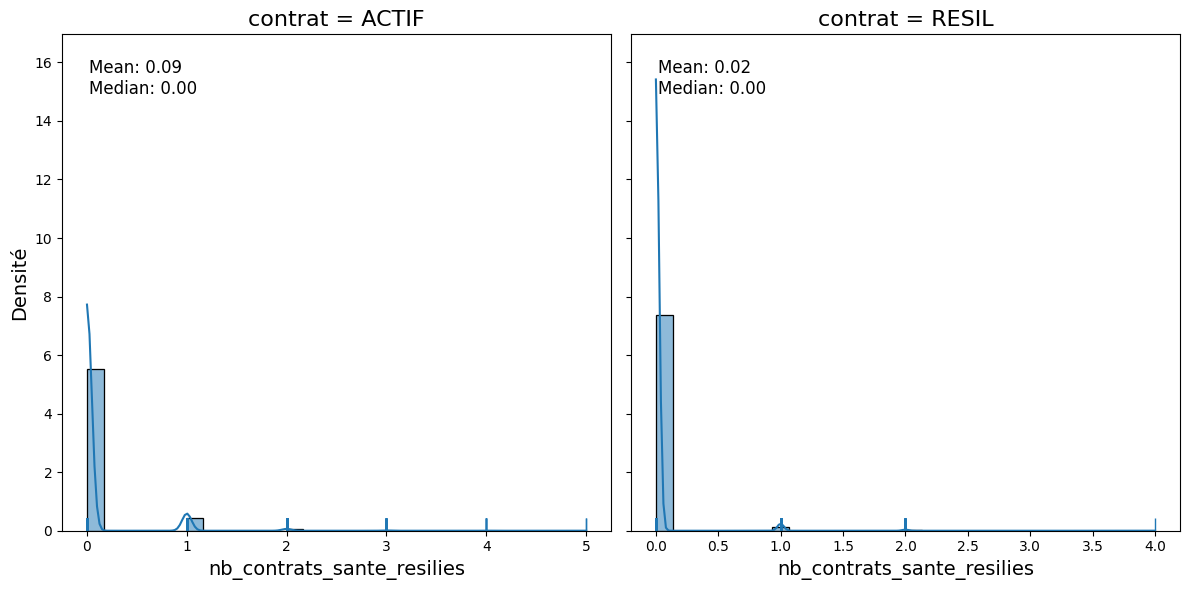

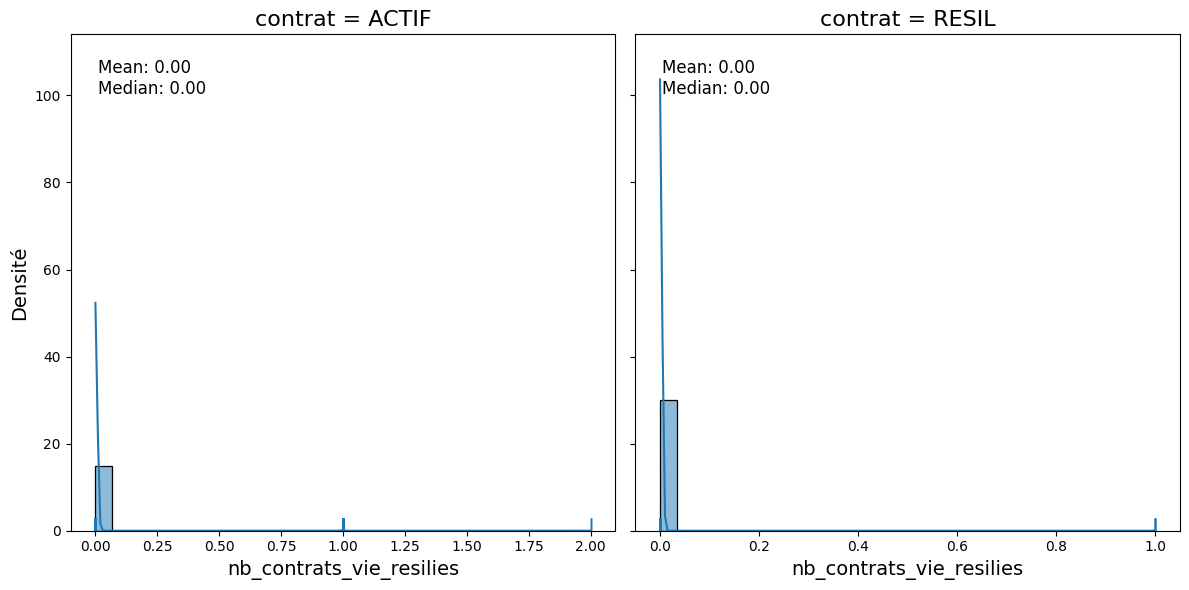

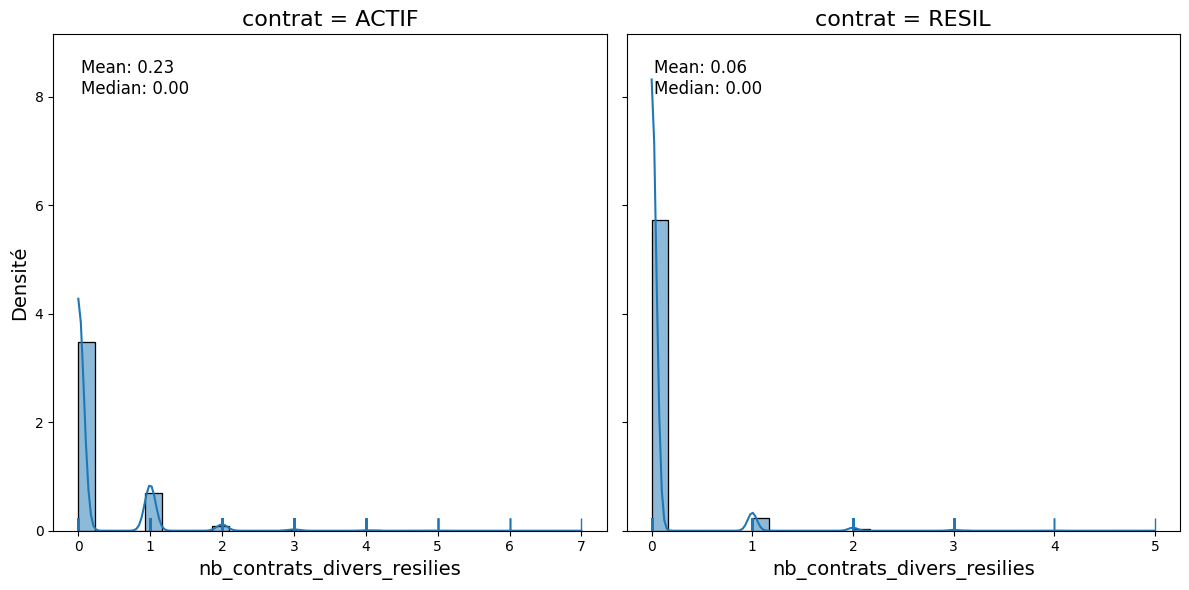

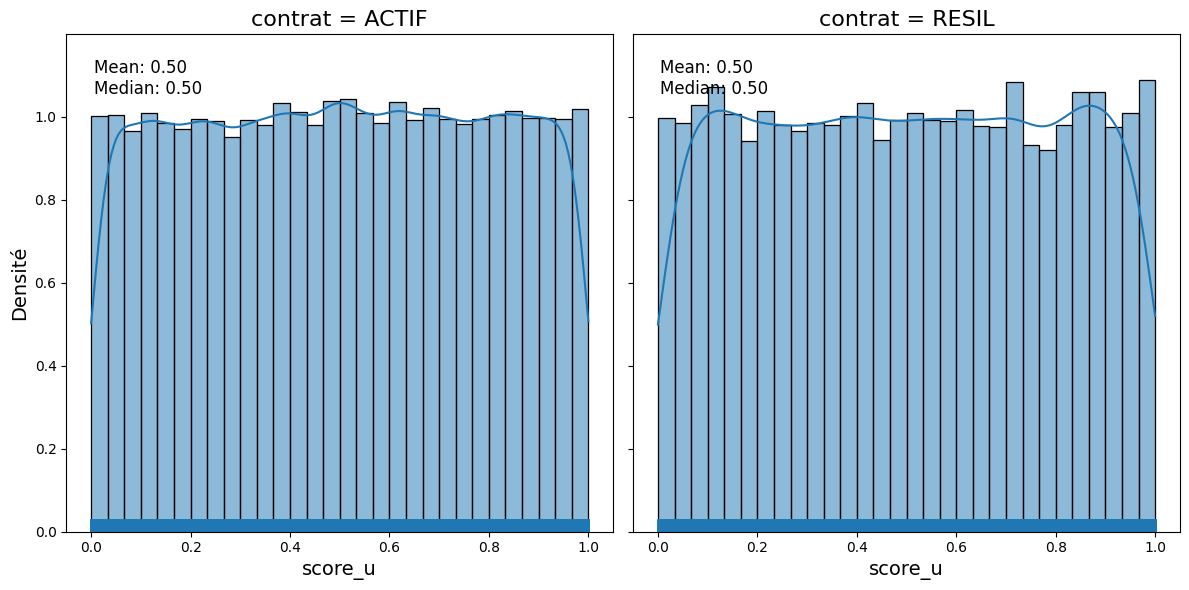

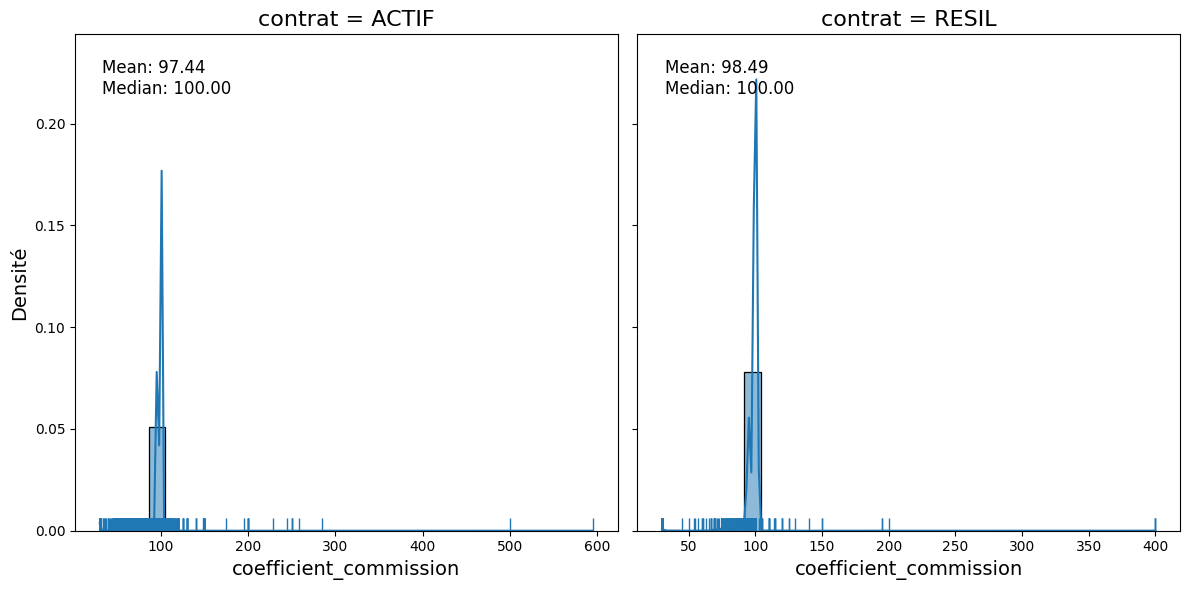

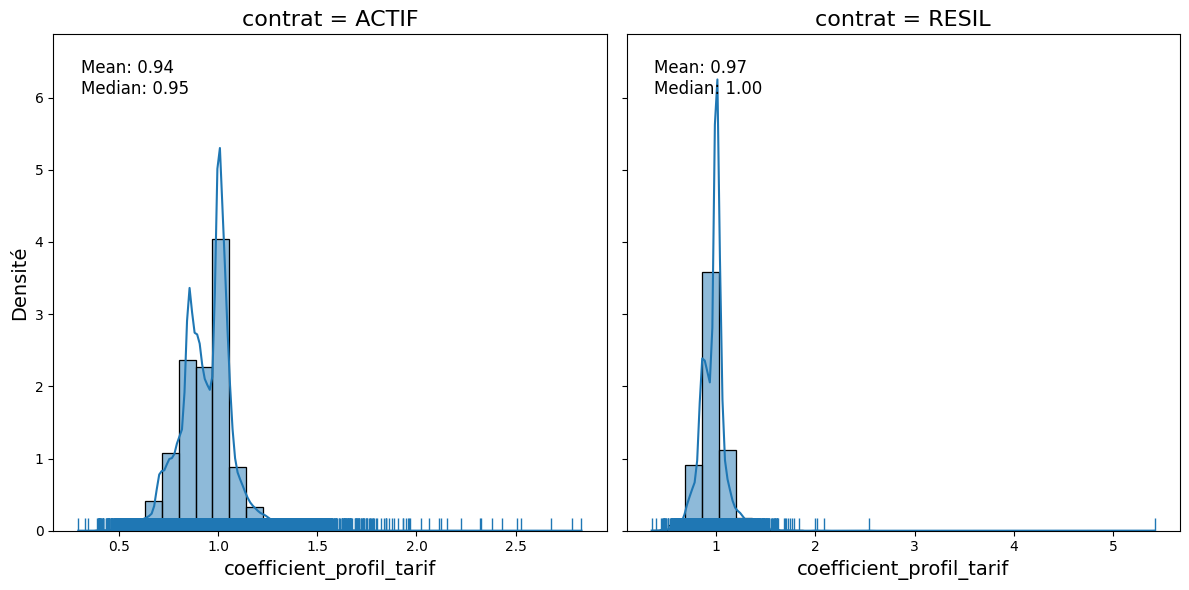

In [ ]:
for field in var_num:
    distrib_for_cont_by_target(field,df,"contrat")

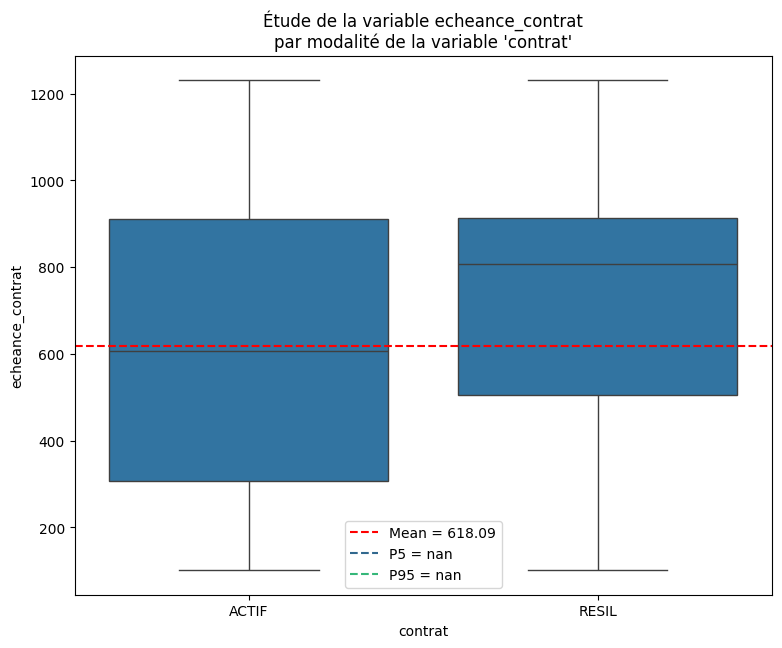

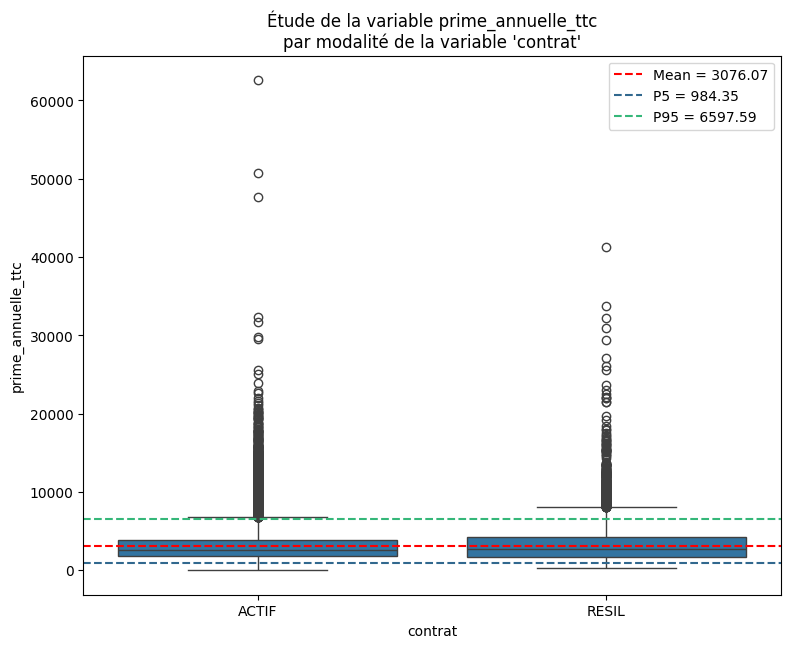

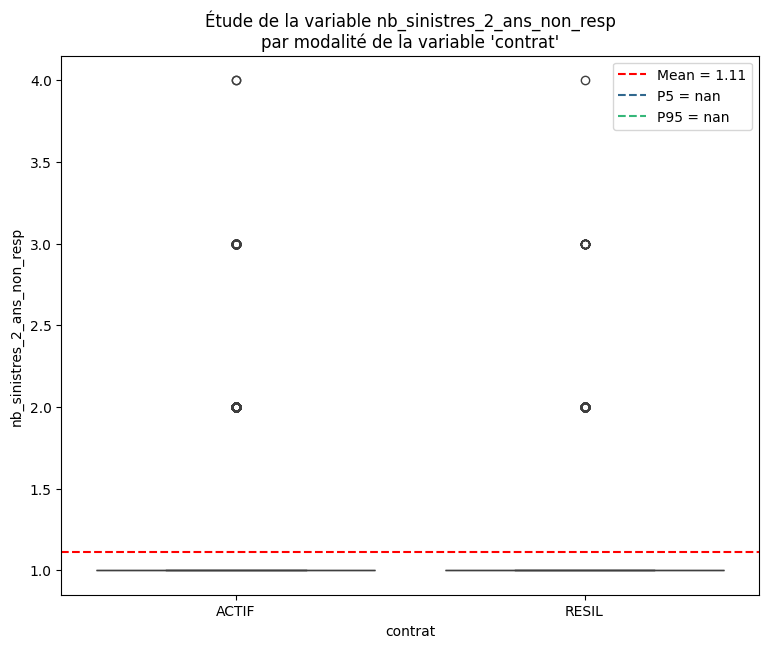

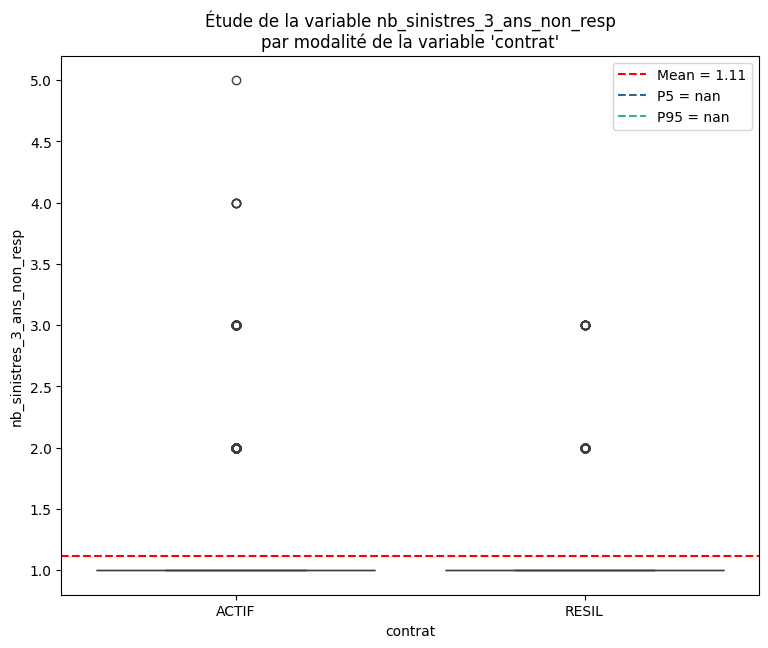

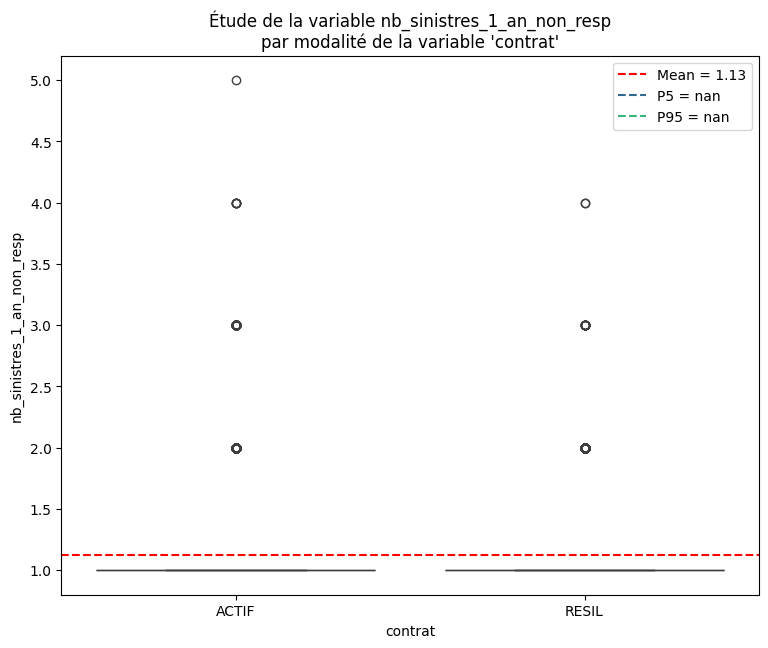

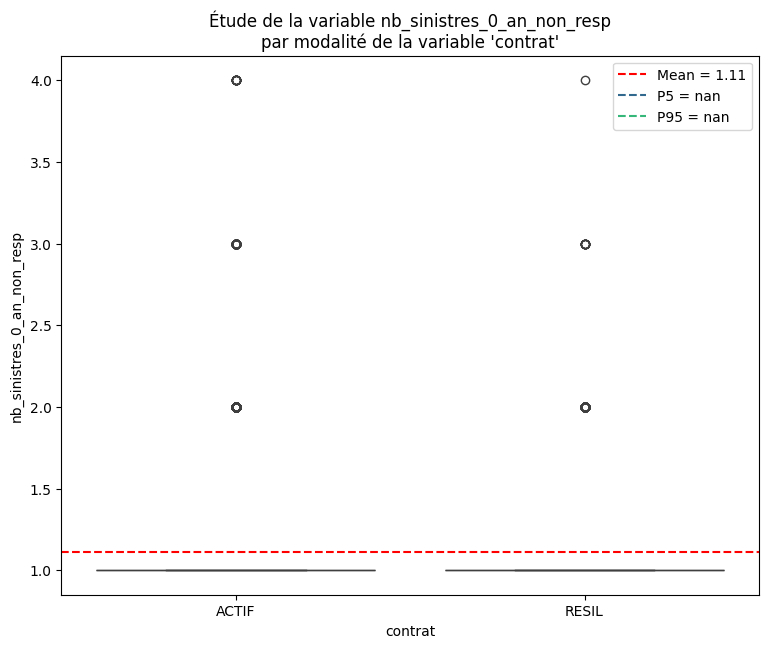

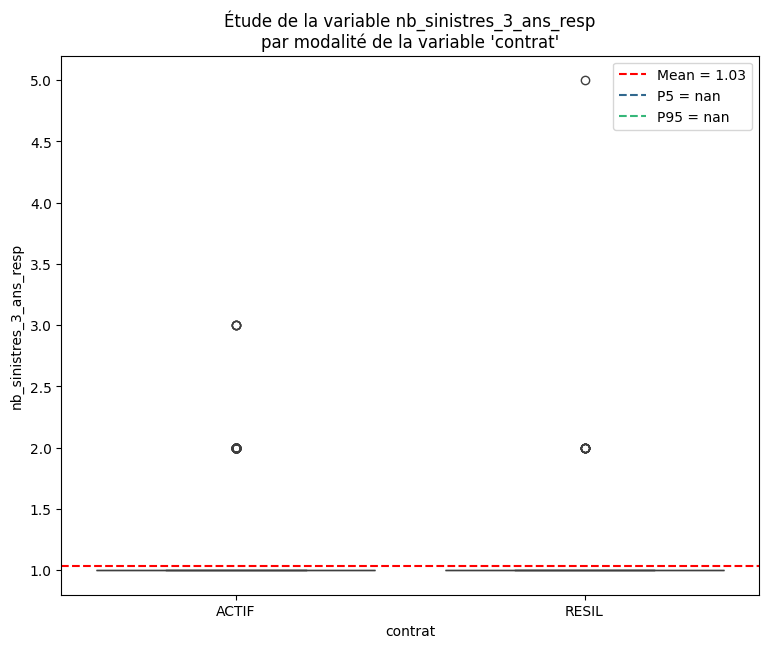

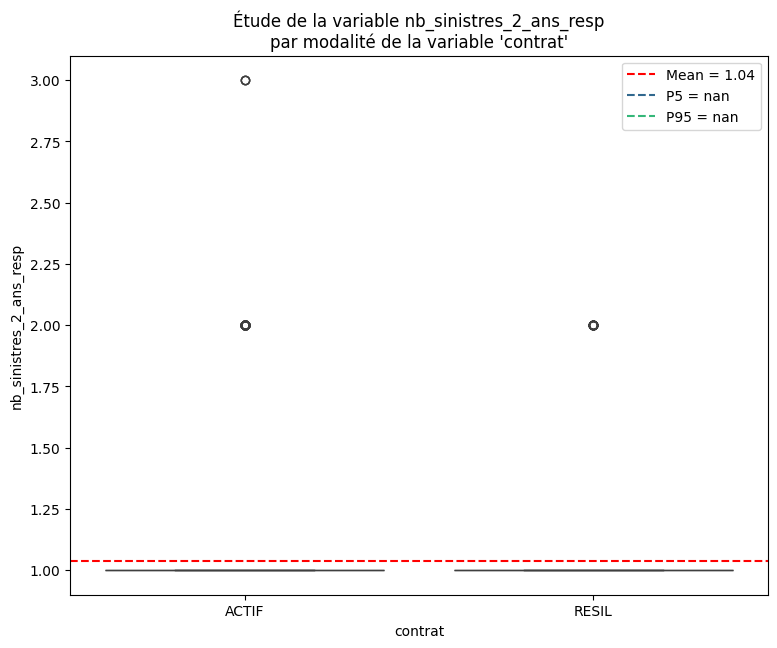

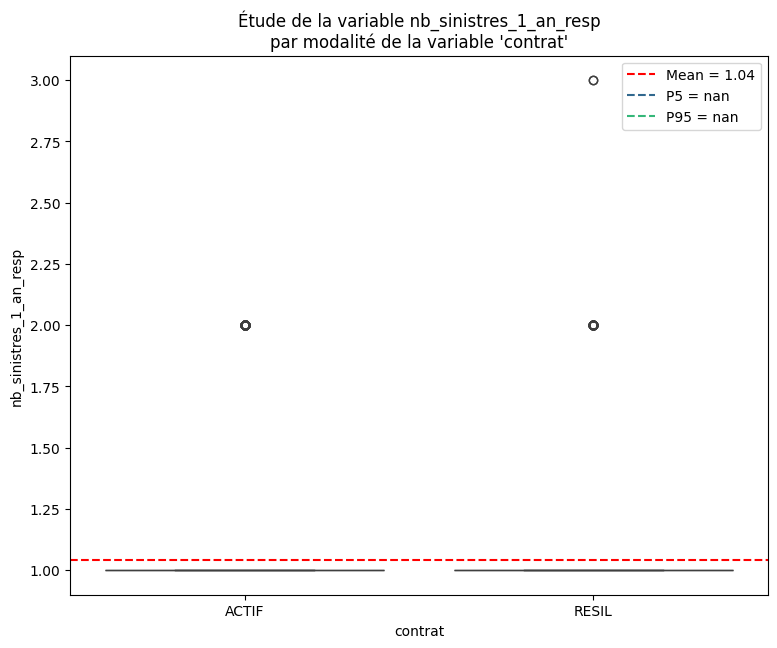

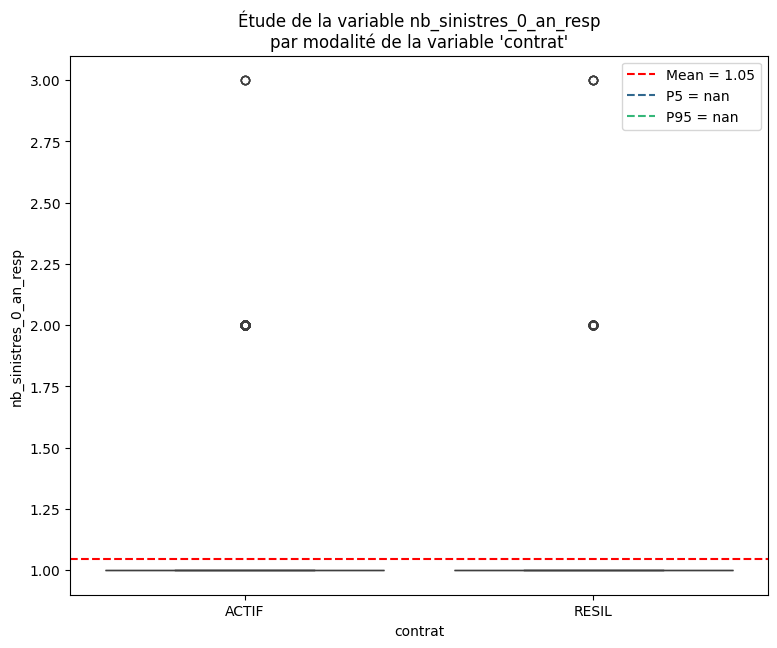

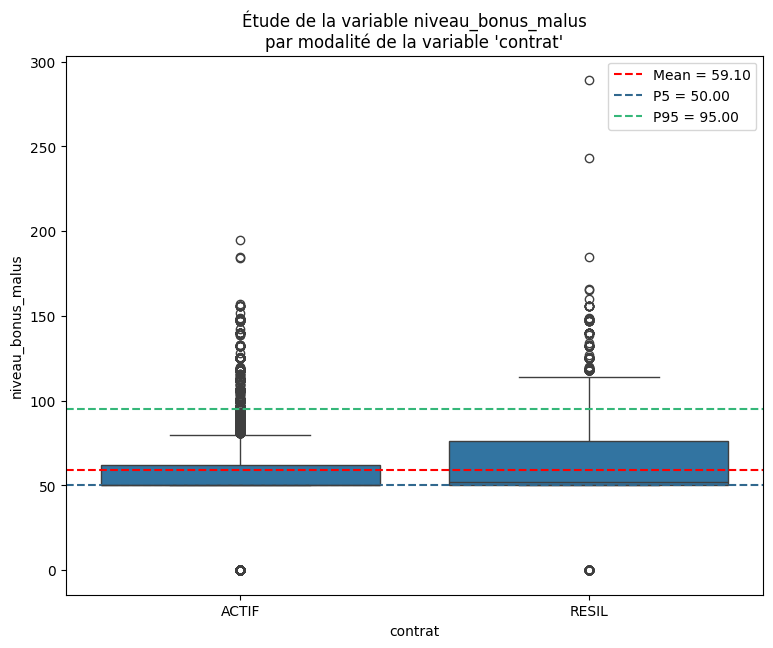

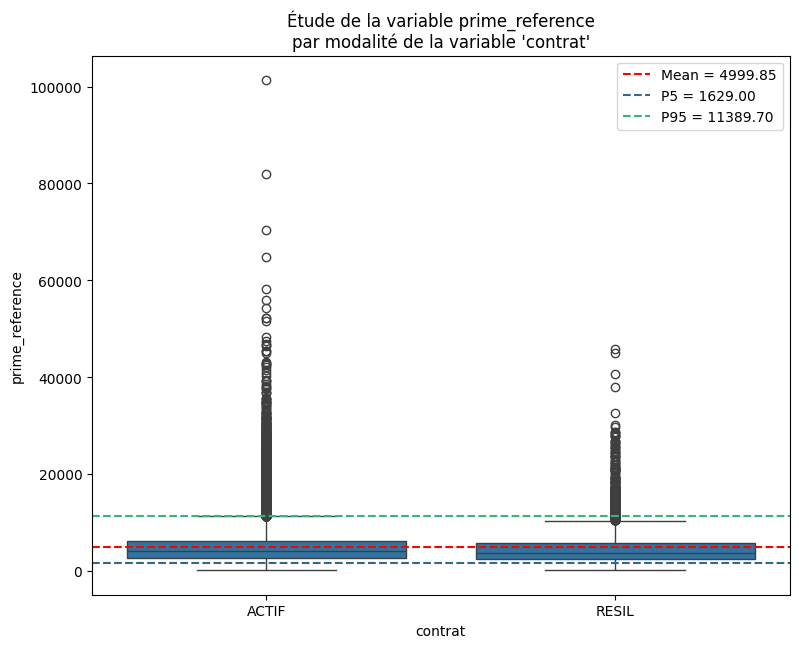

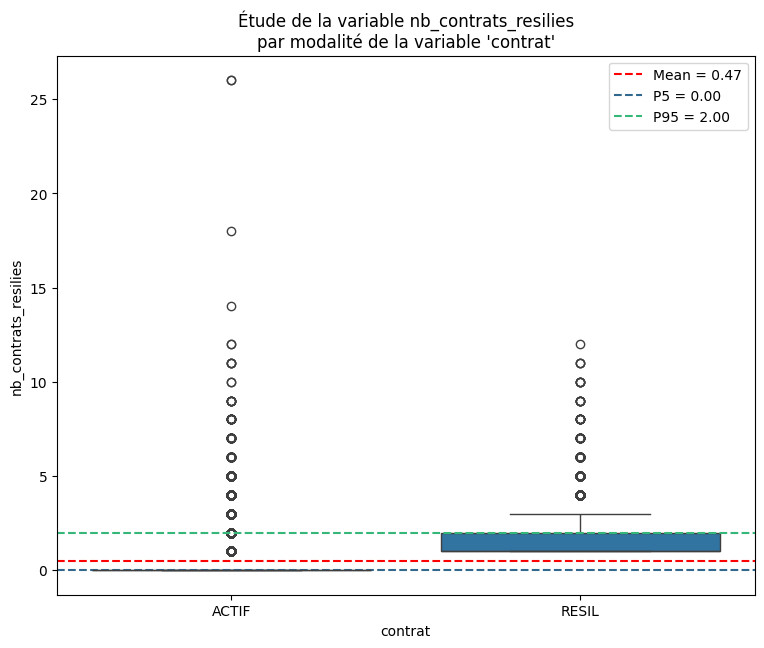

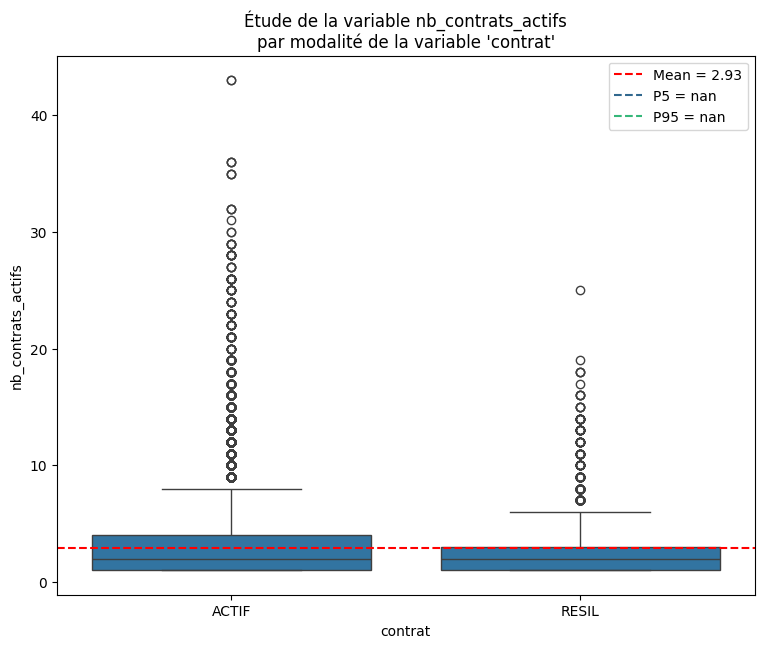

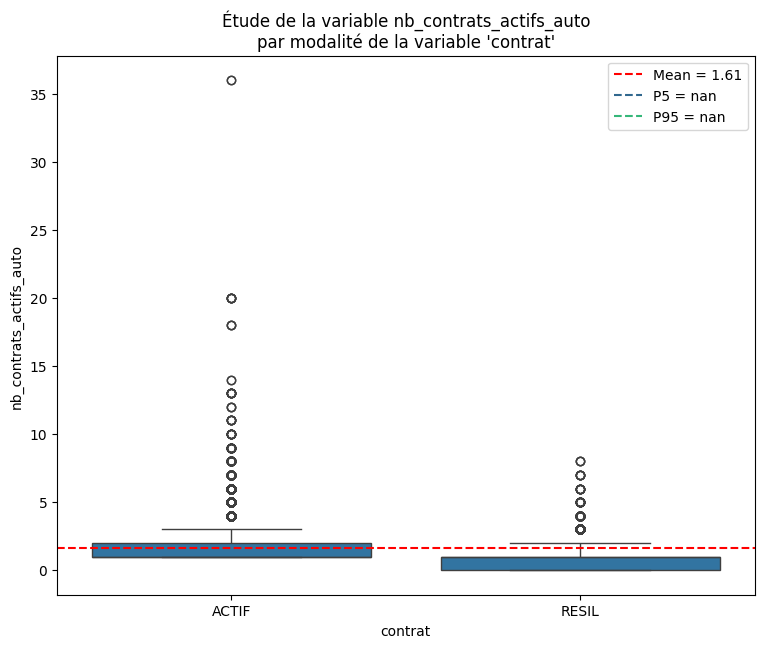

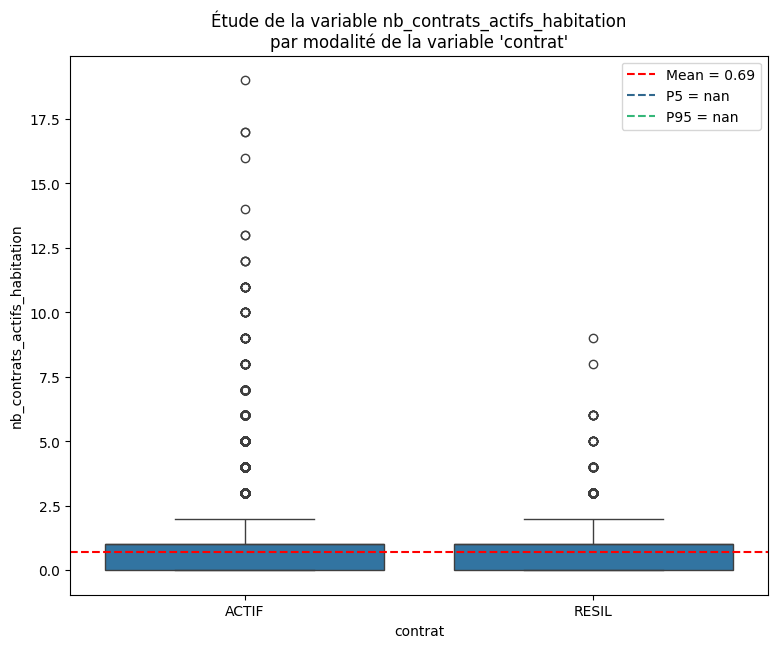

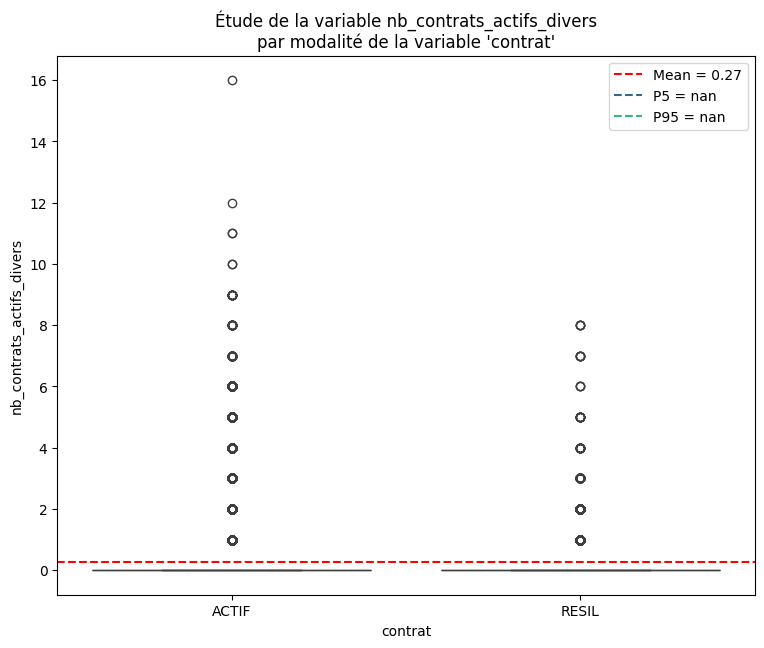

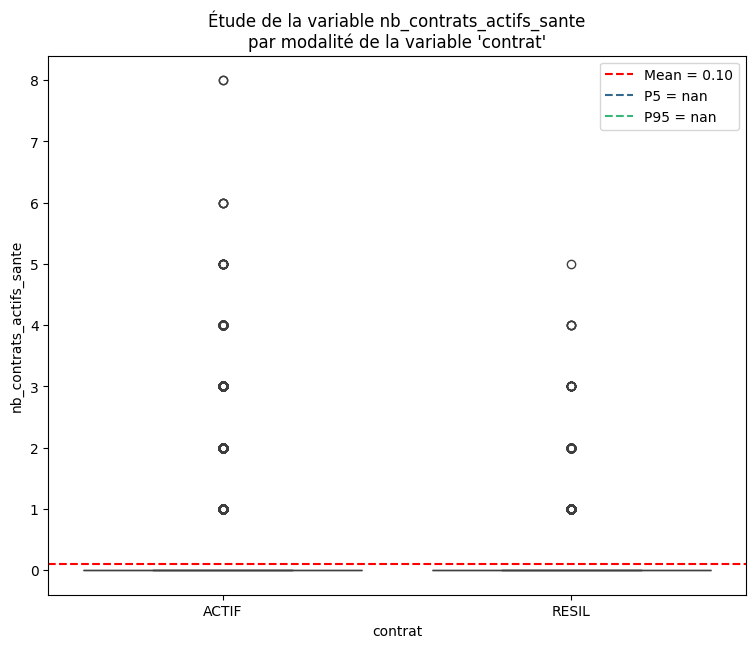

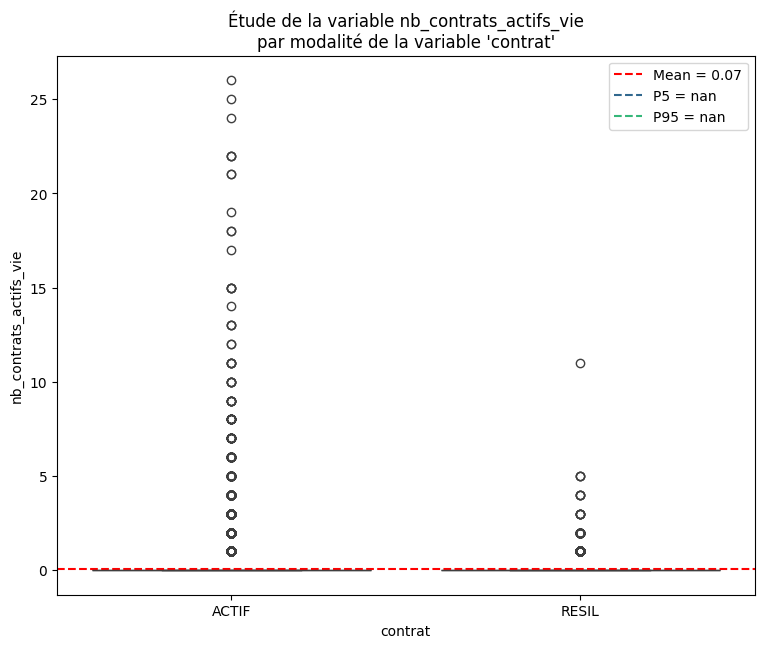

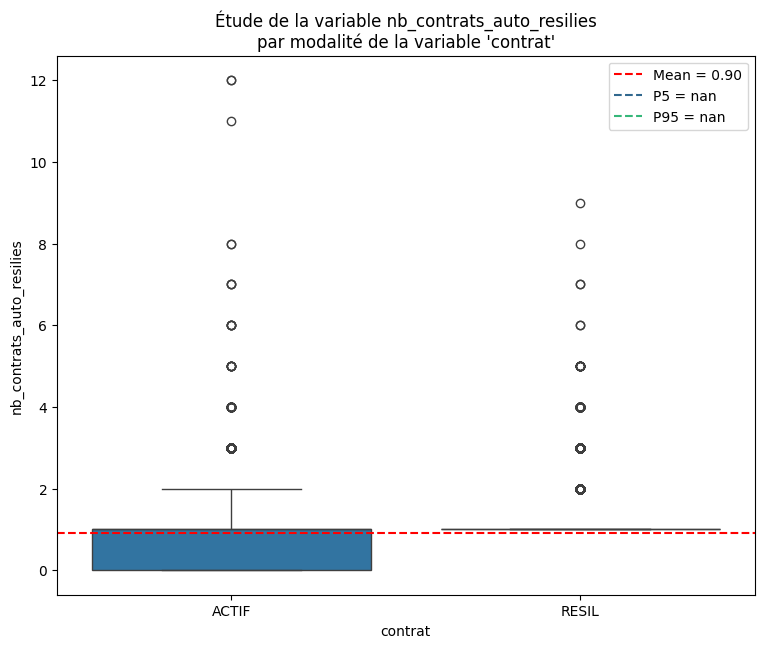

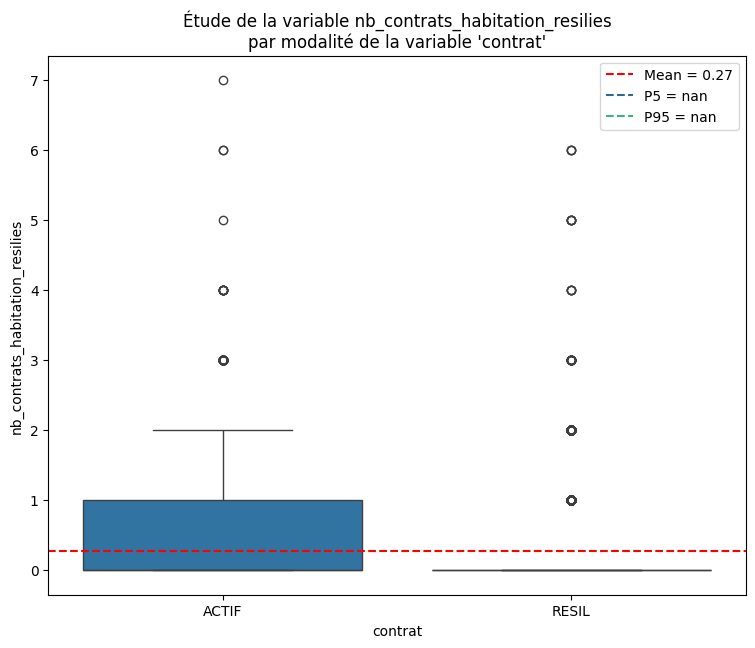

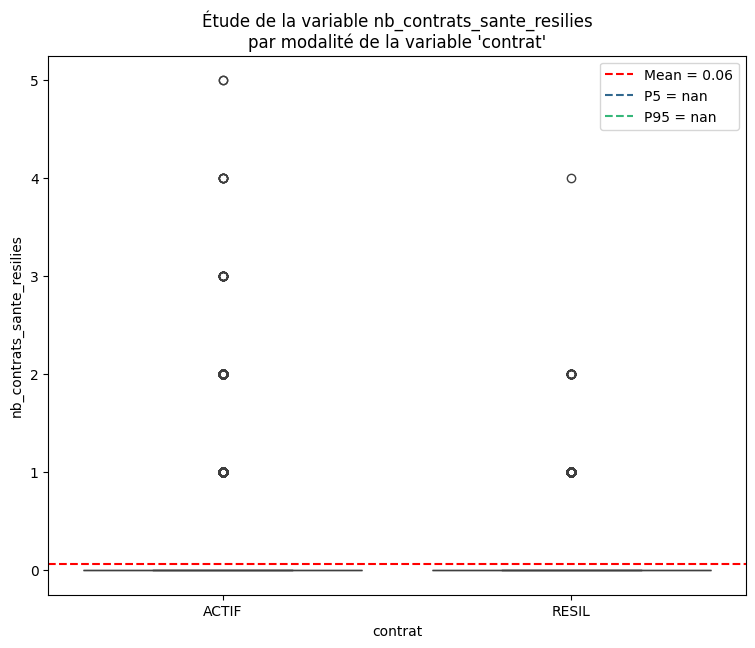

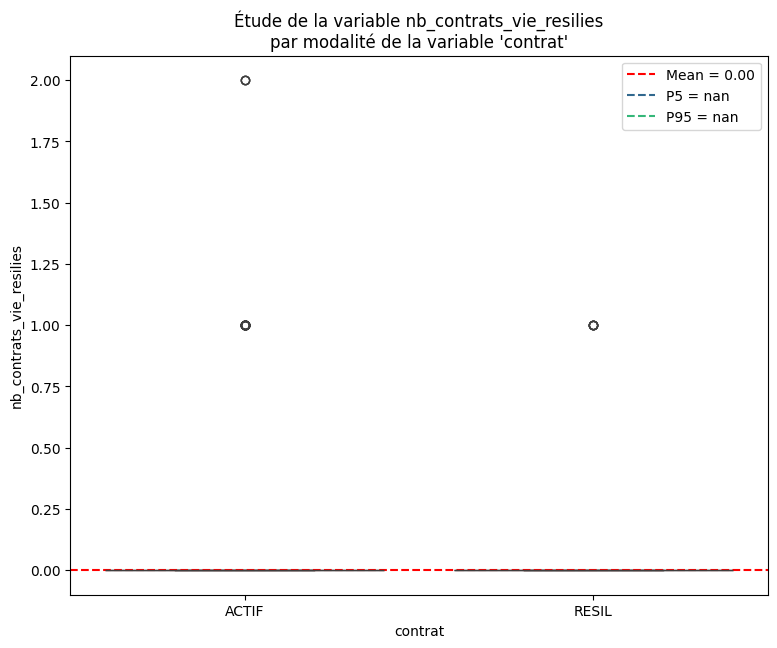

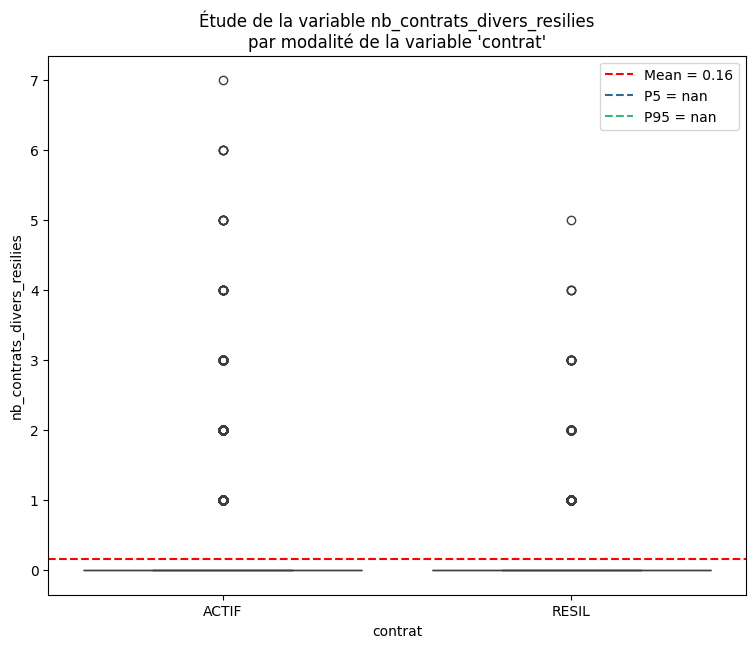

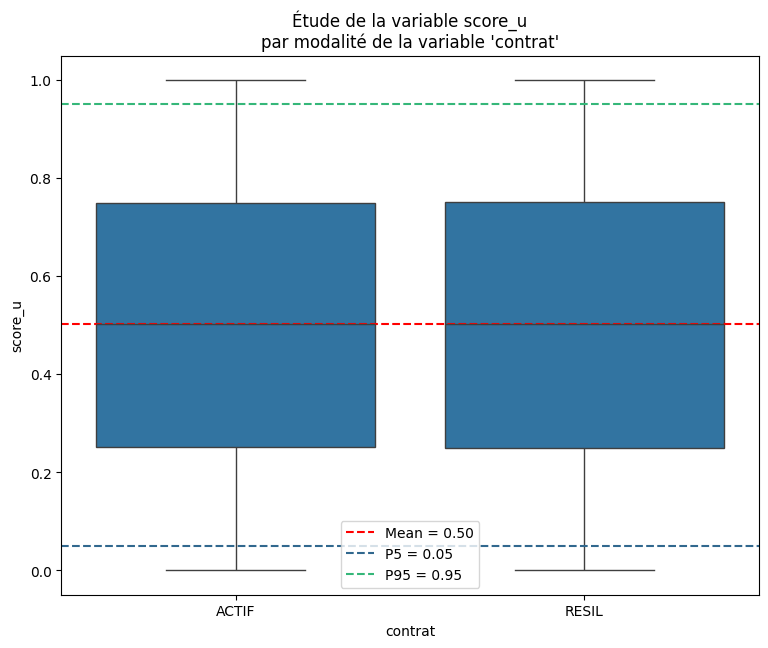

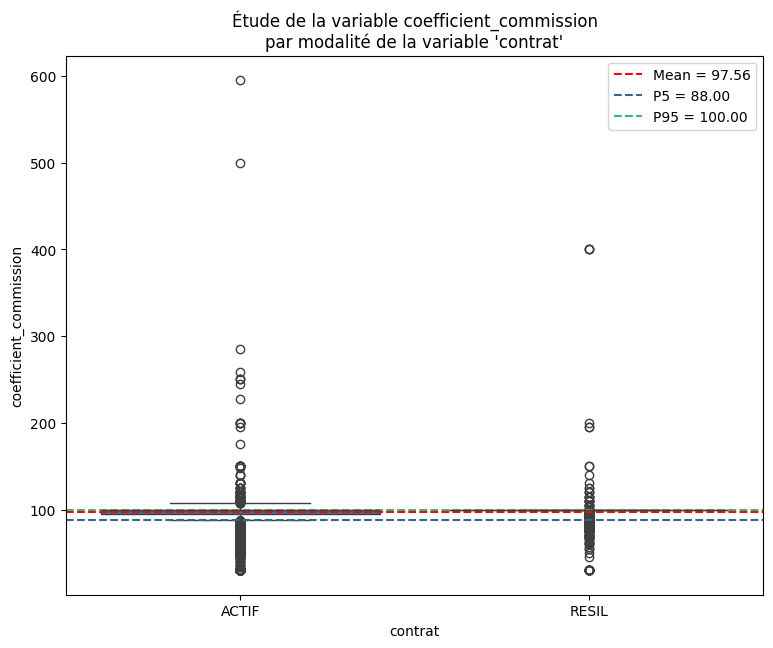

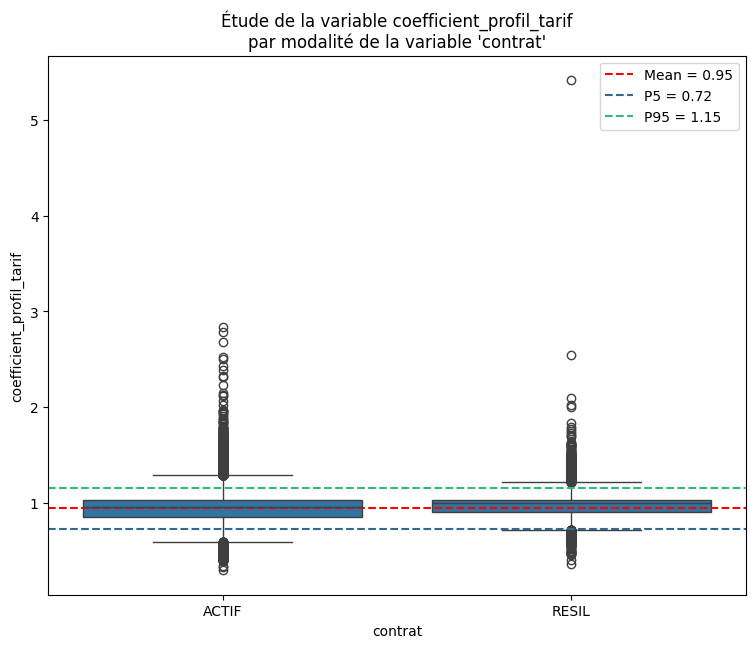

In [ ]:
for field in var_num:
    boxplot_by_target(field,df,"contrat",quantiles=[5,95]) #VOIR POUR CONCATENER LES BOXPLOT

## 2.5 Représentations graphiques avancées (variables continue est catégorielles)

Analyse des taux de défaut en fonction de la variable etat


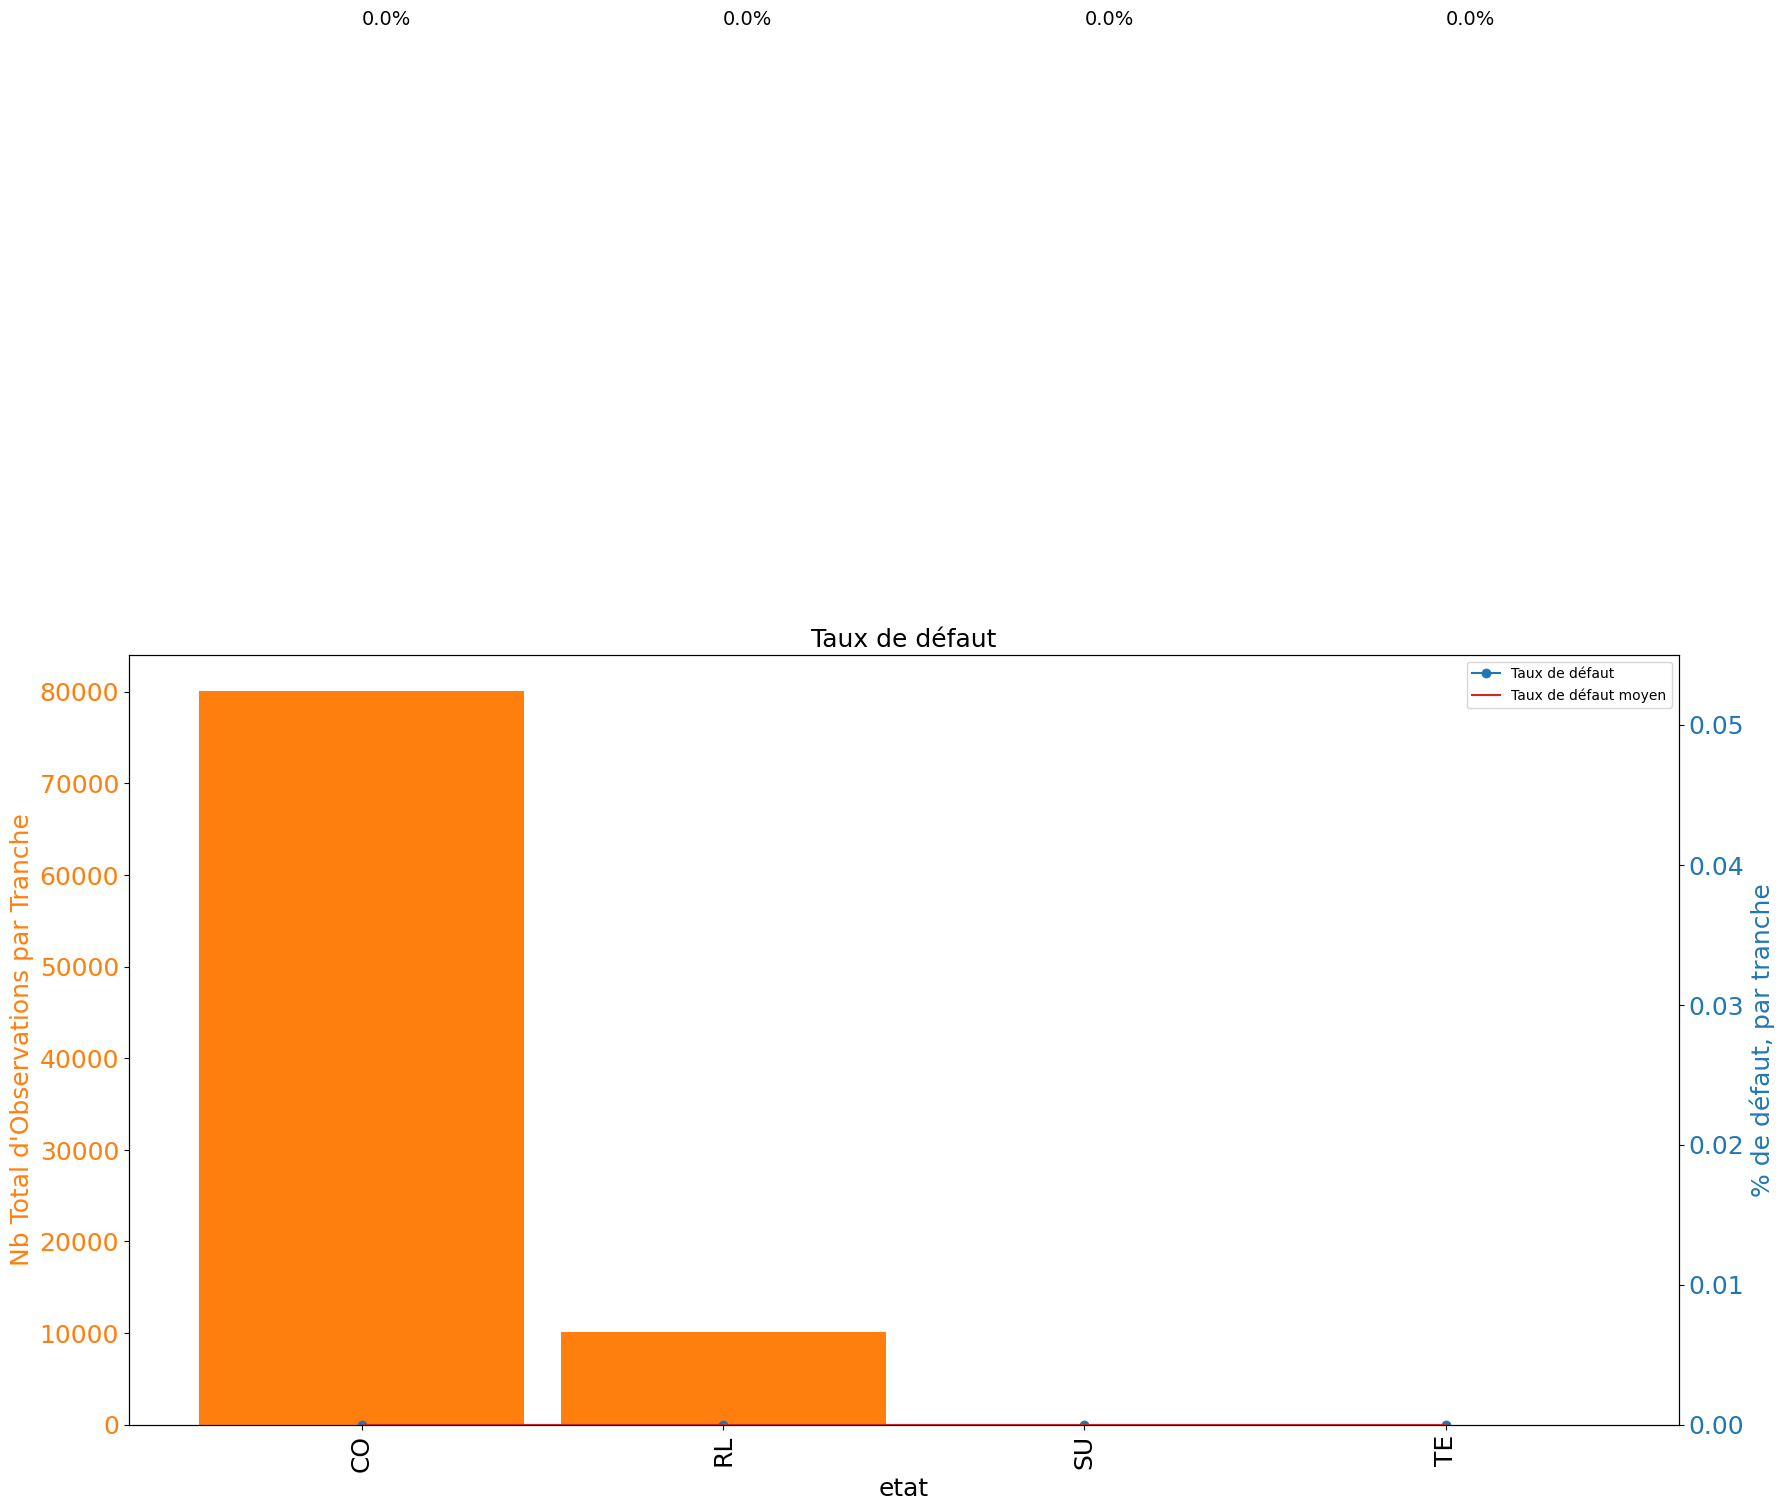

In [ ]:
plot_generic(df,'etat',"contrat", bins=10, force_binning=True)

⚠️ Voir si on fait ça pour d'autre variables importantes. 

## 3. Etude du lien entre variables explicatives et variable cible

Pas forcement très utile pour les modèles à bases d'arbre. Cependant cela reste tres important pour bien comprendre notre base ainsi que nos variables : 
- permet d'avoir un premier a priori sur les facteurs pouvant expliquer la cible (et c'est plus rapide à lancer qu'un modèle)
- permet d'identifier des variables trop "magiques" càd qui expliquent trop bien la cible. Il est possible qu'il s'agissait 
d'un champ construit selon la cible (ex: numéro de contentieux renseigné --> défaut)
- permet de supprimer les variables sans lien avec la cible ce qui permet d'optimiser les temps de calculs (à l'entrainement
mais surtout en production quand le score sera utilisé)

### 3.1. Lien entre les variables explicatives catégorielles

In [ ]:
df_vcramers = cramers_v_between_all(var_cat,df)
df_vcramers

Variable_1               Variable_2  abs_V_cramer  \
50   code_produit_gestion             numero_tarif         1.000   
138           departement                   region         1.000   
108           code_marche                 code_csp         0.970   
62   code_marque_vehicule  libelle_modele_vehicule         0.873   
27             code_agent              departement         0.734   
..                    ...                      ...           ...   
52   code_produit_gestion              code_marche         0.010   
54   code_produit_gestion                     sexe         0.009   
58   code_produit_gestion             client_actif         0.006   
59   code_produit_gestion                     etat         0.006   
150                  etat        motif_resiliation           NaN   

             Chi2 Prob_Chi2  
50   8.998000e+04  < 0.0001  
138  9.004800e+05  < 0.0001  
108  4.757350e+04  < 0.0001  
62   1.602191e+07  < 0.0001  
27   9.460013e+06  < 0.0001  
..            ...       ...  
52   9.677000e+00    0.0849  
54   7.321000e+00    0.1979  
58   3.720000e+00    0.5904  
59   8.430000e+00    0.9054  
150  0.000000e+00       1.0  

[153 rows x 5 columns]

In [ ]:
df_vcramers.sort_values('abs_V_cramer',ascending=False).head(30)

Variable_1               Variable_2  abs_V_cramer  \
50      code_produit_gestion             numero_tarif         1.000   
138              departement                   region         1.000   
108              code_marche                 code_csp         0.970   
62      code_marque_vehicule  libelle_modele_vehicule         0.873   
27                code_agent              departement         0.734   
33              code_formule     code_produit_gestion         0.723   
28                code_agent                   region         0.694   
35              code_formule  libelle_modele_vehicule         0.658   
49      code_produit_gestion  libelle_modele_vehicule         0.654   
147             client_actif                     etat         0.646   
7            code_usage_auto              code_marche         0.605   
34              code_formule     code_marque_vehicule         0.578   
76   libelle_modele_vehicule     rang_valeur_vehicule         0.566   
4            code_usage_auto  libelle_modele_vehicule         0.520   
1            code_usage_auto             code_formule         0.516   
3            code_usage_auto     code_marque_vehicule         0.477   
17                code_agent             code_formule         0.439   
75   libelle_modele_vehicule             numero_tarif         0.435   
2            code_usage_auto     code_produit_gestion         0.424   
48      code_produit_gestion     code_marque_vehicule         0.395   
85   libelle_modele_vehicule        motif_resiliation         0.389   
77   libelle_modele_vehicule              code_marche         0.389   
31                code_agent        motif_resiliation         0.382   
97              numero_tarif                      crm         0.382   
18                code_agent     code_produit_gestion         0.361   
117                 code_csp                     sexe         0.360   
79   libelle_modele_vehicule                     sexe         0.336   
20                code_agent  libelle_modele_vehicule         0.316   
78   libelle_modele_vehicule                 code_csp         0.300   
148             client_actif        motif_resiliation         0.288   

             Chi2 Prob_Chi2  
50   8.998000e+04  < 0.0001  
138  9.004800e+05  < 0.0001  
108  4.757350e+04  < 0.0001  
62   1.602191e+07  < 0.0001  
27   9.460013e+06  < 0.0001  
33   2.344915e+05  < 0.0001  
28   4.336796e+05  < 0.0001  
35   8.933698e+05  < 0.0001  
49   1.925551e+05  < 0.0001  
147  3.770584e+04  < 0.0001  
7    3.298648e+04  < 0.0001  
34   7.193307e+05  < 0.0001  
76   4.907074e+05  < 0.0001  
4    1.485780e+06  < 0.0001  
1    5.740842e+05  < 0.0001  
3    1.434100e+06  < 0.0001  
17   4.158293e+05  < 0.0001  
75   2.722228e+05  < 0.0001  
2    8.099639e+04  < 0.0001  
48   7.025452e+04  < 0.0001  
85   2.124803e+04  < 0.0001  
77   1.366641e+04  < 0.0001  
31   2.054700e+04  < 0.0001  
97   2.098295e+05  < 0.0001  
18   5.892070e+04  < 0.0001  
117  6.545464e+03  < 0.0001  
79   1.016391e+04  < 0.0001  
20   1.124821e+07  < 0.0001  
78   1.057257e+06       1.0  
148  8.327170e+02  < 0.0001

In [ ]:
# lien fort >0.4

💡 CONSTATS ET INTUITIONS : 
------
On remarque directement qu'il faudra garder seulement une variable entre "departement" et "region" (la plus corrélée avec ma cible) -> onb peut supposer qu'on gardera region comme moins de modalités, qu'on recodera. De meme pour "code_produit_gestion" et "numero_tarif".

On remarque aussi que d'autres variables qemble avoir un fort lien que nous devrons traiter.

### 3.2. Lien entre les variables catégorielles et la variable cible

In [ ]:
df_vcramers_target = cramers_v_with_target(var_cat,"contrat",df)
df_vcramers_target

Variable  abs_V_cramer       Chi2 Prob_Chi2
15                     etat         0.995  89339.209  < 0.0001
14             client_actif         0.650  38079.664  < 0.0001
5   libelle_modele_vehicule         0.292   7678.097  < 0.0001
1                code_agent         0.167   2506.438  < 0.0001
6              numero_tarif         0.134   1614.854  < 0.0001
17                      crm         0.129   1504.388  < 0.0001
2              code_formule         0.120   1301.359  < 0.0001
16        motif_resiliation         0.101    101.808  < 0.0001
0           code_usage_auto         0.081    597.038  < 0.0001
9                  code_csp         0.080    327.619  < 0.0001
12              departement         0.068    419.884  < 0.0001
4      code_marque_vehicule         0.058    298.987    0.0304
11      situation_familiale         0.046    193.174  < 0.0001
7      rang_valeur_vehicule         0.045    184.471  < 0.0001
8               code_marche         0.031     85.657  < 0.0001
13                   region         0.025     57.657  < 0.0001
10                     sexe         0.013     16.076    0.0001
3      code_produit_gestion         0.009      8.137    0.1489

💡 CONSTATS ET INTUITIONS : 
------
- On remarque etat (je ne sais pas a quoi cette variable correspond) et client_actif semble tres lié avec la variable cible.

- On remarque que motif_resiliation, code_usage_auto, code_csp, departement, code_marque_vehicule, situation_familiale, rang_valeur_vehicule, code_marche, region, sexe, code_produit_gestion semblent tres peu significatif pour notre modele.

In [ ]:
df['etat'].value_counts()

etat
CO    80031
RL    10170
SU       43
TE        3
Name: count, dtype: int64

### 3.3 Etude du lien entre les variables explicatives continues 

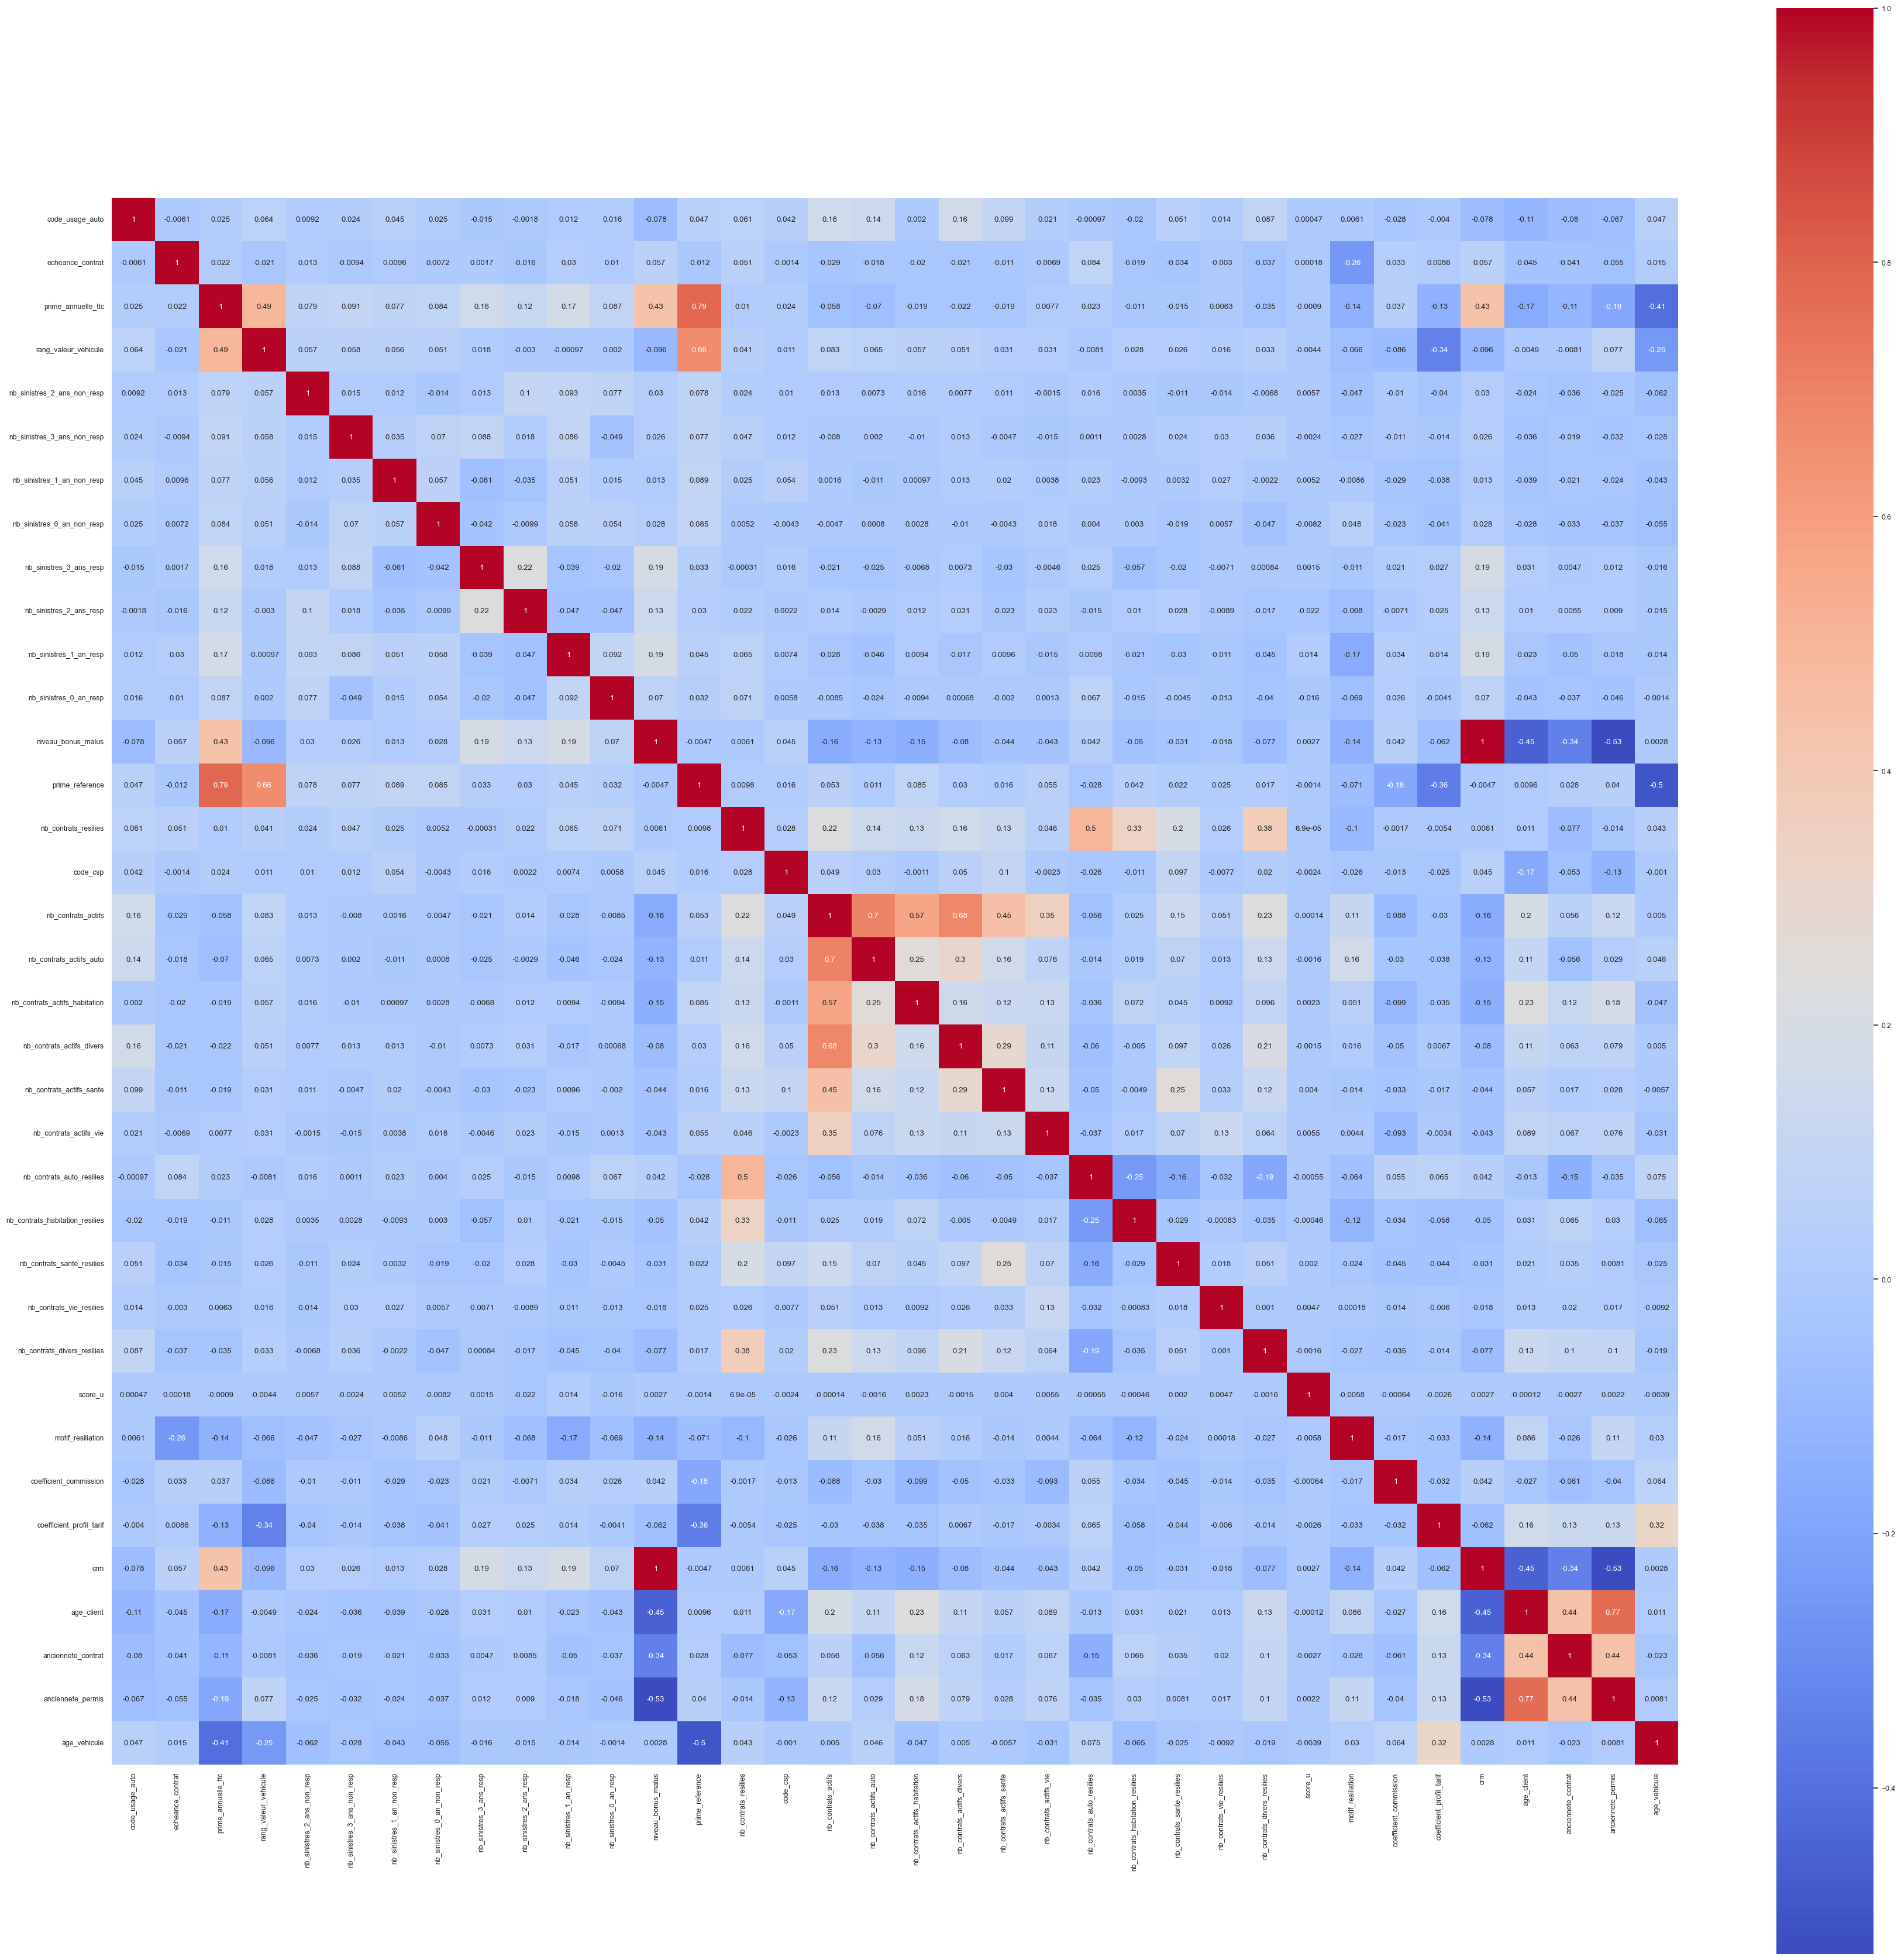

In [ ]:
graph_correlations(var_num,df)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90026 entries, 0 to 90246
Data columns (total 57 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   code_usage_auto                  90010 non-null  float64       
 1   code_agent                       90026 non-null  object        
 2   code_formule                     89484 non-null  object        
 3   code_produit_gestion             90026 non-null  object        
 4   date_debut_contrat               90026 non-null  datetime64[ns]
 5   date_dernier_mouvement           90026 non-null  datetime64[ns]
 6   echeance_contrat                 90010 non-null  float64       
 7   prime_annuelle_ttc               90026 non-null  float64       
 8   code_marque_vehicule             89939 non-null  object        
 9   date_obtention_permis            89884 non-null  datetime64[ns]
 10  date_mise_circulation            89097 non-null  datetime64[ns]

In [ ]:
df_encoded['contrat'].value_counts()

contrat
ACTIF    79920
RESIL    10106
Name: count, dtype: int64

In [ ]:
from scipy.stats import pointbiserialr

df_encoded = df.copy()
df_encoded = df_encoded[df_encoded['contrat'].notna()] #supp nan 
df_encoded['contrat_encoded'] = (df_encoded['contrat'] == 'ACTIF').astype(int)

numerical_cols = df_encoded.select_dtypes(include=['float64', 'int64']).columns

strong_corr = {} # on crée un dictionnaire pour stocker les variables avec les valeurs de corrélation

# boucle pour calculer la corrélation point biserial
for col in numerical_cols:
    if col != 'contrat_encoded' and df_encoded[col].notna().sum() > 0: #il faut pas de NaN dans les variables explicatives sinon ça marche pas
        try:
            corr, _ = pointbiserialr(df_encoded['contrat_encoded'], df_encoded[col])
            if abs(corr) > 0.3:
                strong_corr[col] = round(corr, 2)
        except Exception as e:
            continue  


print("Variables corrélées à 'contrat' (> 0.3) :")
print(strong_corr)


Variables corrélées à 'contrat' (> 0.3) :
{'nb_contrats_resilies': -0.45}


💡 CONSTATS ET INTUITIONS : 
------

### 3.4 Lien entre les variables explicatives continues et la variable cible

Application du Welch’s t-test

<div class="alert alert-block alert-info">
<b>🔔 Rappel :</b> Le Welch’s t-test est un test de Student où on relâche l'hypothèse d'équivariance entre les 2 populations.<br>
H0 : Les distributions de x|y=1 et x|y=0 sont les mêmes (avec x: variable explicative continue, y:variable cible bimodale)
</div>

In [ ]:
for field in var_num:
    a=list(df[df["contrat"]==0][field])
    b=list(df[df["contrat"]==1][field])
    st_test, st_p = st.ttest_ind(a, b, axis=0, equal_var=False, nan_policy='omit')
    print(field + ": p-value test Student = " + str(st_p))

echeance_contrat: p-value test Student = nan
prime_annuelle_ttc: p-value test Student = nan
nb_sinistres_2_ans_non_resp: p-value test Student = nan
nb_sinistres_3_ans_non_resp: p-value test Student = nan
nb_sinistres_1_an_non_resp: p-value test Student = nan
nb_sinistres_0_an_non_resp: p-value test Student = nan
nb_sinistres_3_ans_resp: p-value test Student = nan
nb_sinistres_2_ans_resp: p-value test Student = nan
nb_sinistres_1_an_resp: p-value test Student = nan
nb_sinistres_0_an_resp: p-value test Student = nan
niveau_bonus_malus: p-value test Student = nan
prime_reference: p-value test Student = nan
nb_contrats_resilies: p-value test Student = nan
nb_contrats_actifs: p-value test Student = nan
nb_contrats_actifs_auto: p-value test Student = nan
nb_contrats_actifs_habitation: p-value test Student = nan
nb_contrats_actifs_divers: p-value test Student = nan
nb_contrats_actifs_sante: p-value test Student = nan
nb_contrats_actifs_vie: p-value test Student = nan
nb_contrats_auto_resilies

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


⚠️ revoir 

In [ ]:
df['contrat'].value_counts()

contrat
ACTIF    79920
RESIL    10106
Name: count, dtype: int64